# Athlete Readiness Predictor

###Using data from 100 athletes over 150 days, we will train a model to determine an athlete's readiness for next-day activity (e.g. competition, training etc.).

---------------------------------------------------

###Feature data: physiological, sleep, training load, and recovery.

Physiological:
- Resting Heart Rate (RHR)
- Heart Rate Variability (HRV)
- HRV delta (vs 7-day baseline)
- RHR delta (vs 7-day baseline)

Sleep:
- Sleep duration [hours]
- Sleep efficiency [%]

Training Load:
- Session duration [min]
- Session RPE (Rating of Perceived Exertion) [0-10]
- Internal Load (= RPE x duration)
- Acute Load (7-day sum)
- Chronic Load (28-day average of weekly sums)
- ACWR (Acute Chronic Workload Ratio) (= acute / chronic)
- Day-of-week cycle (encoded as sine)
- Day-of-the-week cycle (encoded as cosine)

Recovery:
- Fatigue (Likert 1-7)
- Soreness (Likert 1-7)
- Previous-day readiness (from t-1)

---------------------------------------------------

###Label data: continuous readiness index (CRI), binary readiness, and ordinal readiness.

- CRI (0-1)
- Binary (Ready / Not Ready)
- Ordinal (very low, low, moderate, high, very high)

---------------------------------------------------

###Feature and label data were created synthetically, however inter-individual variation was inspired by the PPG-Dalia and Sleep-EDF datasets for the physiological and sleep data respectively. All other features were created in a way to mimic this inter-individual variation as well as intra-individual variation.

###Train/Val/Eval will take a leave-one-athlete-out (LOAO) cross-validation approach, where we will train 100 separate model instances (folds) and each fold will be tested on a single athlete (test). That fold will be trained on the remaining 80% of athletes and validate on the remaining 20%.

---------------------------------------------------

training notes:
- we will not include days 1-~34 as they do not have a chronic load, therefore no valid CRI to compare to. `valid_load_feats = False`

In [ ]:
# convert features/labels from csv --> parquet

import pandas as pd
df = pd.read_csv("/content/readiness_timeseries.csv")
df.to_parquet("/content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries.parquet", index=False)

### path setting

In [ ]:
ROOT = "/content/drive/MyDrive/athlete_readiness_project"
RAW = f"{ROOT}/data/raw"

# files
PARQUET = f"{RAW}/readiness_timeseries.parquet"
SCHEMA = f"{RAW}/schema.json"
NORM = f"{RAW}/normalization_stats.json"
SPLITS = f"{RAW}/splits_loao.json"
SIMCFG = f"{RAW}/simulation_config.json"

### inspect and validate dataset



In [ ]:
# verification of existence between .parquet and .json file differ
import pandas as pd, json, os, numpy as np

# .parquet verification
assert os.path.exists(PARQUET), "Parquet file not found at expected path"
df = pd.read_parquet(PARQUET)

# .json verification
with open(SCHEMA) as f: schema = json.load(f)
with open(NORM) as f: norm = json.load(f)
with open(SPLITS) as f: splits = json.load(f)
with open(SIMCFG) as f: simcfg = json.load(f)

print("Rows, Cols:", df.shape)
print("Columns:", list(df.columns))
df.head(3)

Rows, Cols: (15000, 26)
Columns: ['athlete_id', 'day', 'RHR_z', 'HRV_z', 'HRV_delta', 'RHR_delta', 'SleepDur_z', 'SleepEff_z', 'SessDuration', 'RPE_z', 'InternalLoad', 'AcuteLoad_7d', 'ChronicLoad_28dWeeklyMean', 'ACWR', 'dow_sin', 'dow_cos', 'Fatigue_z', 'Soreness_z', 'CRI_prev', 'CRI', 'ReadyBin', 'ReadyOrd', 'valid_load_feats', 'valid_target', 'seed', 'coeff_profile_id']


,athlete_id,day,RHR_z,HRV_z,HRV_delta,RHR_delta,SleepDur_z,SleepEff_z,SessDuration,RPE_z,...,Fatigue_z,Soreness_z,CRI_prev,CRI,ReadyBin,ReadyOrd,valid_load_feats,valid_target,seed,coeff_profile_id
0,1,1,1.345612,-1.050977,0.000000,0.000000,-0.704217,1.372121,69.291912,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,1,False,True,42,1
1,1,2,0.748225,-0.771160,2.098630,-1.493469,0.153777,1.041901,82.968936,-0.100159,...,-0.039175,-0.000424,0.000000,0.192565,0,1,False,True,42,1
2,1,3,0.557268,-0.407392,5.036763,-1.632167,0.333074,0.573430,95.363649,-0.319027,...,0.000828,0.247436,0.192565,0.316160,0,2,False,True,42,1


### schema sanity checks

In [ ]:
# check presence of columns in .parquet file as well as their datatypes
expected_feature_cols = ['RHR_z','HRV_z','HRV_delta','RHR_delta','SleepDur_z','SleepEff_z',
                         'SessDuration','RPE_z','InternalLoad','AcuteLoad_7d',
                         'ChronicLoad_28dWeeklyMean','ACWR','dow_sin','dow_cos',
                         'Fatigue_z','Soreness_z','CRI_prev']
expected_label_cols = ["CRI", "ReadyBin", "ReadyOrd"]
expected_mask_cols = ["valid_load_feats", "valid_target"]
expected_key_cols = ["athlete_id", "day"]

for col in expected_key_cols + expected_feature_cols + expected_label_cols + expected_mask_cols:
  assert col in df.columns, f"Missing column: {col}" # checking column existence

# check datatype of columns
print(df[expected_key_cols + expected_label_cols + expected_mask_cols].dtypes)

athlete_id            int64
day                   int64
CRI                 float64
ReadyBin              int64
ReadyOrd              int64
valid_load_feats       bool
valid_target           bool
dtype: object


### cohort shape checks

In [ ]:
# number of athletes and days per athlete
n_athletes = df["athlete_id"].nunique()
days_per_ath = df.groupby("athlete_id")["day"].nunique().describe() # calculate collective stats for all athlete_ids

print("Unique athletes:", n_athletes)
print("Days per athlete (summary):\n", days_per_ath)
assert n_athletes == 100, "Expected 100 athletes."
assert (df.groupby("athlete_id")["day"].nunique() == 150).all(), "Every athlete should have 150 days."

# count number of LOAO folds
print("LOAO folds:", len(splits))
assert len(splits) == 100, "Expected 100 LOAO folds."

Unique athletes: 100
Days per athlete (summary):
 count    100.0
mean     150.0
std        0.0
min      150.0
25%      150.0
50%      150.0
75%      150.0
max      150.0
Name: day, dtype: float64
LOAO folds: 100


### mask logic and expected NaNs

In [ ]:
# determine proportion of records with valid_load_feats == True and valid_target == True
mask_counts = df[["valid_load_feats", "valid_target"]].mean().round(3) # expect ~ 0.813
print("Mask true-fractions:\n", mask_counts) # expect ~ 0.993

# determine number of days, per athlete, for which valid_load_feats == False and valid_target == False
per_ath_invalid_load = df.groupby("athlete_id").apply(
    lambda x: (~x["valid_load_feats"]).sum()
)

per_ath_invalid_target = df.groupby("athlete_id").apply(
    lambda x: (~x["valid_target"]).sum()
)

print("Invalid load feats per athlete (expect ~28):", per_ath_invalid_load.unique()[:10])
print("Invalid targets per athlete (expect 1):", per_ath_invalid_target.unique()[:10])

# NaNs where expected
na_summary = df[["AcuteLoad_7d", "ChronicLoad_28dWeeklyMean", "ACWR"]].isna().mean().round(3)
print("NaN fraction (expect ~0.187 on chronic/ACWR):\n", na_summary)

Mask true-fractions:
 valid_load_feats    0.813
valid_target        0.993
dtype: float64
Invalid load feats per athlete (expect ~28): [28]
Invalid targets per athlete (expect 1): [1]
NaN fraction (expect ~0.187 on chronic/ACWR):
 AcuteLoad_7d                 0.000
ChronicLoad_28dWeeklyMean    0.000
ACWR                         0.001
dtype: float64


/tmp/ipython-input-507745557.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_ath_invalid_load = df.groupby("athlete_id").apply(
/tmp/ipython-input-507745557.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_ath_invalid_target = df.groupby("athlete_id").apply(


despite non NaN values for first 28 days per athlete, `valid_load_feats == False` will mean that these records will be ignored anyways

### Z-score sanity

In [ ]:
z_cols = ['HRV_z','RHR_z','SleepDur_z','SleepEff_z','Fatigue_z','Soreness_z','RPE_z','CRI_prev']

# find mean and std for all normalized features across all athletes
summary = (
    df.groupby("athlete_id")[z_cols].agg(['mean', 'std'])
    .stack(0)
    .groupby(level=1).mean().round(3)
)
print("Avg within-athlete z stats (mean=0, std=1):\n", summary)

Avg within-athlete z stats (mean=0, std=1):
              mean    std
CRI_prev    0.495  0.404
Fatigue_z   0.290  2.516
HRV_z      -0.451  1.980
RHR_z       0.454  1.965
RPE_z       0.335  2.595
SleepDur_z  0.073  0.301
SleepEff_z -0.188  1.095
Soreness_z  0.168  2.155


/tmp/ipython-input-3268338546.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(0)


means and stds being not equal to 0 and 1 respectively is normal given the asymmetry and reactivity of physiology

### CRI distribution & label balance

In [ ]:
# we expect CRI: 0-1, ReadyBin: 0-1, and ReadyOrd: 1-5
print("CRI range:", float(df["CRI"].min()), float(df["CRI"].max()))
print("ReadyBin balance (mean ~ proportion ready):", df["ReadyBin"].mean().round(3))
print("ReadyOrd value counts:\n", df["ReadyOrd"].value_counts().sort_index())

CRI range: 0.0 0.9999998441078494
ReadyBin balance (mean ~ proportion ready): 0.52
ReadyOrd value counts:
 ReadyOrd
1    5853
2     865
3    1041
4    1446
5    5795
Name: count, dtype: int64


### physiological correlation check

In [ ]:
# records (rows) to compute from
valid = df["valid_load_feats"] & df["valid_target"]
# features for correlations
cols_for_corr = ["CRI", "HRV_z", "RHR_z", "SleepEff_z", "ACWR"]
# calculate correlations
corr = df.loc[valid, cols_for_corr].corr().round(3)

print(corr)

print({
    "CRI~HRV_z>0": float(corr.loc["CRI", "HRV_z"]) > 0,
    "CRI~RHR_z<0": float(corr.loc["CRI", "RHR_z"]) < 0,
    "CRI~Sleepeff_z>0": float(corr.loc["CRI", "SleepEff_z"]) > 0,
    "CRI~ACWR<0": float(corr.loc["CRI", "ACWR"]) < 0
})

              CRI  HRV_z  RHR_z  SleepEff_z   ACWR
CRI         1.000  0.873 -0.835       0.873 -0.225
HRV_z       0.873  1.000 -0.906       0.943 -0.261
RHR_z      -0.835 -0.906  1.000      -0.919  0.253
SleepEff_z  0.873  0.943 -0.919       1.000 -0.252
ACWR       -0.225 -0.261  0.253      -0.252  1.000
{'CRI~HRV_z>0': True, 'CRI~RHR_z<0': True, 'CRI~Sleepeff_z>0': True, 'CRI~ACWR<0': True}


### Weekly rhythm check (sin/cos DOW encodings)

In [ ]:
# check if there's variance between dow_sin and dow_cos
print("dow_sin var:", df["dow_sin"].var(), "dow_cos var:", df["dow_cos"].var())

assert df["dow_sin"].var() > 0 and df["dow_cos"].var() > 0, "DOW encodings should vary."

dow_sin var: 0.5003078219244216 dow_cos var: 0.4995344378998901


### Load feature coherence

In [ ]:
# internal load should track with session duration and higher perceived effort
subset = df.loc[valid, ["InternalLoad", "SessDuration", "RPE_z"]].dropna()
corr_load = subset.corr().round(3)
print("internal correlations:\n", corr_load)

internal correlations:
               InternalLoad  SessDuration  RPE_z
InternalLoad         1.000         0.607  0.685
SessDuration         0.607         1.000 -0.025
RPE_z                0.685        -0.025  1.000


### Inter-individual baselines

In [ ]:
# determine that inter-individual distribution is similar to that of PPG-DaLiA/Sleep-EDF
def quick_stats(arr):
    arr = np.asarray(arr, dtype=float)
    return {
        "min": float(np.min(arr)),
        "q25": float(np.percentile(arr, 25)),
        "mean": float(np.mean(arr)),
        "q75": float(np.percentile(arr, 75)),
        "max": float(np.max(arr)),
    }

# calculate distribution stats for relevant features
for metric in ["HRV", "RHR", "SleepDur", "SleepEff"]:
    means = [ath[metric]["mean"]       for ath in norm.values()]
    sds   = [ath[metric]["sd_within"]  for ath in norm.values()]
    print(f"{metric} baseline means summary:", quick_stats(means))
    print(f"{metric} baseline SDs summary:",   quick_stats(sds))

HRV baseline means summary: {'min': 55.34834499378084, 'q25': 71.78347979752526, 'mean': 79.1965903254405, 'q75': 84.26532658657524, 'max': 110.91227361087347}
HRV baseline SDs summary: {'min': 15.0, 'q25': 15.0, 'mean': 15.0, 'q75': 15.0, 'max': 15.0}
RHR baseline means summary: {'min': 37.61053042687122, 'q25': 45.24835694610681, 'mean': 47.989923053335936, 'q75': 50.380712898011666, 'max': 57.29349757486543}
RHR baseline SDs summary: {'min': 5.0, 'q25': 5.0, 'mean': 5.0, 'q75': 5.0, 'max': 5.0}
SleepDur baseline means summary: {'min': 6.9746384548019735, 'q25': 7.784392138238867, 'mean': 8.061167415021444, 'q75': 8.332182674925086, 'max': 9.231742900503805}
SleepDur baseline SDs summary: {'min': 0.8, 'q25': 0.8, 'mean': 0.7999999999999998, 'q75': 0.8, 'max': 0.8}
SleepEff baseline means summary: {'min': 0.8316072756878916, 'q25': 0.8799523607106893, 'mean': 0.8978584826953262, 'q75': 0.9153390537214908, 'max': 0.972686197989405}
SleepEff baseline SDs summary: {'min': 0.05, 'q25': 0.

### Quick Anomaly Scan

In [ ]:
issues = {}

# negative duration and load check
issues["neg_duration"] = int((df["SessDuration"] < 0).sum())
issues["neg_internal_load"] = int((df["InternalLoad"] < 0).sum())

# ACWR extreme values
v = df.loc[df["valid_load_feats"], "ACWR"]
issues["ACWR>2.5"] = int((v > 2.5).sum())
issues["ACWR<0"] = int((v < 0).sum())

# CRI outside 0-1
issues["CRI<0"] = int((df["CRI"] < 0).sum())
issues["CRI>1"] = int((df["CRI"] > 1).sum())

print("Anomaly counts:", issues)

Anomaly counts: {'neg_duration': 0, 'neg_internal_load': 0, 'ACWR>2.5': 12027, 'ACWR<0': 0, 'CRI<0': 0, 'CRI>1': 0}


high ACWR (> 2.5) just reflects realistic acute spikes

- ACWR was incorrect due to incorrect calcuation of AcuteWorkload
- the below code fixes it

In [ ]:
import pandas as pd
from pathlib import Path

SRC = Path("/content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries.parquet")
DST_CSV = Path("/content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries_corrected.csv")
DST_PQ = Path("/content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries_corrected.parquet")

df = pd.read_parquet(SRC)

# sort athletes' records into chronological order
df = df.sort_values(["athlete_id", "day"]).reset_index(drop=True)

# FIX 1: recalculate Acuteload_7d using 7-day InternalLoad
def recompute_acute(g):
  return g["InternalLoad"].rolling(window=7, min_periods=7).mean()

# for each athlete, produce AcuteLoad_7d using past 7 InternalLoads
df["AcuteLoad_7d"] = df.groupby("athlete_id", group_keys=False).apply(recompute_acute)

# FIX 2: recalculate ChronicLoad_28dWeeklyMean using 28-day AcuteLoad_7d
def recompute_chronic(g):
  return g["AcuteLoad_7d"].rolling(window=28, min_periods=28).mean()

# for each athlete, produce ChronicLoad_28dWeeklyMean using past 28 AcuteLoad_7ds
df["ChronicLoad_28dWeeklyMean"] = df.groupby("athlete_id", group_keys=False).apply(recompute_chronic)

# FIX 3: recalculate ACWR with new acute and chronic values
df["ACWR"] = df["AcuteLoad_7d"] / df["ChronicLoad_28dWeeklyMean"]

# FIX 4: update valid_load_feats to ensure that only those with an acute and chronic score = TRUE
df["valid_load_feats"] = (~df["AcuteLoad_7d"].isna()) & (~df["ChronicLoad_28dWeeklyMean"].isna())

# transfer updated .parquet file to new .csv and .parquet file
df.to_csv(DST_CSV, index=False)
df.to_parquet(DST_PQ, index=False)

# sanity check
mask = df["valid_load_feats"]
acwr = df.loc[mask, "ACWR"]

# find stats on ACWR for records with valid_load_feats=TRUE
summary = acwr.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(3)
rate = {
    "ACWR<0.8": float((acwr < 0.8).mean()),
    "0.8-1.3": float(((acwr >- 0.8) & (acwr <= 1.3)).mean()),
    "1.3-1.5": float(((acwr > 1.3) & (acwr <= 2.0)).mean()),
    "1.5-2.0": float(((acwr > 1.5) & (acwr <= 2.0)).mean()),
    ">2.5": float((acwr > 2.5).mean()),
}

print("ACWR summary (valid_load_feats:\n)", summary)
print("\nACWR band proportions:")
for k, v in rate.items():
  print(f"  {k:>8}: {v:.3f}")

print(f"\nSaved:\n- {DST_CSV}\n- {DST_PQ}")

/tmp/ipython-input-4175118374.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["AcuteLoad_7d"] = df.groupby("athlete_id", group_keys=False).apply(recompute_acute)
/tmp/ipython-input-4175118374.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["ChronicLoad_28dWeeklyMean"] = df.groupby("athlete_id", group_keys=False).apply(recompute_chronic)


ACWR summary (valid_load_feats:
) count    11693.000
mean         1.117
std          0.582
min          0.000
5%           0.713
25%          0.950
50%          1.030
75%          1.148
95%          1.742
max         28.000
Name: ACWR, dtype: float64

ACWR band proportions:
  ACWR<0.8: 0.085
   0.8-1.3: 0.854
   1.3-1.5: 0.113
   1.5-2.0: 0.052
      >2.5: 0.019

Saved:
- /content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries_corrected.csv
- /content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries_corrected.parquet


new `readiness_timeseries_corrected.parquet` holds physiologically realistic values, with ACWR being mostly in a typical range (0.8-1.3) and less in the more extreme ends

## DATA SETUP (IGNORE)

- filter for valid rows

### Filter for Valid Rows

- `valid_load_feats` = TRUE
- `valid_target` = TRUE

In [ ]:
import pandas as pd
from pathlib import Path

# path to corrected parquet
DATA_PATH = Path("/content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries_corrected.parquet")

# load dataset
df = pd.read_parquet(DATA_PATH)
print(f"Loaded {len(df):,} rows from {DATA_PATH.name}")

# filter rows that have valid_load_feats and valid_target
df = df[(df["valid_load_feats"]) & (df["valid_target"])].copy()

print(f"Filtered rows retained: {len(df):,} ({len(df)/15000:.2%} of total expected)")

# update readiness_timeseries_corrected through overwrite
df.to_parquet(DATA_PATH, index=False)
print(f"Filtered dataset saved back to: {DATA_PATH}")

Loaded 15,000 rows from readiness_timeseries_corrected.parquet
Filtered rows retained: 11,600 (77.33% of total expected)
Filtered dataset saved back to: /content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries_corrected.parquet


----------------------------------------------------

----------------------------------------------------

## DATA RE-SETUP

problem with readiness_timeseries.csv file meant that we had to recreate the file. this means re-uploading and re-filtering the file etc.

### .CSV  -->  .parquet (+ filtered)

filtered for...
- `valid_load_feats` == TRUE
- `valid_target` == TRUE

In [ ]:
from pathlib import Path
import pandas as pd

# directories
ROOT = Path("/content/drive/MyDrive/athlete_readiness_project")
RAW = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"

CSV_PATH = RAW / "readiness_timeseries.csv"
PARQUET_RAW_PATH = RAW / "readiness_timeseries.parquet"
PARQUET_FILTERED_PATH = PROC / "readiness_timeseries_filtered.parquet" # filtered in /processed

# load CSV and convert to .parquet
df = pd.read_csv(CSV_PATH)
df.to_parquet(PARQUET_RAW_PATH, index=False)
print(f"Saved raw Parquet to: {PARQUET_RAW_PATH}")

# make sure columns actually exist
required_cols = ["valid_load_feats", "valid_target"]
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing expected columns: {missing}"

# filter for valid_load_feats and valid_target
before = len(df)
df_filt = df[(df["valid_load_feats"] == True) & (df["valid_target"] == True)].copy()
after = len(df_filt)

# save filtered .CSV to .parquet
df_filt.to_parquet(PARQUET_FILTERED_PATH, index=False)
print(f"Saved filtered Parquet to: {PARQUET_FILTERED_PATH}")
print(f"Rows before: {before:,} | rows after filter: {after:,}")
print(f"Kept {after/before:.1%} of rows.")

Saved raw Parquet to: /content/drive/MyDrive/athlete_readiness_project/data/raw/readiness_timeseries.parquet
Saved filtered Parquet to: /content/drive/MyDrive/athlete_readiness_project/data/processed/readiness_timeseries_filtered.parquet
Rows before: 15,000 | rows after filter: 11,600
Kept 77.3% of rows.


### Window Creation & LOAO Split

- integrate splits from `splits_loao.json` then window
- window will be of shape `[14, 17]` for days and features respectively

each fold will have its own save file of arrays, for which there will be a train, validation, and test split of windows

In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

ROOT = Path("/content/drive/MyDrive/athlete_readiness_project")
RAW = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"

PARQUET_FULL = RAW / "readiness_timeseries.parquet"
PARQUET_FILTERED = PROC / "readiness_timeseries_filtered.parquet"
SPLITS_JSON = RAW / "splits_loao.json"

SEQ_LEN = 14 # no. days per window

FEATURE_COLS = [
    "RHR_z","HRV_z","HRV_delta","RHR_delta",
    "SleepDur_z","SleepEff_z","SessDuration","RPE_z",
    "InternalLoad","AcuteLoad_7d","ChronicLoad_28dWeeklyMean","ACWR",
    "dow_sin","dow_cos","Fatigue_z","Soreness_z","CRI_prev"
]
LABEL_COLS = ["CRI", "ReadyBin", "ReadyOrd"]

# load data
df_full = pd.read_parquet(PARQUET_FULL)
df_features = pd.read_parquet(PARQUET_FILTERED)

# make sure all columns present
missing_feats = [c for c in FEATURE_COLS if c not in df_features.columns]
missing_labs_full = [c for c in LABEL_COLS if c not in df_full.columns]
assert not missing_feats, f"Missing feature cols in filtered parquet: {missing_feats}"
assert not missing_labs_full, f"Missing labels cols in full parquet: {missing_labs_full}"

# fast label lookup (e.g. for day 149 where t+1 data not in filter)
labels_lookup = (
    df_full[["athlete_id","day"] + LABEL_COLS]
    .set_index(["athlete_id","day"])
    .to_dict(orient="index") # make each row index a key in output dict
)

# WINDOW CREATION
def make_windows_for_athletes(df_feat: pd.DataFrame, # filtered dataframe
                              athlete_ids, # athletes for which their data to be formatted into windows (train/val/test)
                              seq_len: int = SEQ_LEN):
  """
  Create windows [seq_len, 17] per athlete and targets at t+1:
  returns X (N, seq_len, F), y_cri (N,), y_bin (N,), y_ord (N,), metadata (athlete_id, start_day, target_day) (extra info per window)
  """
  X, y_cri, y_bin, y_ord, meta = [], [], [], [], []

  # extract data only from specific athletes in athlete_ids (e.g. train/val athletes)
  sub = df_feat[df_feat["athlete_id"].isin(athlete_ids)].copy()
  sub.sort_values(["athlete_id", "day"], inplace=True)

  # per athlete, produce windows for given number of days
  # where 'aid' is athlete_id and 'g' is all that athlete's rows
  for aid, g in sub.groupby("athlete_id", sort=False):
    g = g.sort_values("day").reset_index(drop=True) # sort athlete rows in chronological order

    # convert values into numpy
    days = g["day"].to_numpy()
    feats = g[FEATURE_COLS].to_numpy()

    for i in range(0, len(g) - seq_len):
      start_idx = i
      end_idx = i + seq_len - 1
      start_day = int(days[start_idx])
      end_day = int(days[end_idx])
      target_day = end_day + 1

      # skip windows where there days aren't consecutive
      if (end_day - start_day) != (seq_len - 1):
        continue

      # key assignment and label look-up instantiator
      key = (int(aid), int(target_day))
      lab = labels_lookup.get(key, None)
      if lab is None:
        continue # if no next-day label, skip

      X.append(feats[start_idx: start_idx + seq_len, :]) # take specified rows and all columns
      y_cri.append(lab["CRI"])
      y_bin.append(lab["ReadyBin"])
      y_ord.append(lab["ReadyOrd"])
      meta.append((aid, start_day, target_day))

  # to prevent error in case of no windows
  if not X:
    return (np.empty((0, seq_len, len(FEATURE_COLS)), dtype=np.float32),
            np.empty((0,), dtype=np.float32),
            np.empty((0,), dtype=np.int64),
            np.empty((0,), dtype=np.int64),
            [])

  # return
  X = np.asarray(X, dtype=np.float32)
  y_cri = np.asarray(y_cri, dtype=np.float32)
  y_bin = np.asarray(y_bin, dtype=np.int64)
  y_ord = np.asarray(y_ord, dtype=np.int64)
  return X, y_cri, y_bin, y_ord, meta

# BUILD WINDOWS PER FOLD
with open(SPLITS_JSON) as f:
  splits = json.load(f)

SAVE_NUMPY = True

# SAVE ARRAYS PRODUCED IN MAKE_WINDOWS_FOR_ATHLETES
def save_fold_arrays(k, prefix, X, y_cri, y_bin, y_ord, meta):
  out = PROC / "folds" / f"{prefix}_fold_{k:03d}.npz"
  np.savez_compressed(
      out,
      X=X, y_cri=y_cri, y_bin=y_bin, y_ord=y_ord,
      meta=np.array(meta, dtype=object)
  )
  return out

# create train/val/test split given folds
fold_sizes = []
for fold_name, lists in splits.items():

  train_ids = lists["train_ids"]
  val_ids = lists["val_ids"]
  test_id = lists["test_id"]

  # train split
  X_tr, y_tr_cri, y_tr_bin, y_tr_ord, m_tr = make_windows_for_athletes(df_features, train_ids, SEQ_LEN)
  # validation split
  X_va, y_va_cri, y_va_bin, y_va_ord, m_va = make_windows_for_athletes(df_features, val_ids, SEQ_LEN)
  # test split
  X_te, y_te_cri, y_te_bin, y_te_ord, m_te = make_windows_for_athletes(df_features, [test_id], SEQ_LEN)

  # save splits drive
  if SAVE_NUMPY:
    k = int(fold_name.split("_")[-1]) if fold_name.split("_")[-1].isdigit() else len(fold_sizes)+1 # extract number from "fold_XXX"
    p_tr = save_fold_arrays(k, "train", X_tr, y_tr_cri, y_tr_bin, y_tr_ord, m_tr)
    p_va = save_fold_arrays(k, "val", X_va, y_va_cri, y_va_bin, y_va_ord, m_va)
    p_te = save_fold_arrays(k, "test", X_te, y_te_cri, y_te_bin, y_te_ord, m_te)

  # save fold name and its size
  fold_sizes.append({
      "fold": fold_name,
      "train_windows": len(X_tr),
      "val_windows": len(X_va),
      "test_windows": len(X_te)
  })


pd.DataFrame(fold_sizes).head()

,fold,train_windows,val_windows,test_windows
0,fold_001,8058,2040,102
1,fold_002,8058,2040,102
2,fold_003,8058,2040,102
3,fold_004,8058,2040,102
4,fold_005,8058,2040,102


### Tensorizing & General DataLoader Build *

In [ ]:
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

PROC = "/content/drive/MyDrive/athlete_readiness_project/data/processed"

WINDOW_LEN = 14
N_FEATURES = 17
DEVICE = "device" if torch.cuda.is_available() else "cpu"

# load in npz files
def load_npz(fp):
  """Load a .npz and return a dict of arrays."""
  with np.load(fp, allow_pickle=True) as d:
    X = d["X"]
    y_cri = d["y_cri"]
    y_bin = d["y_bin"]
    y_ord = d["y_ord"]
    meta = dict(d.items())
  return X, y_cri, y_bin, y_ord, meta

# conversion to tensors and extraction functions
class MultiTaskWindowDataset(Dataset):
  """
  Returns:
  X: float32 [W, F]
  y: dict with keys {"cri", "bin", "ord"} -> tensors (float32, float32, int64)
  """
  def __init__(self, X, y_cri, y_bin, y_ord, window_len=14, n_features=17):
    # convert to tensors
    self.X = torch.from_numpy(X).float() # to [N, W, F] float32
    self.y_cri = torch.from_numpy(y_cri).float().view(-1, 1) # to [N, 1] float32
    self.y_bin = torch.from_numpy(y_bin).float().view(-1, 1) # to [N, 1] float32
    self.y_ord = torch.from_numpy(y_ord).long().view(-1) # to [N] int64

    # sanity check
    assert self.X.ndim == 3 and self.X.shape[1] == window_len and self.X.shape[2] == n_features, f"Unexpected X shape {self.X.shape}; expected [N,{window_len},{n_features}]"
    assert len(self.X) == len(self.y_cri) == len(self.y_bin) == len(self.y_ord)


  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    y = {
        "cri": self.y_cri[idx],
        "bin": self.y_bin[idx],
        "ord": self.y_ord[idx]
    }
    return self.X[idx], y

# function for dataloader creation
def build_loader(npz_path, batch_size=64, shuffle=False, num_workers=2, pin_memory=True):
  X, y_cri, y_bin, y_ord, _ = load_npz(npz_path)
  ds = MultiTaskWindowDataset(X, y_cri, y_bin, y_ord)
  return DataLoader(
      ds,
      batch_size=batch_size,
      shuffle=shuffle,
      num_workers=num_workers,
      pin_memory=pin_memory,
      drop_last=False
  )

### Build Loaders for Specific LOAO Fold

- given a fold_id, extract the file names of the train, val, and test data using
- load the data within the train/val/test files
- convert data (numpy arrays) into tensors and then into dataloaders (batches)

output dataloader shapes:
- X: [B, 14, 17]
- CRI: [B, 1]
- BIN: [B, 1]
- ORD: [B]

In [ ]:
# extract train/val/test for specific folds
def fold_paths(fold_id: int):
  """Return train/val/test file paths for a given fold index (1..100)"""
  def p(split):
    return os.path.join(PROC / "folds", f"{split}_fold_{fold_id:03d}.npz")
  return p("train"), p("val"), p("test")

def build_loaders_for_fold(fold_id: int, batch_size=64):
  # extract train/val/test paths of folds
  train_fp, val_fp, test_fp = fold_paths(fold_id)

  # build dataloader
  train_loader = build_loader(train_fp, batch_size=batch_size, shuffle=True)
  val_loader = build_loader(val_fp, batch_size=batch_size, shuffle=False)
  test_loader = build_loader(test_fp, batch_size=batch_size, shuffle=False)

  # confirmation of batches' size etc
  xb, yb = next(iter(train_loader))
  print(f"[Fold {fold_id:03d}] train batch X: {xb.shape} (should be [B,{WINDOW_LEN},{N_FEATURES}])")
  print(" labels: CRI", yb["cri"].shape, "BIN", yb["bin"].shape, "ORD", yb["ord"].shape)

  return train_loader, val_loader, test_loader

sanity check and build model...

### Sanity Check

In [ ]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

PROC = Path("/content/drive/MyDrive/athlete_readiness_project/data/processed")
RAW = Path("/content/drive/MyDrive/athlete_readiness_project/data/raw")
unfiltered_parquet = RAW / "readiness_timeseries.parquet"
filtered_parquet = PROC / "readiness_timeseries_filtered.parquet"

# load unfiltered dataset
df = pd.read_parquet(unfiltered_parquet)
print(f"Loaded unfiltered dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")

# load filtered dataset
df_filtered = pd.read_parquet(filtered_parquet)
print(f"Loaded filtered dataset: {df_filtered.shape[0]:,} rows, {df_filtered.shape[1]} columns")

# number of rows without corresponding label
df["has_next_day"] = df.groupby("athlete_id")["valid_target"].shift(-1)
missing_next = (df["has_next_day"] == False).sum()
print(f"Missing next-day labels (expect ~100): {missing_next}")

# check normalized features' stats
z_cols = [c for c in df_filtered.columns if c.endswith("_z")]
summary = df_filtered[z_cols].describe().loc[["mean", "std", "min", "max"]].round(3)
print("\nZ-feature distribution summary (should be roughly mean~0, std~1):")
print(summary)

# label stats
label_stats = df_filtered[["CRI", "ReadyBin", "ReadyOrd"]].describe().round(3)
print("\nLabel summary:")
print(label_stats)
print(f"ReadyBin proportion = {df_filtered["ReadyBin"].mean():.3f}")
print("ReadyOrd value counts:")
print(df_filtered["ReadyOrd"].value_counts(normalize=True).round(3))

# number of valid rows
valid_counts = df[["valid_load_feats", "valid_target"]].sum()
print("\nValidity flags (should be < total rows):")
print(valid_counts)

# confirm no overlap of athletes between train/val/test
import json
splits_path = RAW / "splits_loao.json"
with open(splits_path) as f:
  splits = json.load(f)

first_fold = splits["fold_001"]

train_ids = set(first_fold["train_ids"])
val_ids = set(first_fold["val_ids"])

ti = first_fold["test_id"]
test_ids = {ti} if isinstance(ti, int) else set(ti)

overlap = len((train_ids & val_ids) | (train_ids & test_ids) | (val_ids & test_ids)) # ensure that no athlete_id is in more than one
print(f"\nOverlap between train/val/test athlete IDs (should be 0): {overlap}")

# DataLoader sample check
try:
  train_loader_check, val_loader_check, test_loader_check = build_loaders_for_fold(1, batch_size=64)
  xb_check, yb_check = next(iter(train_loader_check))
  print(f"\nTensor sanity check: X {xb_check.shape}, y_cri {yb_check["cri"].shape}, y_bin {yb_check["bin"].shape}, y_ord {yb_check["ord"].shape}")
except Exception as e:
  print("\nSkipped loader check (no npz files yet):", e)

Loaded unfiltered dataset: 15,000 rows, 24 columns
Loaded filtered dataset: 11,600 rows, 24 columns
Missing next-day labels (expect ~100): 100

Z-feature distribution summary (should be roughly mean~0, std~1):
      RHR_z  HRV_z  SleepDur_z  SleepEff_z  RPE_z  Fatigue_z  Soreness_z
mean -0.047  0.057       0.038       0.032  0.051     -0.056      -0.044
std   0.976  0.976       0.211       0.531  1.369      1.276       1.147
min  -5.293 -3.114      -0.754      -1.747 -4.327     -5.383      -4.874
max   2.860  4.791       0.806       2.273  3.904      3.436       3.285

Label summary:
             CRI   ReadyBin   ReadyOrd
count  11600.000  11600.000  11600.000
mean       0.497      0.489      1.974
std        0.336      0.500      1.561
min        0.000      0.000      0.000
25%        0.180      0.000      0.000
50%        0.485      0.000      2.000
75%        0.817      1.000      4.000
max        1.000      1.000      4.000
ReadyBin proportion = 0.489
ReadyOrd value counts:
ReadyOr

## Building the Model

In [ ]:
import math, os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, f1_score

### Quadratic Weighted Kappa (QWK) - ReadyOrd Performance Metric

Performance metric used on ReadyOrd which measures the accuracy of the model in predicting classes relative to the true class. It punishes predictions that are farther from the true value greater.

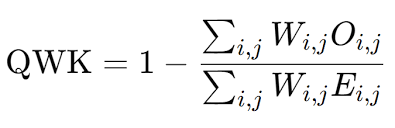

Each element in the observed (O) and expected (E) matrices holds a frequency value. That frequency value represents the frequency of that particular `y_true` and `y_pred` combination. Combinations that are desirable (`y_true`=`y_pred` or close) will have a lower weighting which contributes to a higher overall QWK value.

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred, n_classes=5):
  # convert to numpy arrays
  y_true = np.asarray(y_true, dtype=int)
  y_pred = np.asarray(y_pred, dtype=int)

  # observed matrix setup
  O = np.zeros((n_classes, n_classes), dtype=float)
  for t, p in zip(y_true, y_pred):
    O[t, p] += 1.0 # confusion matrix of absolute value combinations between y_true and y_pred

  # expected matrix setup
  act_hist = np.bincount(y_true, minlength=n_classes).astype(float)
  pred_hist = np.bincount(y_pred, minlength=n_classes).astype(float)
  E = np.outer(act_hist, pred_hist) / max(1.0, len(y_true)) # confusion matrix of expected proportional combinations between y_true and y_pred

  # weights
  W = np.zeros((n_classes, n_classes), dtype=float)
  for i in range(n_classes):
    for j in range(n_classes):
      W[i, j] = ((i - j) ** 2) / ((n_classes - 1) ** 2) # weight calculation per y_true and y_pred combination

  # normalize observed and expected matrices
  O = O / O.sum()
  E = E / E.sum()

  # compute QWK
  num = (W * O).sum() # numerator
  den = (W * E).sum() + 1e-12 # denominator; 1e-12 to prevent division by 0
  return 1.0 - num / den

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

### Sinusoidal Positional Encoding

The inclusion of sine/cosine waves allow for the model's identification of days between each other in the window. Allows for temporal patterns to be recognised.

In [ ]:
class SinusoidalPositionalEncoder(nn.Module):
  def __init__(self, d_model, max_len=512):
    super().__init__()

    pe = torch.zeros(max_len, d_model) # container for positions
    pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1) # day index per row

    # frequency generation (one per even dimension)
    div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(pos * div) # sine
    pe[:, 1::2] = torch.cos(pos * div) # cosine

    # pe as a non-trainable tensor
    self.register_buffer("pe", pe)

  # adds position to days
  def forward(self, x):
    # x: [B, T, d_model]
    T = x.size(1)
    return x + self.pe[:T].unsqueeze(0)

### Attention Pooling

[B, 14, d_model] --> [B, d_model] ; combine all feature interactions over 14 days into one value, with each value representing a single feature interaction

In [ ]:
class AttentionPooling(nn.Module):
  """
  Additive attention over time.
  Input: H [B, 14, d_model] from encoder
  Output: z [B, d_model] pooled representation

  calculate attention weights for each day and then apply them to H for optimal
  feature-interaction representation over 14 days
  """
  def __init__(self, d_model):
    super().__init__()
    # layers, where w and v parameters are trainable
    self.w = nn.Linear(d_model, d_model) # reshape feature interactions to help attention compute relevance
    self.v = nn.Linear(d_model, 1, bias=False) # summarise all interactions' 14-day window into 1

  def forward(self, H, mask=None): # H: [B, 14, d_model]
    # attention weight calculation; how much each day contributes to summary
    scores = torch.tanh(self.w(H)) # [B, T, d_model]
    scores = self.v(scores).squeeze(-1) # [B, T]

    # mask on False values
    if mask is not None:
      scores = scores.masked_fill(~mask, -1e9)

    # attention weight per day
    attn = torch.softmax(scores, dim=1)

    # apply attention weights to days, then collapse [B, T, d] -> [B, d_model]
    z = torch.einsum("bt, btd -> bd", attn, H)

    return z, attn

### Ordinal Head (CORAL) & Loss Helper

The calculation of a loss value for the ReadyOrd label by splitting the loss into K-1 (K being number of classes) thresholds, for which the model predicts a probability of the window's label being in each threshold. Predictions further from the true label will have a greater loss due to the accumulated incorrect loss thresholds.

In [ ]:
class CORALOrdinalHead(nn.Module):
  """
  CORAL: produce K-1 thresholds. Here K=5 -> 4

  all feature interactions summarising 14 days will be collapsed into 1 value, for which
  the parameters in FC layer will train itself on accurately predicting threshold probabilities
  """
  def __init__(self, d_in, n_classes=5):
    super().__init__()
    self.n_classes = n_classes
    self.fc = nn.Linear(d_in, 1) # [B, d_model] -> [B, 1] where '1' is prediction
    self.bias = nn.Parameter(torch.zeros(n_classes - 1)) # biases per threshold

  def forward(self, z):
    base = self.fc(z) # [B, 1]
    logits = base + self.bias # [B, K-1], split 'readiness' score into 4 scores, 1 for each threshold
    return logits.squeeze(-1) # [B, K-1]

Convert true ordinal label (e.g. `y=3` for the 4th category) into a tensor of threshold fulfilments, where 0 indicates not met, and 1 indicates met.

In [ ]:
def coral_targets(y, n_classes=5):
  """
  y: [B], where every value is the true label
  return: [B, K-1], where every threshold is assigned either 0 or 1
  """
  y = y.view(-1, 1)
  thresholds = torch.arange(n_classes - 1, device=y.device).view(1, -1)
  return (y > thresholds).float()

After converting true label into its thresholds, return the binary cross entropy (BCE) mean of entire batch

In [ ]:
def coral_loss(logits, y, n_classes=5):
  """
  BCE comparing logits to true value thresholds
  """
  # creation of threshold
  target = coral_targets(y, n_classes)
  # binary cross entropy
  return F.binary_cross_entropy_with_logits(logits, target, reduction="mean") # mean loss across batch returned

Function used during evaluation to determine predicted class which can then be used to determine other useful metrics

In [ ]:
def coral_predict(logits):
  """
  Predict class index by counting how many thresholds are fulfilled.
  """
  probs = torch.sigmoid(logits)
  return torch.sum(probs > 0.5, dim=1)

### Transformer Model Setup

In [ ]:
class ReadinessTransformer(nn.Module):
  def __init__(
      self,
      n_features=17,
      d_model=128,
      n_heads=4, # 4 pattern types being explored
      n_layers=3, # 3 layers of depth to the pattern being explored
      d_ff=512, # number of feature interactions over 4 heads
      dropout=0.1,
      n_classes_ord=5,
      use_sinusoidal_positional_encoding=True):

    super().__init__()

    # linear projection + sinusoidal encoding
    self.proj = nn.Linear(n_features, d_model)
    self.pos = SinusoidalPositionalEncoder(d_model) if use_sinusoidal_positional_encoding else nn.Identity()

    # [B, 14, 128] where 128 feature interactions are split into 32 for 4 heads,
    # where 512 hidden units are applied to then output [B, 14, 128] once more
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=d_model,
        nhead=n_heads,
        dim_feedforward=d_ff,
        dropout=dropout,
        batch_first=True,
        activation="gelu",
        norm_first=True
    )

    # 3 layers, where each layer explores the pattern in more depth
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    # attention pooling
    self.pool = AttentionPooling(d_model)

    # label heads
    self.head_cri = nn.Sequential(
        nn.Linear(d_model, d_model),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(d_model, 1)
    )
    self.head_bin = nn.Sequential(
        nn.Linear(d_model, d_model),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(d_model, 1)
    )
    self.head_ord = CORALOrdinalHead(d_model, n_classes=n_classes_ord)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x, attn_mask=None):
    """
    """
    # [B, 14, 17] --> [B, 14, 128]
    h = self.proj(x)

    # [B, 14, 128] --> [B, 14, 128]
    h = self.pos(h)

    # [B, 14, 128] --> [B, 14, 128]
    h = self.encoder(h, src_key_padding_mask=None)

    # [B, 14, 128] --> [B, 128]
    z, attn_w = self.pool(h, mask=None)

    # CRI
    cri_logit = self.head_cri(z)
    cri_hat = self.sigmoid(cri_logit)

    # BIN and ORD
    bin_logit = self.head_bin(z) # [B, 1]
    ord_logits = self.head_ord(z) # [B, K-1]

    return cri_hat, bin_logit, ord_logits, attn_w

### Training

In [ ]:
def train_one_epoch(model, loader, optimizer, clf_weights, n_classes_ord=5):
  model.train()
  w_cri, w_bin, w_ord = clf_weights # weights contributing to total loss
  total_loss = 0
  n = 0

  for X, y in loader:
    # device agnostic
    X = X.to(DEVICE)
    y_cri = y["cri"].to(DEVICE)
    y_bin = y["bin"].to(DEVICE)
    y_ord = y["ord"].to(DEVICE)

    # forward
    cri_hat, bin_logit, ord_logits, _ = model(X)

    # loss
    loss_cri = F.mse_loss(cri_hat, y_cri)
    loss_bin = F.binary_cross_entropy_with_logits(bin_logit, y_bin)
    loss_ord = coral_loss(ord_logits, y_ord, n_classes=n_classes_ord)

    loss = w_cri*loss_cri + w_bin*loss_bin + w_ord*loss_ord

    # zero-grad
    optimizer.zero_grad(set_to_none=None)

    # backprop
    loss.backward()

    # gradient clipping
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # gradient descent
    optimizer.step()

    # total_loss calculation as loss calculated is average
    bs = X.size(0)
    total_loss += loss.item() * bs
    n += bs

  # average across all datapoints
  return total_loss / max(1, n)

### Evaluation

Set up code for validation and testing evaluation

In [ ]:
@torch.no_grad()
def evaluate(model, loader, n_classes_ord=5):
  model.eval()
  losses = []

  y_true_cri, y_pred_cri = [], []
  y_true_bin, y_prob_bin = [], []
  y_true_ord, y_pred_ord = [], []

  for X, y in loader:
    # device agnostic
    X = X.to(DEVICE)
    y_cri = y["cri"].to(DEVICE)
    y_bin = y["bin"].to(DEVICE)
    y_ord = y["ord"].to(DEVICE)

    # forward
    cri_hat, bin_logit, ord_logits, _ = model(X)

    # loss
    loss_cri = F.mse_loss(cri_hat, y_cri)
    loss_bin = F.binary_cross_entropy_with_logits(bin_logit, y_bin)
    loss_ord = coral_loss(ord_logits, y_ord, n_classes=n_classes_ord)
    loss = loss_cri + loss_bin + loss_ord
    losses.append(loss.item()) # average loss per batch

    # predictions for metrics
    y_true_cri.append(y_cri.cpu().numpy())
    y_pred_cri.append(cri_hat.cpu().numpy())

    y_true_bin.append(y_bin.cpu().numpy())
    y_prob_bin.append(torch.sigmoid(bin_logit).cpu().numpy())

    pred_ord = coral_predict(ord_logits).cpu()
    y_true_ord.append(y_ord.cpu().numpy())
    y_pred_ord.append(pred_ord.numpy())

  # concatenate into 1D array
  y_true_cri = np.concatenate(y_true_cri).reshape(-1)
  y_pred_cri = np.concatenate(y_pred_cri).reshape(-1)

  y_true_bin = np.concatenate(y_true_bin).reshape(-1)
  y_prob_bin = np.concatenate(y_prob_bin).reshape(-1)

  y_true_ord = np.concatenate(y_true_ord).astype(int).reshape(-1)
  y_pred_ord = np.concatenate(y_pred_ord).astype(int).reshape(-1)

  # CRI performance metrics
  mse = np.mean((y_pred_cri - y_true_cri)**2) # mean squared error
  rmse = math.sqrt(mse) # root mean squared error
  mae = np.mean(np.abs(y_pred_cri - y_true_cri)) # mean absolute error

  # ReadyBin performance metrics
  try:
    auroc = roc_auc_score(y_true_bin, y_prob_bin) # AUROC
  except ValueError:
    auroc = float("nan")
  f1_bin = f1_score(y_true_bin.astype(int), (y_prob_bin >= 0.5).astype(int), zero_division=0) # f1_score

  # ReadyOrd performance metrics
  qwk = quadratic_weighted_kappa(y_true_ord, y_pred_ord, n_classes=n_classes_ord) # qwk
  mae_ord = np.mean(np.abs(y_pred_ord - y_true_ord)) # mean absolute error
  f1_macro_ord = f1_score(y_true_ord, y_pred_ord, average="macro", zero_division=0) # f1_macro

  # overall
  metrics = {
      "loss": float(np.mean(losses)),
      "CRI_RMSE": rmse,
      "CRI_MAE": mae,
      "BIN_AUROC": auroc,
      "BIN_F1@0.5": f1_bin,
      "ORD_QWK": qwk,
      "ORD_MAE": mae_ord,
      "ORD_MacroF1": f1_macro_ord
      }

  return metrics

### Numpy -> Plain Python

Function that converts numpy data into plain python data so it can be manipulated by e.g. json.

In [ ]:
def to_py(x):
  import numpy as np
  if isinstance(x, (np.floating,)):
    return float(x)
  if isinstance(x, (np.integer,)):
    return int(x)
  if isinstance(x, (list, tuple)):
    return [to_py(v) for v in x]
  return x

### Executing Training & Validation per Fold

In [ ]:
def fit_one_fold(
    fold_id,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    lr=2e-4,
    weight_decay=1e-4,
    batch_size=64,
    max_epochs=200,
    alpha_cri=1.0,
    alpha_bin=1.0,
    alpha_ord=1.0,
    early_stopping=False, # historically has been a limit to potential performance
    patience=40,
    verbose=True,
    ckpt_root="/content/drive/MyDrive/athlete_readiness_project/models/checkpoint",
    scheduler_patience=20,
    scheduler_factor=0.5,
    scheduler_min_lr=1e-6):

  # loaders
  tr_loader, va_loader, te_loader = build_loaders_for_fold(fold_id, batch_size=batch_size)

  # model
  model = ReadinessTransformer(
      n_features=17, d_model=d_model, n_heads=n_heads, n_layers=n_layers,
      d_ff=d_ff, dropout=dropout, n_classes_ord=5,
      use_sinusoidal_positional_encoding=True
  ).to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

  # ReduceLROnPlateau on validation loss
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, mode="min", factor=scheduler_factor,
      patience=scheduler_patience, cooldown=2, min_lr=scheduler_min_lr)

  # checkpoint directory per fold
  fold_ckpt_dir = os.path.join(ckpt_root, f"fold_{fold_id:03d}")
  os.makedirs(fold_ckpt_dir, exist_ok=True)
  best_ckpt_path = os.path.join(fold_ckpt_dir, "best.pt") # best
  best_metrics_path = os.path.join(fold_ckpt_dir, "best_metrics.json") # human-readable

  best_val_metric = float("inf") # placeholder
  wait = 0 # counter for early stopping

  for epoch in range(1, max_epochs + 1):

    # train
    train_loss = train_one_epoch(
        model, tr_loader, optimizer, (alpha_cri, alpha_bin, alpha_ord)
    )

    # validate
    val_metrics = evaluate(model, va_loader)
    val_loss = float(val_metrics["loss"])

    # scheduler step
    scheduler.step(val_loss)

    # improvement from previous epoch
    improved = val_loss < best_val_metric - 1e-6

    # not all metrics are printed as only core metrics to be understood during val
    if verbose:
      curr_lr = optimizer.param_groups[0]["lr"]
      print(
          f"{'**BEST**' if improved else ''} [Fold {fold_id:03d}] Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | "
          f"CRI_RMSE={val_metrics['CRI_RMSE']:.4f} | "
          f"BIN_AUROC={val_metrics['BIN_AUROC']:.3f} | "
          f"ORD_QWK={val_metrics['ORD_QWK']:.3f} | "
          f"(lr={curr_lr:.2e}) "
      )

    # checkpoint if improvement in val_loss

    if improved:
      best_val_metric = val_loss
      # save current best model, replacing old one
      torch.save(
          {
              "epoch": epoch,
              "model_state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "scheduler_state_dict": scheduler.state_dict(),
              "val_metrics": val_metrics,
              "config": {
                  "d_model": d_model, "n_heads": n_heads, "n_layers": n_layers,
                  "d_ff": d_ff, "dropout": dropout, "lr": lr,
                  "weight_decay": weight_decay, "alpha_cri": alpha_cri,
                  "alpha_bin": alpha_bin, "alpha_ord": alpha_ord
              },
          },
          best_ckpt_path
      )

      # convert numpy -> plain python for json.dump()
      safe_metrics = {k: to_py(v) for k, v in val_metrics.items()}

      with open(best_metrics_path, "w") as f:
        json.dump({"epoch": int(epoch), **safe_metrics}, f, indent=2)
        wait = 0
    else:
      wait += 1

    # early stopping (optional)
    if early_stopping and wait >= patience:
      if verbose:
        print("Early stopping triggered")
      break

  highest_performing = torch.load(best_ckpt_path, map_location=DEVICE, weights_only=False)
  print(f"\n\nHIGHEST PERFORMING EPOCH: {highest_performing['epoch']}\n "
  f"VAL_METRICS: {highest_performing['val_metrics']} ")

  return te_loader

## LOAO Fold Training, Validating, and Testing

We will train an instantation of the model on a fold's train data and then perform validation testing. The parameters with the highest performance on the validation set will then be applied to the test set to determine model performance on unseen data.

### Fold 1

Test Athlete: 1

In [ ]:
# train and validation
te_loader_1 = fit_one_fold(fold_id=1)

[Fold 001] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 001] Epoch 01 | train_loss=4.4554 | val_loss=1.3622 | CRI_RMSE=0.2929 | BIN_AUROC=0.828 | ORD_QWK=0.387 | (lr=2.00e-04) 
**BEST** [Fold 001] Epoch 02 | train_loss=1.3053 | val_loss=1.2542 | CRI_RMSE=0.3150 | BIN_AUROC=0.859 | ORD_QWK=0.368 | (lr=2.00e-04) 
**BEST** [Fold 001] Epoch 03 | train_loss=1.1149 | val_loss=1.0390 | CRI_RMSE=0.2228 | BIN_AUROC=0.882 | ORD_QWK=0.503 | (lr=2.00e-04) 
**BEST** [Fold 001] Epoch 04 | train_loss=1.0459 | val_loss=1.0274 | CRI_RMSE=0.2324 | BIN_AUROC=0.889 | ORD_QWK=0.576 | (lr=2.00e-04) 
**BEST** [Fold 001] Epoch 05 | train_loss=1.0254 | val_loss=0.9445 | CRI_RMSE=0.2283 | BIN_AUROC=0.890 | ORD_QWK=0.677 | (lr=2.00e-04) 
**BEST** [Fold 001] Epoch 06 | train_loss=0.9600 | val_loss=0.9204 | CRI_RMSE=0.2101 | BIN_AUROC=0.897 | ORD_QWK=0.683 | (lr=2.00e-04) 
 [Fold 001] Epoch 07 | train_loss=0.9664 | val_loss=1.1287 | CRI_RMSE=0.2147 | BIN_AUROC=0.894 | ORD_QWK=0.366 | (lr=2.00e-04) 
**BEST** [Fold 001] Epoch 08 | train_loss=0.9559 | val_l

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.3769
- CRI_RMSE: 0.0980
- CRI_MAE: 0.0697
- BIN_AUROC: 0.9788
- BIN_F1: 0.9212
- ORD_QWK: 0.9324
- ORD_MAE: 0.2980
- ORD_MacroF1: 0.6685

In [ ]:
# evaluation on test set
best_ckpt_path_1 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_001/best.pt"
best_ckpt_1 = torch.load(best_ckpt_path_1, map_location=DEVICE, weights_only=False)

model_1_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_1_test.load_state_dict(best_ckpt_1["model_state_dict"])

test_1_metrics = evaluate(model_1_test, te_loader_1)

print(
    f"[Fold 001] TEST "
    f"CRI_RMSE={test_1_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_1_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_1_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_1_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_1_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_1_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_1_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 001] TEST CRI_RMSE=0.1409 CRI_MAE=0.1056 BIN_AUROC=0.956 BIN_F1@0.5=0.860 ORD_QWK=0.881 ORD_MAE=0.402 ORD_MacroF1=0.626


TEST PERFORMANCE: **ATHLETE 1**

- CRI_RMSE: 0.1409
- CRI_MAE: 0.1056
- BIN_AUROC: 0.956
- BIN_F1: 0.860
- ORD_QWK: 0.881
- ORD_MAE: 0.402
- ORD_MacroF1: 0.626

### Fold 2

Test Athlete: 2

In [ ]:
# train and validation
te_loader_2 = fit_one_fold(fold_id=2)

[Fold 002] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 002] Epoch 01 | train_loss=5.0265 | val_loss=2.1975 | CRI_RMSE=0.6114 | BIN_AUROC=0.799 | ORD_QWK=0.346 | (lr=2.00e-04) 
**BEST** [Fold 002] Epoch 02 | train_loss=1.6098 | val_loss=1.5852 | CRI_RMSE=0.6114 | BIN_AUROC=0.848 | ORD_QWK=0.413 | (lr=2.00e-04) 
**BEST** [Fold 002] Epoch 03 | train_loss=1.3855 | val_loss=1.2806 | CRI_RMSE=0.6114 | BIN_AUROC=0.886 | ORD_QWK=0.617 | (lr=2.00e-04) 
**BEST** [Fold 002] Epoch 04 | train_loss=1.3938 | val_loss=1.2359 | CRI_RMSE=0.6114 | BIN_AUROC=0.902 | ORD_QWK=0.690 | (lr=2.00e-04) 
 [Fold 002] Epoch 05 | train_loss=1.2851 | val_loss=1.2866 | CRI_RMSE=0.6114 | BIN_AUROC=0.902 | ORD_QWK=0.671 | (lr=2.00e-04) 
 [Fold 002] Epoch 06 | train_loss=1.3256 | val_loss=1.2463 | CRI_RMSE=0.6114 | BIN_AUROC=0.899 | ORD_QWK=0.676 | (lr=2.00e-04) 
 [Fold 002] Epoch 07 | train_loss=1.3453 | val_loss=1.5212 | CRI_RMSE=0.6114 | BIN_AUROC=0.893 | ORD_QWK=0.351 | (lr=2.00e-04) 
 [Fold 002] Epoch 08 | train_loss=1.3221 | val_loss=1.3266 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.7819
- CRI_RMSE: 0.6114
- CRI_MAE: 0.5048
- BIN_AUROC: 0.9739
- BIN_F1: 0.9148
- ORD_QWK: 0.9200
- ORD_MAE: 0.3412
- ORD_MacroF1: 0.6331

In [ ]:
# evaluation on test set
best_ckpt_path_2 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_002/best.pt"
best_ckpt_2 = torch.load(best_ckpt_path_2, map_location=DEVICE, weights_only=False)

model_2_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_2_test.load_state_dict(best_ckpt_2["model_state_dict"])

test_2_metrics = evaluate(model_2_test, te_loader_2)

print(
    f"[Fold 002] TEST "
    f"CRI_RMSE={test_2_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_2_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_2_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_2_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_2_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_2_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_2_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 002] TEST CRI_RMSE=0.6077 CRI_MAE=0.5069 BIN_AUROC=0.977 BIN_F1@0.5=0.886 ORD_QWK=0.911 ORD_MAE=0.304 ORD_MacroF1=0.709


TEST PERFORMANCE: **ATHLETE 2**

- CRI_RMSE: 0.6077
- CRI_MAE: 0.5069
- BIN_AUROC: 0.977
- BIN_F1: 0.886
- ORD_QWK: 0.911
- ORD_MAE: 0.304
- ORD_MacroF1: 0.709

notes:
- significantly worse performance in CRI metrics relative to athlete 1, yet similar (or better) in bin and ordinal
- athlete 2 has a unique physiology in which her CRI measured in absolute terms differs from population baseline, however deviations from that baseline are still captured ordinally

### Fold 3

Test Athlete: 3

In [ ]:
# train and validation
te_loader_3 = fit_one_fold(fold_id=3)

[Fold 003] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 003] Epoch 01 | train_loss=2.4331 | val_loss=1.4683 | CRI_RMSE=0.3799 | BIN_AUROC=0.873 | ORD_QWK=0.319 | (lr=2.00e-04) 
**BEST** [Fold 003] Epoch 02 | train_loss=1.4997 | val_loss=1.1535 | CRI_RMSE=0.2967 | BIN_AUROC=0.874 | ORD_QWK=0.525 | (lr=2.00e-04) 
**BEST** [Fold 003] Epoch 03 | train_loss=1.2802 | val_loss=0.9446 | CRI_RMSE=0.2465 | BIN_AUROC=0.901 | ORD_QWK=0.671 | (lr=2.00e-04) 
 [Fold 003] Epoch 04 | train_loss=1.1915 | val_loss=1.2017 | CRI_RMSE=0.3182 | BIN_AUROC=0.905 | ORD_QWK=0.236 | (lr=2.00e-04) 
**BEST** [Fold 003] Epoch 05 | train_loss=1.1149 | val_loss=0.9159 | CRI_RMSE=0.2094 | BIN_AUROC=0.907 | ORD_QWK=0.637 | (lr=2.00e-04) 
 [Fold 003] Epoch 06 | train_loss=1.1093 | val_loss=0.9459 | CRI_RMSE=0.1970 | BIN_AUROC=0.905 | ORD_QWK=0.566 | (lr=2.00e-04) 
**BEST** [Fold 003] Epoch 07 | train_loss=1.0335 | val_loss=0.8428 | CRI_RMSE=0.1933 | BIN_AUROC=0.918 | ORD_QWK=0.721 | (lr=2.00e-04) 
 [Fold 003] Epoch 08 | train_loss=0.9887 | val_loss=0.8892 | CRI

HIGHEST PERFORMING EPOCH: 181

- val_loss: 0.3560
- CRI_RMSE: 0.0951
- CRI_MAE: 0.0687
- BIN_AUROC: 0.9831
- BIN_F1: 0.9145
- ORD_QWK: 0.9311
- ORD_MAE: 0.3157
- ORD_MacroF1: 0.6374

In [ ]:
# evaluation on test set
best_ckpt_path_3 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_003/best.pt"
best_ckpt_3 = torch.load(best_ckpt_path_3, map_location=DEVICE, weights_only=False)

model_3_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_3_test.load_state_dict(best_ckpt_3["model_state_dict"])

test_3_metrics = evaluate(model_3_test, te_loader_3)

print(
    f"[Fold 003] TEST "
    f"CRI_RMSE={test_3_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_3_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_3_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_3_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_3_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_3_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_3_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 003] TEST CRI_RMSE=0.1146 CRI_MAE=0.0866 BIN_AUROC=0.968 BIN_F1@0.5=0.883 ORD_QWK=0.919 ORD_MAE=0.353 ORD_MacroF1=0.602


TEST PERFORMANCE: **ATHLETE 3**

- CRI_RMSE: 0.1146
- CRI_MAE: 0.0866
- BIN_AUROC: 0.968
- BIN_F1: 0.883
- ORD_QWK: 0.919
- ORD_MAE: 0.353
- ORD_MacroF1: 0.602

### Fold 4

Test Athlete: 4

In [ ]:
# train and validation
te_loader_4 = fit_one_fold(fold_id=4)

[Fold 004] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 004] Epoch 01 | train_loss=5.8518 | val_loss=1.5799 | CRI_RMSE=0.6180 | BIN_AUROC=0.858 | ORD_QWK=0.272 | (lr=2.00e-04) 
**BEST** [Fold 004] Epoch 02 | train_loss=1.4563 | val_loss=1.3017 | CRI_RMSE=0.6180 | BIN_AUROC=0.903 | ORD_QWK=0.619 | (lr=2.00e-04) 
 [Fold 004] Epoch 03 | train_loss=1.3764 | val_loss=1.4732 | CRI_RMSE=0.6180 | BIN_AUROC=0.908 | ORD_QWK=0.336 | (lr=2.00e-04) 
**BEST** [Fold 004] Epoch 04 | train_loss=1.3360 | val_loss=1.2271 | CRI_RMSE=0.6180 | BIN_AUROC=0.912 | ORD_QWK=0.711 | (lr=2.00e-04) 
 [Fold 004] Epoch 05 | train_loss=1.3763 | val_loss=1.3787 | CRI_RMSE=0.6180 | BIN_AUROC=0.909 | ORD_QWK=0.538 | (lr=2.00e-04) 
**BEST** [Fold 004] Epoch 06 | train_loss=1.3063 | val_loss=1.2028 | CRI_RMSE=0.6180 | BIN_AUROC=0.914 | ORD_QWK=0.705 | (lr=2.00e-04) 
 [Fold 004] Epoch 07 | train_loss=1.2756 | val_loss=1.3864 | CRI_RMSE=0.6180 | BIN_AUROC=0.927 | ORD_QWK=0.356 | (lr=2.00e-04) 
**BEST** [Fold 004] Epoch 08 | train_loss=1.2628 | val_loss=1.1518 | CRI

HIGHEST PERFORMING EPOCH: 194

- val_loss: 0.3310
- CRI_RMSE: 0.0921
- CRI_MAE: 0.0654
- BIN_AUROC: 0.9847
- BIN_F1: 0.9350
- ORD_QWK: 0.9426
- ORD_MAE: 0.2735
- ORD_MacroF1: 0.6733

In [ ]:
# evaluation on test set
best_ckpt_path_4 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_004/best.pt"
best_ckpt_4 = torch.load(best_ckpt_path_4, map_location=DEVICE, weights_only=False)

model_4_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_4_test.load_state_dict(best_ckpt_4["model_state_dict"])

test_4_metrics = evaluate(model_4_test, te_loader_4)

print(
    f"[Fold 004] TEST "
    f"CRI_RMSE={test_4_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_4_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_4_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_4_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_4_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_4_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_4_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 004] TEST CRI_RMSE=0.1097 CRI_MAE=0.0829 BIN_AUROC=0.977 BIN_F1@0.5=0.926 ORD_QWK=0.879 ORD_MAE=0.422 ORD_MacroF1=0.607


TEST PERFORMANCE: **ATHLETE 4**

- CRI_RMSE: 0.1097
- CRI_MAE: 0.0829
- BIN_AUROC: 0.977
- BIN_F1: 0.926
- ORD_QWK: 0.879
- ORD_MAE: 0.422
- ORD_MacroF1: 0.607

### Fold 5

Test Athlete: 5

In [ ]:
# train and validation
te_loader_5 = fit_one_fold(fold_id=5)

[Fold 005] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 005] Epoch 01 | train_loss=2.5331 | val_loss=1.3727 | CRI_RMSE=0.4882 | BIN_AUROC=0.821 | ORD_QWK=0.424 | (lr=2.00e-04) 
**BEST** [Fold 005] Epoch 02 | train_loss=1.3927 | val_loss=1.3113 | CRI_RMSE=0.4375 | BIN_AUROC=0.868 | ORD_QWK=0.528 | (lr=2.00e-04) 
**BEST** [Fold 005] Epoch 03 | train_loss=1.1918 | val_loss=1.1115 | CRI_RMSE=0.2808 | BIN_AUROC=0.878 | ORD_QWK=0.546 | (lr=2.00e-04) 
**BEST** [Fold 005] Epoch 04 | train_loss=1.1163 | val_loss=0.9820 | CRI_RMSE=0.2115 | BIN_AUROC=0.900 | ORD_QWK=0.607 | (lr=2.00e-04) 
**BEST** [Fold 005] Epoch 05 | train_loss=1.0187 | val_loss=0.9511 | CRI_RMSE=0.2061 | BIN_AUROC=0.900 | ORD_QWK=0.653 | (lr=2.00e-04) 
 [Fold 005] Epoch 06 | train_loss=1.0344 | val_loss=1.0101 | CRI_RMSE=0.2059 | BIN_AUROC=0.910 | ORD_QWK=0.503 | (lr=2.00e-04) 
**BEST** [Fold 005] Epoch 07 | train_loss=0.9880 | val_loss=0.9296 | CRI_RMSE=0.2339 | BIN_AUROC=0.915 | ORD_QWK=0.652 | (lr=2.00e-04) 
**BEST** [Fold 005] Epoch 08 | train_loss=0.9873 | val_l

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.4018
- CRI_RMSE: 0.1082
- CRI_MAE: 0.0768
- BIN_AUROC: 0.9755
- BIN_F1: 0.8980
- ORD_QWK: 0.9219
- ORD_MAE: 0.3358
- ORD_MacroF1: 0.6348

In [ ]:
# evaluation on test set
best_ckpt_path_5 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_005/best.pt"
best_ckpt_5 = torch.load(best_ckpt_path_5, map_location=DEVICE, weights_only=False)

model_5_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_5_test.load_state_dict(best_ckpt_5["model_state_dict"])

test_5_metrics = evaluate(model_5_test, te_loader_5)

print(
    f"[Fold 005] TEST "
    f"CRI_RMSE={test_5_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_5_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_5_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_5_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_5_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_5_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_5_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 005] TEST CRI_RMSE=0.1158 CRI_MAE=0.0810 BIN_AUROC=0.967 BIN_F1@0.5=0.854 ORD_QWK=0.909 ORD_MAE=0.382 ORD_MacroF1=0.584


TEST PERFORMANCE: **ATHLETE 5**

- CRI_RMSE: 0.1158
- CRI_MAE: 0.0810
- BIN_AUROC: 0.967
- BIN_F1: 0.854
- ORD_QWK: 0.909
- ORD_MAE: 0.382
- ORD_MacroF1: 0.584

### Fold 6

Test Athlete: 6

In [ ]:
# train and validation
te_loader_6 = fit_one_fold(fold_id=6)

[Fold 006] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 006] Epoch 01 | train_loss=2.6961 | val_loss=1.1917 | CRI_RMSE=0.3261 | BIN_AUROC=0.843 | ORD_QWK=0.462 | (lr=2.00e-04) 
**BEST** [Fold 006] Epoch 02 | train_loss=1.3742 | val_loss=1.1476 | CRI_RMSE=0.2904 | BIN_AUROC=0.877 | ORD_QWK=0.605 | (lr=2.00e-04) 
 [Fold 006] Epoch 03 | train_loss=1.3191 | val_loss=1.4071 | CRI_RMSE=0.2913 | BIN_AUROC=0.855 | ORD_QWK=0.166 | (lr=2.00e-04) 
**BEST** [Fold 006] Epoch 04 | train_loss=1.2469 | val_loss=1.1402 | CRI_RMSE=0.2937 | BIN_AUROC=0.889 | ORD_QWK=0.419 | (lr=2.00e-04) 
**BEST** [Fold 006] Epoch 05 | train_loss=1.1476 | val_loss=1.0162 | CRI_RMSE=0.2712 | BIN_AUROC=0.893 | ORD_QWK=0.631 | (lr=2.00e-04) 
**BEST** [Fold 006] Epoch 06 | train_loss=1.0898 | val_loss=0.9165 | CRI_RMSE=0.2159 | BIN_AUROC=0.911 | ORD_QWK=0.709 | (lr=2.00e-04) 
 [Fold 006] Epoch 07 | train_loss=1.0638 | val_loss=1.1045 | CRI_RMSE=0.2043 | BIN_AUROC=0.904 | ORD_QWK=0.620 | (lr=2.00e-04) 
 [Fold 006] Epoch 08 | train_loss=0.9919 | val_loss=0.9503 | CRI

HIGHEST PERFORMING EPOCH: 194

- val_loss: 0.3685
- CRI_RMSE: 0.1003
- CRI_MAE: 0.0716
- BIN_AUROC: 0.9816
- BIN_F1: 0.9202
- ORD_QWK: 0.9335
- ORD_MAE: 0.3059
- ORD_MacroF1: 0.6492

In [ ]:
# evaluation on test set
best_ckpt_path_6 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_006/best.pt"
best_ckpt_6 = torch.load(best_ckpt_path_6, map_location=DEVICE, weights_only=False)

model_6_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_6_test.load_state_dict(best_ckpt_6["model_state_dict"])

test_6_metrics = evaluate(model_6_test, te_loader_6)

print(
    f"[Fold 006] TEST "
    f"CRI_RMSE={test_6_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_6_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_6_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_6_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_6_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_6_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_6_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 006] TEST CRI_RMSE=0.1141 CRI_MAE=0.0852 BIN_AUROC=0.991 BIN_F1@0.5=0.940 ORD_QWK=0.945 ORD_MAE=0.265 ORD_MacroF1=0.661


TEST PERFORMANCE: **ATHLETE 6**

- CRI_RMSE: 0.1141
- CRI_MAE: 0.0852
- BIN_AUROC: 0.991
- BIN_F1: 0.940
- ORD_QWK: 0.945
- ORD_MAE: 0.265
- ORD_MacroF1: 0.661

notes:
- highest performing athlete so far; 6's physiology and patterns are very much reflective of population baseline

### Fold 7

Test Athlete: 7

In [ ]:
# train and validation
te_loader_7 = fit_one_fold(fold_id=7)

[Fold 007] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 007] Epoch 01 | train_loss=7.7605 | val_loss=1.2233 | CRI_RMSE=0.3907 | BIN_AUROC=0.836 | ORD_QWK=0.510 | (lr=2.00e-04) 
**BEST** [Fold 007] Epoch 02 | train_loss=1.3183 | val_loss=1.1155 | CRI_RMSE=0.2938 | BIN_AUROC=0.873 | ORD_QWK=0.451 | (lr=2.00e-04) 
 [Fold 007] Epoch 03 | train_loss=1.1678 | val_loss=1.3670 | CRI_RMSE=0.3695 | BIN_AUROC=0.882 | ORD_QWK=0.188 | (lr=2.00e-04) 
**BEST** [Fold 007] Epoch 04 | train_loss=1.0929 | val_loss=1.0916 | CRI_RMSE=0.2413 | BIN_AUROC=0.890 | ORD_QWK=0.374 | (lr=2.00e-04) 
**BEST** [Fold 007] Epoch 05 | train_loss=1.0877 | val_loss=0.9593 | CRI_RMSE=0.2261 | BIN_AUROC=0.899 | ORD_QWK=0.651 | (lr=2.00e-04) 
 [Fold 007] Epoch 06 | train_loss=1.0197 | val_loss=0.9946 | CRI_RMSE=0.2545 | BIN_AUROC=0.907 | ORD_QWK=0.702 | (lr=2.00e-04) 
 [Fold 007] Epoch 07 | train_loss=1.0185 | val_loss=1.2919 | CRI_RMSE=0.2371 | BIN_AUROC=0.907 | ORD_QWK=0.556 | (lr=2.00e-04) 
**BEST** [Fold 007] Epoch 08 | train_loss=1.0152 | val_loss=0.9368 | CRI

HIGHEST PERFORMING EPOCH: 181

- val_loss: 0.3615
- CRI_RMSE: 0.0986
- CRI_MAE: 0.0733
- BIN_AUROC: 0.9808
- BIN_F1: 0.9159
- ORD_QWK: 0.9373
- ORD_MAE: 0.2922
- ORD_MacroF1: 0.6621

In [ ]:
# evaluation on test set
best_ckpt_path_7 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_007/best.pt"
best_ckpt_7 = torch.load(best_ckpt_path_7, map_location=DEVICE, weights_only=False)

model_7_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_7_test.load_state_dict(best_ckpt_7["model_state_dict"])

test_7_metrics = evaluate(model_7_test, te_loader_7)

print(
    f"[Fold 007] TEST "
    f"CRI_RMSE={test_7_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_7_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_7_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_7_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_7_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_7_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_7_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 007] TEST CRI_RMSE=0.0953 CRI_MAE=0.0722 BIN_AUROC=0.980 BIN_F1@0.5=0.885 ORD_QWK=0.876 ORD_MAE=0.343 ORD_MacroF1=0.610


TEST PERFORMANCE: **ATHLETE 7**

- CRI_RMSE: 0.0953
- CRI_MAE: 0.0722
- BIN_AUROC: 0.980
- BIN_F1: 0.885
- ORD_QWK: 0.876
- ORD_MAE: 0.343
- ORD_MacroF1: 0.610

notes:
- lowest test CRI metrics so far, despite average-performing other metrics.
- potentially due to CRI's intraindividual variation where the model could predict just above or below 0.5 which heavily affects QWK and MacroF1 scores (due to rounding to 1 or 0)

### Fold 8

Test Athlete: 8

In [ ]:
# train and validation
te_loader_8 = fit_one_fold(fold_id=8)

[Fold 008] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 008] Epoch 01 | train_loss=4.3356 | val_loss=1.2774 | CRI_RMSE=0.3413 | BIN_AUROC=0.797 | ORD_QWK=0.397 | (lr=2.00e-04) 
 [Fold 008] Epoch 02 | train_loss=1.3805 | val_loss=1.3324 | CRI_RMSE=0.3093 | BIN_AUROC=0.813 | ORD_QWK=0.252 | (lr=2.00e-04) 
**BEST** [Fold 008] Epoch 03 | train_loss=1.1921 | val_loss=1.1520 | CRI_RMSE=0.2980 | BIN_AUROC=0.834 | ORD_QWK=0.538 | (lr=2.00e-04) 
**BEST** [Fold 008] Epoch 04 | train_loss=1.0923 | val_loss=1.0526 | CRI_RMSE=0.2379 | BIN_AUROC=0.845 | ORD_QWK=0.585 | (lr=2.00e-04) 
 [Fold 008] Epoch 05 | train_loss=1.0431 | val_loss=1.0619 | CRI_RMSE=0.2727 | BIN_AUROC=0.856 | ORD_QWK=0.581 | (lr=2.00e-04) 
**BEST** [Fold 008] Epoch 06 | train_loss=0.9967 | val_loss=1.0016 | CRI_RMSE=0.2477 | BIN_AUROC=0.866 | ORD_QWK=0.619 | (lr=2.00e-04) 
 [Fold 008] Epoch 07 | train_loss=0.9744 | val_loss=1.0518 | CRI_RMSE=0.2402 | BIN_AUROC=0.874 | ORD_QWK=0.625 | (lr=2.00e-04) 
 [Fold 008] Epoch 08 | train_loss=1.0660 | val_loss=1.1720 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 192

- val_loss: 0.4432
- CRI_RMSE: 0.1142
- CRI_MAE: 0.0857
- BIN_AUROC: 0.9709
- BIN_F1: 0.9037
- ORD_QWK: 0.9133
- ORD_MAE: 0.3652
- ORD_MacroF1: 0.6111

In [ ]:
# evaluation on test set
best_ckpt_path_8 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_008/best.pt"
best_ckpt_8 = torch.load(best_ckpt_path_8, map_location=DEVICE, weights_only=False)

model_8_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_8_test.load_state_dict(best_ckpt_8["model_state_dict"])

test_8_metrics = evaluate(model_8_test, te_loader_8)

print(
    f"[Fold 008] TEST "
    f"CRI_RMSE={test_8_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_8_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_8_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_8_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_8_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_8_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_8_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 008] TEST CRI_RMSE=0.0981 CRI_MAE=0.0732 BIN_AUROC=0.989 BIN_F1@0.5=0.928 ORD_QWK=0.893 ORD_MAE=0.431 ORD_MacroF1=0.559


TEST PERFORMANCE: **ATHLETE 8**

- CRI_RMSE: 0.0981
- CRI_MAE: 0.0732
- BIN_AUROC: 0.989
- BIN_F1: 0.928
- ORD_QWK: 0.893
- ORD_MAE: 0.431
- ORD_MacroF1: 0.559

### Fold 9

Test Athlete: 9

In [ ]:
# train and validation
te_loader_9 = fit_one_fold(fold_id=9)

[Fold 009] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 009] Epoch 01 | train_loss=2.5122 | val_loss=1.4322 | CRI_RMSE=0.5962 | BIN_AUROC=0.833 | ORD_QWK=0.480 | (lr=2.00e-04) 
**BEST** [Fold 009] Epoch 02 | train_loss=1.3515 | val_loss=1.2929 | CRI_RMSE=0.4074 | BIN_AUROC=0.866 | ORD_QWK=0.372 | (lr=2.00e-04) 
**BEST** [Fold 009] Epoch 03 | train_loss=1.1738 | val_loss=1.0222 | CRI_RMSE=0.2844 | BIN_AUROC=0.888 | ORD_QWK=0.574 | (lr=2.00e-04) 
 [Fold 009] Epoch 04 | train_loss=1.0967 | val_loss=1.0533 | CRI_RMSE=0.2314 | BIN_AUROC=0.895 | ORD_QWK=0.591 | (lr=2.00e-04) 
 [Fold 009] Epoch 05 | train_loss=1.0601 | val_loss=1.0593 | CRI_RMSE=0.2113 | BIN_AUROC=0.905 | ORD_QWK=0.466 | (lr=2.00e-04) 
**BEST** [Fold 009] Epoch 06 | train_loss=0.9982 | val_loss=0.9257 | CRI_RMSE=0.1951 | BIN_AUROC=0.906 | ORD_QWK=0.695 | (lr=2.00e-04) 
 [Fold 009] Epoch 07 | train_loss=0.9815 | val_loss=0.9700 | CRI_RMSE=0.2116 | BIN_AUROC=0.906 | ORD_QWK=0.586 | (lr=2.00e-04) 
 [Fold 009] Epoch 08 | train_loss=0.9620 | val_loss=0.9903 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.3637
- CRI_RMSE: 0.0974
- CRI_MAE: 0.0692
- BIN_AUROC: 0.9809
- BIN_F1: 0.9085
- ORD_QWK: 0.9392
- ORD_MAE: 0.2735
- ORD_MacroF1: 0.6933

In [ ]:
# evaluation on test set
best_ckpt_path_9 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_009/best.pt"
best_ckpt_9 = torch.load(best_ckpt_path_9, map_location=DEVICE, weights_only=False)

model_9_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_9_test.load_state_dict(best_ckpt_9["model_state_dict"])

test_9_metrics = evaluate(model_9_test, te_loader_9)

print(
    f"[Fold 009] TEST "
    f"CRI_RMSE={test_9_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_9_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_9_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_9_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_9_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_9_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_9_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 009] TEST CRI_RMSE=0.0819 CRI_MAE=0.0600 BIN_AUROC=0.989 BIN_F1@0.5=0.943 ORD_QWK=0.961 ORD_MAE=0.186 ORD_MacroF1=0.766


TEST PERFORMANCE: **ATHLETE 9**

- CRI_RMSE: 0.0819
- CRI_MAE: 0.0600
- BIN_AUROC: 0.989
- BIN_F1: 0.943
- ORD_QWK: 0.961
- ORD_MAE: 0.186
- ORD_MacroF1: 0.766

note:
- highest performer yet

### Fold 10

Test Athlete: 10

In [ ]:
# train and validation
te_loader_10 = fit_one_fold(fold_id=10)

[Fold 010] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 010] Epoch 01 | train_loss=2.5771 | val_loss=1.5399 | CRI_RMSE=0.6026 | BIN_AUROC=0.845 | ORD_QWK=0.408 | (lr=2.00e-04) 
**BEST** [Fold 010] Epoch 02 | train_loss=1.6115 | val_loss=1.3828 | CRI_RMSE=0.6030 | BIN_AUROC=0.865 | ORD_QWK=0.523 | (lr=2.00e-04) 
**BEST** [Fold 010] Epoch 03 | train_loss=1.2798 | val_loss=1.1024 | CRI_RMSE=0.2558 | BIN_AUROC=0.879 | ORD_QWK=0.456 | (lr=2.00e-04) 
 [Fold 010] Epoch 04 | train_loss=1.1924 | val_loss=1.2315 | CRI_RMSE=0.3496 | BIN_AUROC=0.880 | ORD_QWK=0.395 | (lr=2.00e-04) 
**BEST** [Fold 010] Epoch 05 | train_loss=1.0735 | val_loss=1.0712 | CRI_RMSE=0.3064 | BIN_AUROC=0.887 | ORD_QWK=0.504 | (lr=2.00e-04) 
**BEST** [Fold 010] Epoch 06 | train_loss=1.0470 | val_loss=0.9700 | CRI_RMSE=0.2332 | BIN_AUROC=0.887 | ORD_QWK=0.656 | (lr=2.00e-04) 
**BEST** [Fold 010] Epoch 07 | train_loss=1.0443 | val_loss=0.9600 | CRI_RMSE=0.2051 | BIN_AUROC=0.889 | ORD_QWK=0.655 | (lr=2.00e-04) 
**BEST** [Fold 010] Epoch 08 | train_loss=0.9509 | val_l

HIGHEST PERFORMING EPOCH: 193

- val_loss: 0.4121
- CRI_RMSE: 0.1023
- CRI_MAE: 0.0763
- BIN_AUROC: 0.9742
- BIN_F1: 0.9052
- ORD_QWK: 0.9153
- ORD_MAE: 0.3554
- ORD_MacroF1: 0.6207

In [ ]:
# evaluation on test set
best_ckpt_path_10 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_010/best.pt"
best_ckpt_10 = torch.load(best_ckpt_path_10, map_location=DEVICE, weights_only=False)

model_10_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_10_test.load_state_dict(best_ckpt_10["model_state_dict"])

test_10_metrics = evaluate(model_10_test, te_loader_10)

print(
    f"[Fold 0010] TEST "
    f"CRI_RMSE={test_10_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_10_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_10_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_10_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_10_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_10_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_10_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0010] TEST CRI_RMSE=0.0756 CRI_MAE=0.0562 BIN_AUROC=0.987 BIN_F1@0.5=0.923 ORD_QWK=0.939 ORD_MAE=0.284 ORD_MacroF1=0.664


TEST PERFORMANCE: **ATHLETE 10**

- CRI_RMSE: 0.0756
- CRI_MAE: 0.0562
- BIN_AUROC: 0.987
- BIN_F1: 0.923
- ORD_QWK: 0.939
- ORD_MAE: 0.284
- ORD_MacroF1: 0.664

### Fold 11

Test Athlete: 11

In [ ]:
# train and validation
te_loader_11 = fit_one_fold(fold_id=11)

[Fold 011] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 011] Epoch 01 | train_loss=2.7355 | val_loss=1.4605 | CRI_RMSE=0.5975 | BIN_AUROC=0.820 | ORD_QWK=0.551 | (lr=2.00e-04) 
 [Fold 011] Epoch 02 | train_loss=1.4059 | val_loss=1.4737 | CRI_RMSE=0.5529 | BIN_AUROC=0.855 | ORD_QWK=0.356 | (lr=2.00e-04) 
**BEST** [Fold 011] Epoch 03 | train_loss=1.3001 | val_loss=1.0600 | CRI_RMSE=0.3085 | BIN_AUROC=0.868 | ORD_QWK=0.616 | (lr=2.00e-04) 
 [Fold 011] Epoch 04 | train_loss=1.1961 | val_loss=1.1054 | CRI_RMSE=0.2950 | BIN_AUROC=0.872 | ORD_QWK=0.630 | (lr=2.00e-04) 
**BEST** [Fold 011] Epoch 05 | train_loss=1.1285 | val_loss=0.9761 | CRI_RMSE=0.2531 | BIN_AUROC=0.896 | ORD_QWK=0.680 | (lr=2.00e-04) 
**BEST** [Fold 011] Epoch 06 | train_loss=1.0813 | val_loss=0.9381 | CRI_RMSE=0.2416 | BIN_AUROC=0.900 | ORD_QWK=0.669 | (lr=2.00e-04) 
 [Fold 011] Epoch 07 | train_loss=1.0202 | val_loss=1.2099 | CRI_RMSE=0.2723 | BIN_AUROC=0.882 | ORD_QWK=0.647 | (lr=2.00e-04) 
**BEST** [Fold 011] Epoch 08 | train_loss=1.0172 | val_loss=0.9347 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3874
- CRI_RMSE: 0.1037
- CRI_MAE: 0.0756
- BIN_AUROC: 0.9778
- BIN_F1: 0.9105
- ORD_QWK: 0.9269
- ORD_MAE: 0.3275
- ORD_MacroF1: 0.6277

In [ ]:
# evaluation on test set
best_ckpt_path_11 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_011/best.pt"
best_ckpt_11 = torch.load(best_ckpt_path_11, map_location=DEVICE, weights_only=False)

model_11_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_11_test.load_state_dict(best_ckpt_11["model_state_dict"])

test_11_metrics = evaluate(model_11_test, te_loader_11)

print(
    f"[Fold 0011] TEST "
    f"CRI_RMSE={test_11_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_11_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_11_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_11_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_11_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_11_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_11_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0011] TEST CRI_RMSE=0.1175 CRI_MAE=0.0834 BIN_AUROC=0.957 BIN_F1@0.5=0.909 ORD_QWK=0.903 ORD_MAE=0.402 ORD_MacroF1=0.583


TEST PERFORMANCE: **ATHLETE 11**

- CRI_RMSE: 0.1175
- CRI_MAE: 0.0834
- BIN_AUROC: 0.957
- BIN_F1: 0.909
- ORD_QWK: 0.903
- ORD_MAE: 0.402
- ORD_MacroF1: 0.583

### Fold 12

Test Athlete: 12

In [ ]:
# train and validation
te_loader_12 = fit_one_fold(fold_id=12)

[Fold 012] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 012] Epoch 01 | train_loss=7.7030 | val_loss=1.1808 | CRI_RMSE=0.3071 | BIN_AUROC=0.838 | ORD_QWK=0.515 | (lr=2.00e-04) 
**BEST** [Fold 012] Epoch 02 | train_loss=1.2711 | val_loss=1.0965 | CRI_RMSE=0.2484 | BIN_AUROC=0.865 | ORD_QWK=0.608 | (lr=2.00e-04) 
 [Fold 012] Epoch 03 | train_loss=1.1145 | val_loss=1.1713 | CRI_RMSE=0.3809 | BIN_AUROC=0.875 | ORD_QWK=0.455 | (lr=2.00e-04) 
**BEST** [Fold 012] Epoch 04 | train_loss=1.0374 | val_loss=0.9663 | CRI_RMSE=0.2057 | BIN_AUROC=0.891 | ORD_QWK=0.610 | (lr=2.00e-04) 
 [Fold 012] Epoch 05 | train_loss=1.0187 | val_loss=1.0715 | CRI_RMSE=0.2255 | BIN_AUROC=0.896 | ORD_QWK=0.655 | (lr=2.00e-04) 
**BEST** [Fold 012] Epoch 06 | train_loss=0.9768 | val_loss=0.9413 | CRI_RMSE=0.2230 | BIN_AUROC=0.896 | ORD_QWK=0.649 | (lr=2.00e-04) 
 [Fold 012] Epoch 07 | train_loss=0.9624 | val_loss=0.9415 | CRI_RMSE=0.2016 | BIN_AUROC=0.889 | ORD_QWK=0.661 | (lr=2.00e-04) 
**BEST** [Fold 012] Epoch 08 | train_loss=0.9681 | val_loss=0.9079 | CRI

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.4018
- CRI_RMSE: 0.0991
- CRI_MAE: 0.0709
- BIN_AUROC: 0.9751
- BIN_F1: 0.9048
- ORD_QWK: 0.9246
- ORD_MAE: 0.3196
- ORD_MacroF1: 0.6575

In [ ]:
# evaluation on test set
best_ckpt_path_12 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_012/best.pt"
best_ckpt_12 = torch.load(best_ckpt_path_12, map_location=DEVICE, weights_only=False)

model_12_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_12_test.load_state_dict(best_ckpt_12["model_state_dict"])

test_12_metrics = evaluate(model_12_test, te_loader_12)

print(
    f"[Fold 0012] TEST "
    f"CRI_RMSE={test_12_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_12_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_12_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_12_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_12_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_12_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_12_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0012] TEST CRI_RMSE=0.1417 CRI_MAE=0.1089 BIN_AUROC=0.924 BIN_F1@0.5=0.791 ORD_QWK=0.887 ORD_MAE=0.392 ORD_MacroF1=0.618


TEST PERFORMANCE: **ATHLETE 12**

- CRI_RMSE: 0.1417
- CRI_MAE: 0.1089
- BIN_AUROC: 0.924
- BIN_F1: 0.791
- ORD_QWK: 0.887
- ORD_MAE: 0.392
- ORD_MacroF1: 0.618

notes:
- certainly one of the lower performances, especially in CRI and BIN metrics. but not noteworthily bad.

### Fold 13

Test Athlete: 13

In [ ]:
# train and validation
te_loader_13 = fit_one_fold(fold_id=13)

[Fold 013] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 013] Epoch 01 | train_loss=4.3475 | val_loss=1.4211 | CRI_RMSE=0.3687 | BIN_AUROC=0.819 | ORD_QWK=0.180 | (lr=2.00e-04) 
**BEST** [Fold 013] Epoch 02 | train_loss=1.3719 | val_loss=1.3735 | CRI_RMSE=0.2948 | BIN_AUROC=0.838 | ORD_QWK=0.157 | (lr=2.00e-04) 
**BEST** [Fold 013] Epoch 03 | train_loss=1.1983 | val_loss=1.1105 | CRI_RMSE=0.2469 | BIN_AUROC=0.843 | ORD_QWK=0.580 | (lr=2.00e-04) 
**BEST** [Fold 013] Epoch 04 | train_loss=1.1677 | val_loss=1.0285 | CRI_RMSE=0.2515 | BIN_AUROC=0.862 | ORD_QWK=0.623 | (lr=2.00e-04) 
 [Fold 013] Epoch 05 | train_loss=1.0804 | val_loss=1.0959 | CRI_RMSE=0.2647 | BIN_AUROC=0.862 | ORD_QWK=0.640 | (lr=2.00e-04) 
**BEST** [Fold 013] Epoch 06 | train_loss=1.0932 | val_loss=1.0161 | CRI_RMSE=0.2350 | BIN_AUROC=0.870 | ORD_QWK=0.603 | (lr=2.00e-04) 
**BEST** [Fold 013] Epoch 07 | train_loss=1.0722 | val_loss=0.9563 | CRI_RMSE=0.2243 | BIN_AUROC=0.883 | ORD_QWK=0.678 | (lr=2.00e-04) 
 [Fold 013] Epoch 08 | train_loss=1.0323 | val_loss=1.08

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3430
- CRI_RMSE: 0.1025
- CRI_MAE: 0.0735
- BIN_AUROC: 0.9837
- BIN_F1: 0.9226
- ORD_QWK: 0.9387
- ORD_MAE: 0.2902
- ORD_MacroF1: 0.6561

In [ ]:
# evaluation on test set
best_ckpt_path_13 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_013/best.pt"
best_ckpt_13 = torch.load(best_ckpt_path_13, map_location=DEVICE, weights_only=False)

model_13_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_13_test.load_state_dict(best_ckpt_13["model_state_dict"])

test_13_metrics = evaluate(model_13_test, te_loader_13)

print(
    f"[Fold 0013] TEST "
    f"CRI_RMSE={test_13_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_13_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_13_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_13_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_13_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_13_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_13_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0013] TEST CRI_RMSE=0.0837 CRI_MAE=0.0555 BIN_AUROC=0.988 BIN_F1@0.5=0.960 ORD_QWK=0.957 ORD_MAE=0.225 ORD_MacroF1=0.675


TEST PERFORMANCE: **ATHLETE 13**

- CRI_RMSE: 0.0837
- CRI_MAE: 0.0555
- BIN_AUROC: 0.988
- BIN_F1: 0.960
- ORD_QWK: 0.957
- ORD_MAE: 0.225
- ORD_MacroF1: 0.675

notes:
- highest performer so far in CRI and BIN metrics. strong ORD metrics as well. athlete 13's physiology is very much representative of entire athlete population

### Fold 14

Test Athlete: 14

In [ ]:
# train and validation
te_loader_14 = fit_one_fold(fold_id=14)

[Fold 014] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 014] Epoch 01 | train_loss=4.5024 | val_loss=1.4318 | CRI_RMSE=0.6177 | BIN_AUROC=0.865 | ORD_QWK=0.511 | (lr=2.00e-04) 
**BEST** [Fold 014] Epoch 02 | train_loss=1.4941 | val_loss=1.2993 | CRI_RMSE=0.6177 | BIN_AUROC=0.895 | ORD_QWK=0.612 | (lr=2.00e-04) 
 [Fold 014] Epoch 03 | train_loss=1.4113 | val_loss=1.3189 | CRI_RMSE=0.6177 | BIN_AUROC=0.903 | ORD_QWK=0.667 | (lr=2.00e-04) 
**BEST** [Fold 014] Epoch 04 | train_loss=1.3673 | val_loss=1.2876 | CRI_RMSE=0.6177 | BIN_AUROC=0.899 | ORD_QWK=0.689 | (lr=2.00e-04) 
 [Fold 014] Epoch 05 | train_loss=1.3405 | val_loss=1.3057 | CRI_RMSE=0.6177 | BIN_AUROC=0.907 | ORD_QWK=0.598 | (lr=2.00e-04) 
**BEST** [Fold 014] Epoch 06 | train_loss=1.3262 | val_loss=1.2637 | CRI_RMSE=0.6177 | BIN_AUROC=0.915 | ORD_QWK=0.585 | (lr=2.00e-04) 
**BEST** [Fold 014] Epoch 07 | train_loss=1.3133 | val_loss=1.2358 | CRI_RMSE=0.6177 | BIN_AUROC=0.923 | ORD_QWK=0.710 | (lr=2.00e-04) 
 [Fold 014] Epoch 08 | train_loss=1.2856 | val_loss=1.2381 | CRI

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3246
- CRI_RMSE: 0.0884
- CRI_MAE: 0.0634
- BIN_AUROC: 0.9861
- BIN_F1: 0.9337
- ORD_QWK: 0.9428
- ORD_MAE: 0.2770
- ORD_MacroF1: 0.6749

In [ ]:
# evaluation on test set
best_ckpt_path_14 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_014/best.pt"
best_ckpt_14 = torch.load(best_ckpt_path_14, map_location=DEVICE, weights_only=False)

model_14_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_14_test.load_state_dict(best_ckpt_14["model_state_dict"])

test_14_metrics = evaluate(model_14_test, te_loader_14)

print(
    f"[Fold 0014] TEST "
    f"CRI_RMSE={test_14_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_14_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_14_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_14_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_14_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_14_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_14_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0014] TEST CRI_RMSE=0.0753 CRI_MAE=0.0544 BIN_AUROC=1.000 BIN_F1@0.5=0.982 ORD_QWK=0.971 ORD_MAE=0.176 ORD_MacroF1=0.665


TEST PERFORMANCE: **ATHLETE 14**

- CRI_RMSE: 0.0753
- CRI_MAE: 0.0544
- BIN_AUROC: 1.000
- BIN_F1: 0.982
- ORD_QWK: 0.971
- ORD_MAE: 0.176
- ORD_MacroF1: 0.665

notes:
- highest performance so far. AUROC of 1 is very promising in terms of practical application

### Fold 15

Test Athlete: 15

In [ ]:
# train and validation
te_loader_15 = fit_one_fold(fold_id=15)

[Fold 015] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 015] Epoch 01 | train_loss=2.6722 | val_loss=1.6489 | CRI_RMSE=0.4082 | BIN_AUROC=0.838 | ORD_QWK=0.559 | (lr=2.00e-04) 
**BEST** [Fold 015] Epoch 02 | train_loss=1.2713 | val_loss=1.0686 | CRI_RMSE=0.2990 | BIN_AUROC=0.868 | ORD_QWK=0.538 | (lr=2.00e-04) 
**BEST** [Fold 015] Epoch 03 | train_loss=1.1277 | val_loss=1.0086 | CRI_RMSE=0.2574 | BIN_AUROC=0.884 | ORD_QWK=0.628 | (lr=2.00e-04) 
 [Fold 015] Epoch 04 | train_loss=1.0422 | val_loss=1.5245 | CRI_RMSE=0.4127 | BIN_AUROC=0.886 | ORD_QWK=0.307 | (lr=2.00e-04) 
**BEST** [Fold 015] Epoch 05 | train_loss=1.0579 | val_loss=0.9594 | CRI_RMSE=0.2076 | BIN_AUROC=0.887 | ORD_QWK=0.650 | (lr=2.00e-04) 
**BEST** [Fold 015] Epoch 06 | train_loss=0.9908 | val_loss=0.9276 | CRI_RMSE=0.2114 | BIN_AUROC=0.897 | ORD_QWK=0.644 | (lr=2.00e-04) 
 [Fold 015] Epoch 07 | train_loss=0.9744 | val_loss=0.9335 | CRI_RMSE=0.2447 | BIN_AUROC=0.897 | ORD_QWK=0.682 | (lr=2.00e-04) 
 [Fold 015] Epoch 08 | train_loss=0.9658 | val_loss=1.0114 | CRI

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.4407
- CRI_RMSE: 0.1135
- CRI_MAE: 0.0822
- BIN_AUROC: 0.9701
- BIN_F1: 0.8882
- ORD_QWK: 0.9131
- ORD_MAE: 0.3603
- ORD_MacroF1: 0.6210

In [ ]:
# evaluation on test set
best_ckpt_path_15 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_015/best.pt"
best_ckpt_15 = torch.load(best_ckpt_path_15, map_location=DEVICE, weights_only=False)

model_15_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_15_test.load_state_dict(best_ckpt_15["model_state_dict"])

test_15_metrics = evaluate(model_15_test, te_loader_15)

print(
    f"[Fold 0015] TEST "
    f"CRI_RMSE={test_15_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_15_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_15_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_15_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_15_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_15_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_15_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0015] TEST CRI_RMSE=0.1144 CRI_MAE=0.0893 BIN_AUROC=0.973 BIN_F1@0.5=0.912 ORD_QWK=0.908 ORD_MAE=0.392 ORD_MacroF1=0.552


TEST PERFORMANCE: **ATHLETE 15**

- CRI_RMSE: 0.1144
- CRI_MAE: 0.0893
- BIN_AUROC: 0.973
- BIN_F1: 0.912
- ORD_QWK: 0.908
- ORD_MAE: 0.392
- ORD_MacroF1: 0.552

### Fold 16

Test Athlete: 16

In [ ]:
# train and validation
te_loader_16 = fit_one_fold(fold_id=16)

[Fold 016] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 016] Epoch 01 | train_loss=3.4515 | val_loss=1.5375 | CRI_RMSE=0.3037 | BIN_AUROC=0.793 | ORD_QWK=0.540 | (lr=2.00e-04) 
**BEST** [Fold 016] Epoch 02 | train_loss=1.2824 | val_loss=1.2522 | CRI_RMSE=0.3938 | BIN_AUROC=0.866 | ORD_QWK=0.433 | (lr=2.00e-04) 
**BEST** [Fold 016] Epoch 03 | train_loss=1.1812 | val_loss=1.1369 | CRI_RMSE=0.3559 | BIN_AUROC=0.875 | ORD_QWK=0.643 | (lr=2.00e-04) 
**BEST** [Fold 016] Epoch 04 | train_loss=1.0927 | val_loss=1.1027 | CRI_RMSE=0.4104 | BIN_AUROC=0.886 | ORD_QWK=0.627 | (lr=2.00e-04) 
 [Fold 016] Epoch 05 | train_loss=1.1015 | val_loss=1.1994 | CRI_RMSE=0.2431 | BIN_AUROC=0.888 | ORD_QWK=0.427 | (lr=2.00e-04) 
**BEST** [Fold 016] Epoch 06 | train_loss=0.9889 | val_loss=1.0021 | CRI_RMSE=0.2433 | BIN_AUROC=0.889 | ORD_QWK=0.586 | (lr=2.00e-04) 
**BEST** [Fold 016] Epoch 07 | train_loss=0.9838 | val_loss=0.9635 | CRI_RMSE=0.2370 | BIN_AUROC=0.899 | ORD_QWK=0.620 | (lr=2.00e-04) 
 [Fold 016] Epoch 08 | train_loss=1.0151 | val_loss=1.07

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3603
- CRI_RMSE: 0.0995
- CRI_MAE: 0.0712
- BIN_AUROC: 0.9822
- BIN_F1: 0.9228
- ORD_QWK: 0.9342
- ORD_MAE: 0.2941
- ORD_MacroF1: 0.6696

In [ ]:
# evaluation on test set
best_ckpt_path_16 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_016/best.pt"
best_ckpt_16 = torch.load(best_ckpt_path_16, map_location=DEVICE, weights_only=False)

model_16_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_16_test.load_state_dict(best_ckpt_16["model_state_dict"])

test_16_metrics = evaluate(model_16_test, te_loader_16)

print(
    f"[Fold 0016] TEST "
    f"CRI_RMSE={test_16_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_16_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_16_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_16_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_16_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_16_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_16_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0016] TEST CRI_RMSE=0.1088 CRI_MAE=0.0818 BIN_AUROC=0.990 BIN_F1@0.5=0.911 ORD_QWK=0.931 ORD_MAE=0.333 ORD_MacroF1=0.536


TEST PERFORMANCE: **ATHLETE 16**

- CRI_RMSE: 0.1088
- CRI_MAE: 0.0818
- BIN_AUROC: 0.990
- BIN_F1: 0.911
- ORD_QWK: 0.931
- ORD_MAE: 0.333
- ORD_MacroF1: 0.536

### Fold 17

Test Athlete: 17

In [ ]:
# train and validation
te_loader_17 = fit_one_fold(fold_id=17)

[Fold 017] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 017] Epoch 01 | train_loss=3.7240 | val_loss=1.1077 | CRI_RMSE=0.3676 | BIN_AUROC=0.873 | ORD_QWK=0.587 | (lr=2.00e-04) 
 [Fold 017] Epoch 02 | train_loss=1.3856 | val_loss=1.1267 | CRI_RMSE=0.3559 | BIN_AUROC=0.885 | ORD_QWK=0.446 | (lr=2.00e-04) 
 [Fold 017] Epoch 03 | train_loss=1.1607 | val_loss=1.4832 | CRI_RMSE=0.3855 | BIN_AUROC=0.884 | ORD_QWK=0.566 | (lr=2.00e-04) 
**BEST** [Fold 017] Epoch 04 | train_loss=1.0590 | val_loss=0.9538 | CRI_RMSE=0.2407 | BIN_AUROC=0.893 | ORD_QWK=0.634 | (lr=2.00e-04) 
**BEST** [Fold 017] Epoch 05 | train_loss=0.9945 | val_loss=0.9330 | CRI_RMSE=0.2418 | BIN_AUROC=0.904 | ORD_QWK=0.693 | (lr=2.00e-04) 
 [Fold 017] Epoch 06 | train_loss=0.9870 | val_loss=0.9791 | CRI_RMSE=0.2067 | BIN_AUROC=0.901 | ORD_QWK=0.555 | (lr=2.00e-04) 
**BEST** [Fold 017] Epoch 07 | train_loss=0.9967 | val_loss=0.9141 | CRI_RMSE=0.2012 | BIN_AUROC=0.905 | ORD_QWK=0.700 | (lr=2.00e-04) 
**BEST** [Fold 017] Epoch 08 | train_loss=0.9891 | val_loss=0.8897 | CRI

HIGHEST PERFORMING EPOCH: 200

- val_loss: 0.3985
- CRI_RMSE: 0.1044
- CRI_MAE: 0.0757
- BIN_AUROC: 0.9764
- BIN_F1: 0.9109
- ORD_QWK: 0.9249
- ORD_MAE: 0.3245
- ORD_MacroF1: 0.6464

In [ ]:
# evaluation on test set
best_ckpt_path_17 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_017/best.pt"
best_ckpt_17 = torch.load(best_ckpt_path_17, map_location=DEVICE, weights_only=False)

model_17_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_17_test.load_state_dict(best_ckpt_17["model_state_dict"])

test_17_metrics = evaluate(model_17_test, te_loader_17)

print(
    f"[Fold 0017] TEST "
    f"CRI_RMSE={test_17_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_17_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_17_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_17_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_17_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_17_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_17_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0017] TEST CRI_RMSE=0.1248 CRI_MAE=0.1004 BIN_AUROC=0.991 BIN_F1@0.5=0.940 ORD_QWK=0.917 ORD_MAE=0.402 ORD_MacroF1=0.526


TEST PERFORMANCE: **ATHLETE 17**

- CRI_RMSE: 0.1248
- CRI_MAE: 0.1004
- BIN_AUROC: 0.991
- BIN_F1: 0.940
- ORD_QWK: 0.917
- ORD_MAE: 0.402
- ORD_MacroF1: 0.526

### Fold 18

Test Athlete: 18

In [ ]:
# train and validation
te_loader_18 = fit_one_fold(fold_id=18)

[Fold 018] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 018] Epoch 01 | train_loss=5.2160 | val_loss=1.4757 | CRI_RMSE=0.5924 | BIN_AUROC=0.808 | ORD_QWK=0.480 | (lr=2.00e-04) 
**BEST** [Fold 018] Epoch 02 | train_loss=1.5010 | val_loss=1.4024 | CRI_RMSE=0.5925 | BIN_AUROC=0.824 | ORD_QWK=0.573 | (lr=2.00e-04) 
**BEST** [Fold 018] Epoch 03 | train_loss=1.3001 | val_loss=1.1269 | CRI_RMSE=0.3195 | BIN_AUROC=0.840 | ORD_QWK=0.544 | (lr=2.00e-04) 
 [Fold 018] Epoch 04 | train_loss=1.1624 | val_loss=1.1852 | CRI_RMSE=0.3879 | BIN_AUROC=0.855 | ORD_QWK=0.593 | (lr=2.00e-04) 
**BEST** [Fold 018] Epoch 05 | train_loss=1.0994 | val_loss=1.1124 | CRI_RMSE=0.3145 | BIN_AUROC=0.854 | ORD_QWK=0.555 | (lr=2.00e-04) 
**BEST** [Fold 018] Epoch 06 | train_loss=1.0533 | val_loss=1.0495 | CRI_RMSE=0.2828 | BIN_AUROC=0.857 | ORD_QWK=0.623 | (lr=2.00e-04) 
 [Fold 018] Epoch 07 | train_loss=0.9770 | val_loss=1.0603 | CRI_RMSE=0.2579 | BIN_AUROC=0.878 | ORD_QWK=0.513 | (lr=2.00e-04) 
**BEST** [Fold 018] Epoch 08 | train_loss=0.9579 | val_loss=1.04

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.4070
- CRI_RMSE: 0.1033
- CRI_MAE: 0.0731
- BIN_AUROC: 0.9744
- BIN_F1: 0.8986
- ORD_QWK: 0.9224
- ORD_MAE: 0.3265
- ORD_MacroF1: 0.6487

In [ ]:
# evaluation on test set
best_ckpt_path_18 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_018/best.pt"
best_ckpt_18 = torch.load(best_ckpt_path_18, map_location=DEVICE, weights_only=False)

model_18_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_18_test.load_state_dict(best_ckpt_18["model_state_dict"])

test_18_metrics = evaluate(model_18_test, te_loader_18)

print(
    f"[Fold 0018] TEST "
    f"CRI_RMSE={test_18_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_18_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_18_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_18_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_18_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_18_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_18_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0018] TEST CRI_RMSE=0.1086 CRI_MAE=0.0763 BIN_AUROC=0.955 BIN_F1@0.5=0.825 ORD_QWK=0.907 ORD_MAE=0.343 ORD_MacroF1=0.659


TEST PERFORMANCE: **ATHLETE 18**

- CRI_RMSE: 0.1086
- CRI_MAE: 0.0763
- BIN_AUROC: 0.955
- BIN_F1: 0.825
- ORD_QWK: 0.907
- ORD_MAE: 0.343
- ORD_MacroF1: 0.659

### Fold 19

Test Athlete: 19

In [ ]:
# train and validation
te_loader_19 = fit_one_fold(fold_id=19)

[Fold 019] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 019] Epoch 01 | train_loss=2.1642 | val_loss=1.0491 | CRI_RMSE=0.2901 | BIN_AUROC=0.876 | ORD_QWK=0.531 | (lr=2.00e-04) 
**BEST** [Fold 019] Epoch 02 | train_loss=1.3231 | val_loss=0.9978 | CRI_RMSE=0.2550 | BIN_AUROC=0.890 | ORD_QWK=0.575 | (lr=2.00e-04) 
**BEST** [Fold 019] Epoch 03 | train_loss=1.1994 | val_loss=0.9956 | CRI_RMSE=0.2919 | BIN_AUROC=0.895 | ORD_QWK=0.621 | (lr=2.00e-04) 
 [Fold 019] Epoch 04 | train_loss=1.0655 | val_loss=1.1071 | CRI_RMSE=0.3845 | BIN_AUROC=0.894 | ORD_QWK=0.503 | (lr=2.00e-04) 
 [Fold 019] Epoch 05 | train_loss=1.1016 | val_loss=1.0302 | CRI_RMSE=0.2073 | BIN_AUROC=0.896 | ORD_QWK=0.472 | (lr=2.00e-04) 
**BEST** [Fold 019] Epoch 06 | train_loss=1.0010 | val_loss=0.9605 | CRI_RMSE=0.2003 | BIN_AUROC=0.894 | ORD_QWK=0.600 | (lr=2.00e-04) 
**BEST** [Fold 019] Epoch 07 | train_loss=0.9984 | val_loss=0.9129 | CRI_RMSE=0.2009 | BIN_AUROC=0.900 | ORD_QWK=0.666 | (lr=2.00e-04) 
 [Fold 019] Epoch 08 | train_loss=0.9669 | val_loss=0.9588 | CRI

HIGHEST PERFORMING EPOCH: 196

- val_loss: 0.3964
- CRI_RMSE: 0.0990
- CRI_MAE: 0.0730
- BIN_AUROC: 0.9758
- BIN_F1: 0.9042
- ORD_QWK: 0.9263
- ORD_MAE: 0.3230
- ORD_MacroF1: 0.6455

In [ ]:
# evaluation on test set
best_ckpt_path_19 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_019/best.pt"
best_ckpt_19 = torch.load(best_ckpt_path_19, map_location=DEVICE, weights_only=False)

model_19_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_19_test.load_state_dict(best_ckpt_19["model_state_dict"])

test_19_metrics = evaluate(model_19_test, te_loader_19)

print(
    f"[Fold 0019] TEST "
    f"CRI_RMSE={test_19_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_19_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_19_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_19_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_19_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_19_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_19_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0019] TEST CRI_RMSE=0.0851 CRI_MAE=0.0578 BIN_AUROC=0.986 BIN_F1@0.5=0.955 ORD_QWK=0.947 ORD_MAE=0.255 ORD_MacroF1=0.625


TEST PERFORMANCE: **ATHLETE 19**

- CRI_RMSE: 0.0851
- CRI_MAE: 0.0578
- BIN_AUROC: 0.986
- BIN_F1: 0.955
- ORD_QWK: 0.947
- ORD_MAE: 0.255
- ORD_MacroF1: 0.625

### Fold 20

Test Athlete: 20

In [ ]:
# train and validation
te_loader_20 = fit_one_fold(fold_id=20)

[Fold 020] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 020] Epoch 01 | train_loss=2.1364 | val_loss=1.2586 | CRI_RMSE=0.4211 | BIN_AUROC=0.861 | ORD_QWK=0.462 | (lr=2.00e-04) 
 [Fold 020] Epoch 02 | train_loss=1.5122 | val_loss=1.3830 | CRI_RMSE=0.2884 | BIN_AUROC=0.870 | ORD_QWK=0.582 | (lr=2.00e-04) 
**BEST** [Fold 020] Epoch 03 | train_loss=1.1786 | val_loss=1.0848 | CRI_RMSE=0.2522 | BIN_AUROC=0.889 | ORD_QWK=0.418 | (lr=2.00e-04) 
**BEST** [Fold 020] Epoch 04 | train_loss=1.0725 | val_loss=1.0162 | CRI_RMSE=0.2261 | BIN_AUROC=0.898 | ORD_QWK=0.572 | (lr=2.00e-04) 
**BEST** [Fold 020] Epoch 05 | train_loss=1.0247 | val_loss=0.9843 | CRI_RMSE=0.2023 | BIN_AUROC=0.902 | ORD_QWK=0.525 | (lr=2.00e-04) 
 [Fold 020] Epoch 06 | train_loss=0.9991 | val_loss=1.1075 | CRI_RMSE=0.2142 | BIN_AUROC=0.898 | ORD_QWK=0.420 | (lr=2.00e-04) 
**BEST** [Fold 020] Epoch 07 | train_loss=1.0715 | val_loss=0.9815 | CRI_RMSE=0.2205 | BIN_AUROC=0.906 | ORD_QWK=0.609 | (lr=2.00e-04) 
 [Fold 020] Epoch 08 | train_loss=1.0056 | val_loss=1.0070 | CRI

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.3919
- CRI_RMSE: 0.1012
- CRI_MAE: 0.0746
- BIN_AUROC: 0.9777
- BIN_F1: 0.9142
- ORD_QWK: 0.9250
- ORD_MAE: 0.3333
- ORD_MacroF1: 0.6326

In [ ]:
# evaluation on test set
best_ckpt_path_20 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_020/best.pt"
best_ckpt_20 = torch.load(best_ckpt_path_20, map_location=DEVICE, weights_only=False)

model_20_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_20_test.load_state_dict(best_ckpt_20["model_state_dict"])

test_20_metrics = evaluate(model_20_test, te_loader_20)

print(
    f"[Fold 0020] TEST "
    f"CRI_RMSE={test_20_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_20_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_20_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_20_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_20_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_20_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_20_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0020] TEST CRI_RMSE=0.1108 CRI_MAE=0.0796 BIN_AUROC=0.976 BIN_F1@0.5=0.857 ORD_QWK=0.914 ORD_MAE=0.392 ORD_MacroF1=0.542


TEST PERFORMANCE: **ATHLETE 20**

- CRI_RMSE: 0.1108
- CRI_MAE: 0.0796
- BIN_AUROC: 0.976
- BIN_F1: 0.857
- ORD_QWK: 0.914
- ORD_MAE: 0.392
- ORD_MacroF1: 0.542

### Fold 21

Test Athlete: 21

In [ ]:
# train and validation
te_loader_21 = fit_one_fold(fold_id=21)

[Fold 021] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 021] Epoch 01 | train_loss=5.8976 | val_loss=1.2943 | CRI_RMSE=0.3836 | BIN_AUROC=0.808 | ORD_QWK=0.416 | (lr=2.00e-04) 
**BEST** [Fold 021] Epoch 02 | train_loss=1.4124 | val_loss=1.2141 | CRI_RMSE=0.3872 | BIN_AUROC=0.850 | ORD_QWK=0.469 | (lr=2.00e-04) 
**BEST** [Fold 021] Epoch 03 | train_loss=1.2066 | val_loss=1.1807 | CRI_RMSE=0.3148 | BIN_AUROC=0.852 | ORD_QWK=0.456 | (lr=2.00e-04) 
 [Fold 021] Epoch 04 | train_loss=1.1600 | val_loss=1.3553 | CRI_RMSE=0.4687 | BIN_AUROC=0.852 | ORD_QWK=0.497 | (lr=2.00e-04) 
 [Fold 021] Epoch 05 | train_loss=1.0558 | val_loss=1.1888 | CRI_RMSE=0.2551 | BIN_AUROC=0.874 | ORD_QWK=0.358 | (lr=2.00e-04) 
 [Fold 021] Epoch 06 | train_loss=1.0546 | val_loss=1.1900 | CRI_RMSE=0.2194 | BIN_AUROC=0.879 | ORD_QWK=0.357 | (lr=2.00e-04) 
**BEST** [Fold 021] Epoch 07 | train_loss=1.0058 | val_loss=1.0443 | CRI_RMSE=0.2503 | BIN_AUROC=0.889 | ORD_QWK=0.521 | (lr=2.00e-04) 
**BEST** [Fold 021] Epoch 08 | train_loss=1.0127 | val_loss=1.0114 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3926
- CRI_RMSE: 0.1056
- CRI_MAE: 0.0774
- BIN_AUROC: 0.9784
- BIN_F1: 0.9107
- ORD_QWK: 0.9230
- ORD_MAE: 0.3353
- ORD_MacroF1: 0.6352

In [ ]:
# evaluation on test set
best_ckpt_path_21 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_021/best.pt"
best_ckpt_21 = torch.load(best_ckpt_path_21, map_location=DEVICE, weights_only=False)

model_21_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_21_test.load_state_dict(best_ckpt_21["model_state_dict"])

test_21_metrics = evaluate(model_21_test, te_loader_21)

print(
    f"[Fold 0021] TEST "
    f"CRI_RMSE={test_21_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_21_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_21_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_21_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_21_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_21_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_21_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0021] TEST CRI_RMSE=0.1155 CRI_MAE=0.0874 BIN_AUROC=0.974 BIN_F1@0.5=0.883 ORD_QWK=0.908 ORD_MAE=0.422 ORD_MacroF1=0.448


TEST PERFORMANCE: **ATHLETE 21**

- CRI_RMSE: 0.1155
- CRI_MAE: 0.0874
- BIN_AUROC: 0.974
- BIN_F1: 0.883
- ORD_QWK: 0.908
- ORD_MAE: 0.422
- ORD_MacroF1: 0.448

### Fold 22

Test Athlete: 22

In [ ]:
# train and validation
te_loader_22 = fit_one_fold(fold_id=22)

[Fold 022] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 022] Epoch 01 | train_loss=4.3670 | val_loss=1.1517 | CRI_RMSE=0.2449 | BIN_AUROC=0.842 | ORD_QWK=0.487 | (lr=2.00e-04) 
**BEST** [Fold 022] Epoch 02 | train_loss=1.2790 | val_loss=1.0573 | CRI_RMSE=0.2562 | BIN_AUROC=0.892 | ORD_QWK=0.516 | (lr=2.00e-04) 
**BEST** [Fold 022] Epoch 03 | train_loss=1.0905 | val_loss=0.9756 | CRI_RMSE=0.2371 | BIN_AUROC=0.900 | ORD_QWK=0.541 | (lr=2.00e-04) 
**BEST** [Fold 022] Epoch 04 | train_loss=1.0405 | val_loss=0.9412 | CRI_RMSE=0.1943 | BIN_AUROC=0.907 | ORD_QWK=0.563 | (lr=2.00e-04) 
 [Fold 022] Epoch 05 | train_loss=0.9910 | val_loss=1.0002 | CRI_RMSE=0.2052 | BIN_AUROC=0.901 | ORD_QWK=0.477 | (lr=2.00e-04) 
 [Fold 022] Epoch 06 | train_loss=0.9635 | val_loss=1.0548 | CRI_RMSE=0.2181 | BIN_AUROC=0.911 | ORD_QWK=0.685 | (lr=2.00e-04) 
 [Fold 022] Epoch 07 | train_loss=1.0015 | val_loss=0.9765 | CRI_RMSE=0.2223 | BIN_AUROC=0.911 | ORD_QWK=0.709 | (lr=2.00e-04) 
 [Fold 022] Epoch 08 | train_loss=0.9506 | val_loss=0.9543 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 193

- val_loss: 0.3700
- CRI_RMSE: 0.0965
- CRI_MAE: 0.0703
- BIN_AUROC: 0.9796
- BIN_F1: 0.9165
- ORD_QWK: 0.9344
- ORD_MAE: 0.3064
- ORD_MacroF1: 0.6468

In [ ]:
# evaluation on test set
best_ckpt_path_22 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_022/best.pt"
best_ckpt_22 = torch.load(best_ckpt_path_22, map_location=DEVICE, weights_only=False)

model_22_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_22_test.load_state_dict(best_ckpt_22["model_state_dict"])

test_22_metrics = evaluate(model_22_test, te_loader_22)

print(
    f"[Fold 0022] TEST "
    f"CRI_RMSE={test_22_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_22_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_22_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_22_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_22_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_22_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_22_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0022] TEST CRI_RMSE=0.0961 CRI_MAE=0.0643 BIN_AUROC=0.992 BIN_F1@0.5=0.948 ORD_QWK=0.948 ORD_MAE=0.245 ORD_MacroF1=0.675


TEST PERFORMANCE: **ATHLETE 22**

- CRI_RMSE: 0.0961
- CRI_MAE: 0.0643
- BIN_AUROC: 0.992
- BIN_F1: 0.948
- ORD_QWK: 0.948
- ORD_MAE: 0.245
- ORD_MacroF1: 0.675

### Fold 23

Test Athlete: 23

In [ ]:
# train and validation
te_loader_23 = fit_one_fold(fold_id=23)

[Fold 023] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 023] Epoch 01 | train_loss=2.9879 | val_loss=1.4278 | CRI_RMSE=0.4280 | BIN_AUROC=0.789 | ORD_QWK=0.367 | (lr=2.00e-04) 
**BEST** [Fold 023] Epoch 02 | train_loss=1.4175 | val_loss=1.2218 | CRI_RMSE=0.3222 | BIN_AUROC=0.835 | ORD_QWK=0.531 | (lr=2.00e-04) 
**BEST** [Fold 023] Epoch 03 | train_loss=1.1988 | val_loss=1.1184 | CRI_RMSE=0.2897 | BIN_AUROC=0.859 | ORD_QWK=0.470 | (lr=2.00e-04) 
**BEST** [Fold 023] Epoch 04 | train_loss=1.1002 | val_loss=1.0458 | CRI_RMSE=0.2201 | BIN_AUROC=0.871 | ORD_QWK=0.635 | (lr=2.00e-04) 
**BEST** [Fold 023] Epoch 05 | train_loss=1.1150 | val_loss=1.0333 | CRI_RMSE=0.2417 | BIN_AUROC=0.880 | ORD_QWK=0.535 | (lr=2.00e-04) 
 [Fold 023] Epoch 06 | train_loss=1.0515 | val_loss=1.3215 | CRI_RMSE=0.3314 | BIN_AUROC=0.881 | ORD_QWK=0.376 | (lr=2.00e-04) 
**BEST** [Fold 023] Epoch 07 | train_loss=1.1230 | val_loss=0.9937 | CRI_RMSE=0.2314 | BIN_AUROC=0.884 | ORD_QWK=0.662 | (lr=2.00e-04) 
 [Fold 023] Epoch 08 | train_loss=1.0259 | val_loss=1.13

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.5134
- CRI_RMSE: 0.1372
- CRI_MAE: 0.1066
- BIN_AUROC: 0.9592
- BIN_F1: 0.8835
- ORD_QWK: 0.8952
- ORD_MAE: 0.4059
- ORD_MacroF1: 0.5990

In [ ]:
# evaluation on test set
best_ckpt_path_23 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_023/best.pt"
best_ckpt_23 = torch.load(best_ckpt_path_23, map_location=DEVICE, weights_only=False)

model_23_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_23_test.load_state_dict(best_ckpt_23["model_state_dict"])

test_23_metrics = evaluate(model_23_test, te_loader_23)

print(
    f"[Fold 0023] TEST "
    f"CRI_RMSE={test_23_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_23_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_23_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_23_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_23_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_23_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_23_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0023] TEST CRI_RMSE=0.1887 CRI_MAE=0.1584 BIN_AUROC=0.901 BIN_F1@0.5=0.811 ORD_QWK=0.746 ORD_MAE=0.745 ORD_MacroF1=0.366


TEST PERFORMANCE: **ATHLETE 23**

- CRI_RMSE: 0.1887
- CRI_MAE: 0.1584
- BIN_AUROC: 0.901
- BIN_F1: 0.811
- ORD_QWK: 0.746
- ORD_MAE: 0.745
- ORD_MacroF1: 0.366

notes:
- one of the poorest performances so far; likely a mixture of: (1) athletes in training set were more misrepresentative and also (2) athlete 23 having a unique physiology

### Fold 24

Test Athlete: 24

In [ ]:
# train and validation
te_loader_24 = fit_one_fold(fold_id=24)

[Fold 024] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 024] Epoch 01 | train_loss=3.5430 | val_loss=1.3321 | CRI_RMSE=0.3338 | BIN_AUROC=0.772 | ORD_QWK=0.344 | (lr=2.00e-04) 
 [Fold 024] Epoch 02 | train_loss=1.5900 | val_loss=1.4746 | CRI_RMSE=0.5704 | BIN_AUROC=0.840 | ORD_QWK=0.523 | (lr=2.00e-04) 
**BEST** [Fold 024] Epoch 03 | train_loss=1.2743 | val_loss=1.0845 | CRI_RMSE=0.3323 | BIN_AUROC=0.873 | ORD_QWK=0.604 | (lr=2.00e-04) 
 [Fold 024] Epoch 04 | train_loss=1.1434 | val_loss=1.1380 | CRI_RMSE=0.3114 | BIN_AUROC=0.878 | ORD_QWK=0.632 | (lr=2.00e-04) 
 [Fold 024] Epoch 05 | train_loss=1.0491 | val_loss=1.1561 | CRI_RMSE=0.3242 | BIN_AUROC=0.885 | ORD_QWK=0.375 | (lr=2.00e-04) 
 [Fold 024] Epoch 06 | train_loss=1.1106 | val_loss=1.1341 | CRI_RMSE=0.2290 | BIN_AUROC=0.890 | ORD_QWK=0.360 | (lr=2.00e-04) 
**BEST** [Fold 024] Epoch 07 | train_loss=1.0157 | val_loss=0.9416 | CRI_RMSE=0.2309 | BIN_AUROC=0.895 | ORD_QWK=0.668 | (lr=2.00e-04) 
 [Fold 024] Epoch 08 | train_loss=0.9621 | val_loss=0.9988 | CRI_RMSE=0.2210 | B

HIGHEST PERFORMING EPOCH: 196

- val_loss: 0.4747
- CRI_RMSE: 0.1285
- CRI_MAE: 0.0936
- BIN_AUROC: 0.9671
- BIN_F1: 0.8912
- ORD_QWK: 0.9011
- ORD_MAE: 0.4034
- ORD_MacroF1: 0.5764

In [ ]:
# evaluation on test set
best_ckpt_path_24 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_024/best.pt"
best_ckpt_24 = torch.load(best_ckpt_path_24, map_location=DEVICE, weights_only=False)

model_24_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_24_test.load_state_dict(best_ckpt_24["model_state_dict"])

test_24_metrics = evaluate(model_24_test, te_loader_24)

print(
    f"[Fold 0024] TEST "
    f"CRI_RMSE={test_24_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_24_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_24_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_24_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_24_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_24_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_24_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0024] TEST CRI_RMSE=0.1532 CRI_MAE=0.1153 BIN_AUROC=0.924 BIN_F1@0.5=0.868 ORD_QWK=0.875 ORD_MAE=0.471 ORD_MacroF1=0.517


TEST PERFORMANCE: **ATHLETE 24**

- CRI_RMSE: 0.1532
- CRI_MAE: 0.1153
- BIN_AUROC: 0.924
- BIN_F1: 0.868
- ORD_QWK: 0.875
- ORD_MAE: 0.471
- ORD_MacroF1: 0.517

notes:
- pretty poor results as well; not as bad as athlete 23 though

### Fold 25

Test Athlete: 25

In [ ]:
# train and validation
te_loader_25 = fit_one_fold(fold_id=25)

[Fold 025] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 025] Epoch 01 | train_loss=3.8577 | val_loss=1.3855 | CRI_RMSE=0.4754 | BIN_AUROC=0.807 | ORD_QWK=0.356 | (lr=2.00e-04) 
 [Fold 025] Epoch 02 | train_loss=1.5766 | val_loss=1.3961 | CRI_RMSE=0.5826 | BIN_AUROC=0.828 | ORD_QWK=0.605 | (lr=2.00e-04) 
**BEST** [Fold 025] Epoch 03 | train_loss=1.5305 | val_loss=1.3425 | CRI_RMSE=0.5826 | BIN_AUROC=0.851 | ORD_QWK=0.623 | (lr=2.00e-04) 
**BEST** [Fold 025] Epoch 04 | train_loss=1.3346 | val_loss=1.1895 | CRI_RMSE=0.2985 | BIN_AUROC=0.869 | ORD_QWK=0.361 | (lr=2.00e-04) 
**BEST** [Fold 025] Epoch 05 | train_loss=1.1575 | val_loss=1.1323 | CRI_RMSE=0.4180 | BIN_AUROC=0.880 | ORD_QWK=0.622 | (lr=2.00e-04) 
 [Fold 025] Epoch 06 | train_loss=1.1397 | val_loss=1.3283 | CRI_RMSE=0.2557 | BIN_AUROC=0.885 | ORD_QWK=0.268 | (lr=2.00e-04) 
**BEST** [Fold 025] Epoch 07 | train_loss=1.1244 | val_loss=0.9479 | CRI_RMSE=0.2111 | BIN_AUROC=0.884 | ORD_QWK=0.655 | (lr=2.00e-04) 
 [Fold 025] Epoch 08 | train_loss=1.0590 | val_loss=0.9879 | CRI

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.4435
- CRI_RMSE: 0.1139
- CRI_MAE: 0.0824
- BIN_AUROC: 0.9705
- BIN_F1: 0.8880
- ORD_QWK: 0.9170
- ORD_MAE: 0.3539
- ORD_MacroF1: 0.6112

In [ ]:
# evaluation on test set
best_ckpt_path_25 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_025/best.pt"
best_ckpt_25 = torch.load(best_ckpt_path_25, map_location=DEVICE, weights_only=False)

model_25_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_25_test.load_state_dict(best_ckpt_25["model_state_dict"])

test_25_metrics = evaluate(model_25_test, te_loader_25)

print(
    f"[Fold 0025] TEST "
    f"CRI_RMSE={test_25_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_25_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_25_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_25_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_25_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_25_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_25_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0025] TEST CRI_RMSE=0.0985 CRI_MAE=0.0672 BIN_AUROC=0.953 BIN_F1@0.5=0.825 ORD_QWK=0.913 ORD_MAE=0.304 ORD_MacroF1=0.679


TEST PERFORMANCE: **ATHLETE 25**

- CRI_RMSE: 0.0985
- CRI_MAE: 0.0672
- BIN_AUROC: 0.953
- BIN_F1: 0.825
- ORD_QWK: 0.913
- ORD_MAE: 0.304
- ORD_MacroF1: 0.679

### Fold 26

Test Athlete: 26

In [ ]:
# train and validation
te_loader_26 = fit_one_fold(fold_id=26)

[Fold 026] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 026] Epoch 01 | train_loss=2.4351 | val_loss=1.3270 | CRI_RMSE=0.5974 | BIN_AUROC=0.866 | ORD_QWK=0.618 | (lr=2.00e-04) 
**BEST** [Fold 026] Epoch 02 | train_loss=1.2917 | val_loss=1.1072 | CRI_RMSE=0.3896 | BIN_AUROC=0.868 | ORD_QWK=0.589 | (lr=2.00e-04) 
**BEST** [Fold 026] Epoch 03 | train_loss=1.1286 | val_loss=1.0688 | CRI_RMSE=0.3138 | BIN_AUROC=0.878 | ORD_QWK=0.603 | (lr=2.00e-04) 
**BEST** [Fold 026] Epoch 04 | train_loss=1.0724 | val_loss=1.0490 | CRI_RMSE=0.2494 | BIN_AUROC=0.880 | ORD_QWK=0.565 | (lr=2.00e-04) 
 [Fold 026] Epoch 05 | train_loss=1.0104 | val_loss=1.0884 | CRI_RMSE=0.2370 | BIN_AUROC=0.885 | ORD_QWK=0.395 | (lr=2.00e-04) 
**BEST** [Fold 026] Epoch 06 | train_loss=0.9679 | val_loss=0.9596 | CRI_RMSE=0.2331 | BIN_AUROC=0.893 | ORD_QWK=0.638 | (lr=2.00e-04) 
 [Fold 026] Epoch 07 | train_loss=0.9582 | val_loss=1.0390 | CRI_RMSE=0.2286 | BIN_AUROC=0.884 | ORD_QWK=0.669 | (lr=2.00e-04) 
 [Fold 026] Epoch 08 | train_loss=0.9698 | val_loss=1.1569 | CRI

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.4156
- CRI_RMSE: 0.1093
- CRI_MAE: 0.0800
- BIN_AUROC: 0.9724
- BIN_F1: 0.9001
- ORD_QWK: 0.9253
- ORD_MAE: 0.3201
- ORD_MacroF1: 0.6499

In [ ]:
# evaluation on test set
best_ckpt_path_26 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_023/best.pt"
best_ckpt_26 = torch.load(best_ckpt_path_26, map_location=DEVICE, weights_only=False)

model_26_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_26_test.load_state_dict(best_ckpt_26["model_state_dict"])

test_26_metrics = evaluate(model_26_test, te_loader_26)

print(
    f"[Fold 0026] TEST "
    f"CRI_RMSE={test_26_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_26_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_26_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_26_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_26_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_26_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_26_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0026] TEST CRI_RMSE=0.0967 CRI_MAE=0.0716 BIN_AUROC=0.990 BIN_F1@0.5=0.937 ORD_QWK=0.928 ORD_MAE=0.343 ORD_MacroF1=0.611


TEST PERFORMANCE: **ATHLETE 26**

- CRI_RMSE: 0.0967
- CRI_MAE: 0.0716
- BIN_AUROC: 0.990
- BIN_F1: 0.937
- ORD_QWK: 0.928
- ORD_MAE: 0.343
- ORD_MacroF1: 0.611

### Fold 27

Test Athlete: 27

In [ ]:
# train and validation
te_loader_27 = fit_one_fold(fold_id=27)

[Fold 027] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 027] Epoch 01 | train_loss=2.5072 | val_loss=1.2070 | CRI_RMSE=0.4133 | BIN_AUROC=0.847 | ORD_QWK=0.490 | (lr=2.00e-04) 
 [Fold 027] Epoch 02 | train_loss=1.3771 | val_loss=1.2750 | CRI_RMSE=0.2675 | BIN_AUROC=0.872 | ORD_QWK=0.271 | (lr=2.00e-04) 
 [Fold 027] Epoch 03 | train_loss=1.2610 | val_loss=1.5766 | CRI_RMSE=0.3772 | BIN_AUROC=0.884 | ORD_QWK=0.278 | (lr=2.00e-04) 
**BEST** [Fold 027] Epoch 04 | train_loss=1.1469 | val_loss=1.1082 | CRI_RMSE=0.2591 | BIN_AUROC=0.887 | ORD_QWK=0.638 | (lr=2.00e-04) 
 [Fold 027] Epoch 05 | train_loss=1.0660 | val_loss=1.1267 | CRI_RMSE=0.2331 | BIN_AUROC=0.886 | ORD_QWK=0.557 | (lr=2.00e-04) 
 [Fold 027] Epoch 06 | train_loss=1.0269 | val_loss=1.1569 | CRI_RMSE=0.2160 | BIN_AUROC=0.881 | ORD_QWK=0.655 | (lr=2.00e-04) 
**BEST** [Fold 027] Epoch 07 | train_loss=0.9992 | val_loss=1.0276 | CRI_RMSE=0.2076 | BIN_AUROC=0.886 | ORD_QWK=0.490 | (lr=2.00e-04) 
 [Fold 027] Epoch 08 | train_loss=1.0049 | val_loss=1.0547 | CRI_RMSE=0.2015 | B

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.4050
- CRI_RMSE: 0.1042
- CRI_MAE: 0.0754
- BIN_AUROC: 0.9750
- BIN_F1: 0.8956
- ORD_QWK: 0.9188
- ORD_MAE: 0.3373
- ORD_MacroF1: 0.6452

In [ ]:
# evaluation on test set
best_ckpt_path_27 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_027/best.pt"
best_ckpt_27 = torch.load(best_ckpt_path_27, map_location=DEVICE, weights_only=False)

model_27_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_27_test.load_state_dict(best_ckpt_27["model_state_dict"])

test_27_metrics = evaluate(model_27_test, te_loader_27)

print(
    f"[Fold 0027] TEST "
    f"CRI_RMSE={test_27_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_27_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_27_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_27_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_27_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_27_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_27_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0027] TEST CRI_RMSE=0.0830 CRI_MAE=0.0547 BIN_AUROC=0.992 BIN_F1@0.5=0.931 ORD_QWK=0.947 ORD_MAE=0.284 ORD_MacroF1=0.633


TEST PERFORMANCE: **ATHLETE 27**

- CRI_RMSE: 0.0830
- CRI_MAE: 0.0547
- BIN_AUROC: 0.992
- BIN_F1: 0.931
- ORD_QWK: 0.947
- ORD_MAE: 0.284
- ORD_MacroF1: 0.633

### Fold 28

Test Athlete: 28

In [ ]:
# train and validation
te_loader_28 = fit_one_fold(fold_id=28)

[Fold 028] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 028] Epoch 01 | train_loss=3.2786 | val_loss=1.9464 | CRI_RMSE=0.5194 | BIN_AUROC=0.761 | ORD_QWK=0.269 | (lr=2.00e-04) 
**BEST** [Fold 028] Epoch 02 | train_loss=1.3378 | val_loss=1.2730 | CRI_RMSE=0.3636 | BIN_AUROC=0.817 | ORD_QWK=0.424 | (lr=2.00e-04) 
**BEST** [Fold 028] Epoch 03 | train_loss=1.1353 | val_loss=1.1712 | CRI_RMSE=0.4255 | BIN_AUROC=0.858 | ORD_QWK=0.607 | (lr=2.00e-04) 
**BEST** [Fold 028] Epoch 04 | train_loss=1.0363 | val_loss=1.0376 | CRI_RMSE=0.2818 | BIN_AUROC=0.867 | ORD_QWK=0.647 | (lr=2.00e-04) 
**BEST** [Fold 028] Epoch 05 | train_loss=1.0109 | val_loss=1.0273 | CRI_RMSE=0.2395 | BIN_AUROC=0.864 | ORD_QWK=0.655 | (lr=2.00e-04) 
 [Fold 028] Epoch 06 | train_loss=0.9738 | val_loss=1.0593 | CRI_RMSE=0.2472 | BIN_AUROC=0.882 | ORD_QWK=0.671 | (lr=2.00e-04) 
**BEST** [Fold 028] Epoch 07 | train_loss=0.9680 | val_loss=0.9521 | CRI_RMSE=0.2190 | BIN_AUROC=0.895 | ORD_QWK=0.633 | (lr=2.00e-04) 
 [Fold 028] Epoch 08 | train_loss=0.9565 | val_loss=0.95

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3518
- CRI_RMSE: 0.1014
- CRI_MAE: 0.0738
- BIN_AUROC: 0.9822
- BIN_F1: 0.9270
- ORD_QWK: 0.9364
- ORD_MAE: 0.2936
- ORD_MacroF1: 0.6612

In [ ]:
# evaluation on test set
best_ckpt_path_28 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_028/best.pt"
best_ckpt_28 = torch.load(best_ckpt_path_28, map_location=DEVICE, weights_only=False)

model_28_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_28_test.load_state_dict(best_ckpt_28["model_state_dict"])

test_28_metrics = evaluate(model_28_test, te_loader_28)

print(
    f"[Fold 0028] TEST "
    f"CRI_RMSE={test_28_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_28_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_28_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_28_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_28_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_28_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_28_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0028] TEST CRI_RMSE=0.0907 CRI_MAE=0.0630 BIN_AUROC=0.988 BIN_F1@0.5=0.921 ORD_QWK=0.925 ORD_MAE=0.294 ORD_MacroF1=0.688


TEST PERFORMANCE: **ATHLETE 28**

- CRI_RMSE: 0.0907
- CRI_MAE: 0.0630
- BIN_AUROC: 0.988
- BIN_F1: 0.921
- ORD_QWK: 0.925
- ORD_MAE: 0.294
- ORD_MacroF1: 0.688

### Fold 29

Test Athlete: 29

In [ ]:
# train and validation
te_loader_29 = fit_one_fold(fold_id=29)

[Fold 029] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 029] Epoch 01 | train_loss=2.2450 | val_loss=1.2818 | CRI_RMSE=0.3478 | BIN_AUROC=0.839 | ORD_QWK=0.380 | (lr=2.00e-04) 
 [Fold 029] Epoch 02 | train_loss=1.3488 | val_loss=1.4933 | CRI_RMSE=0.3260 | BIN_AUROC=0.852 | ORD_QWK=0.339 | (lr=2.00e-04) 
**BEST** [Fold 029] Epoch 03 | train_loss=1.1473 | val_loss=1.2516 | CRI_RMSE=0.3610 | BIN_AUROC=0.888 | ORD_QWK=0.322 | (lr=2.00e-04) 
**BEST** [Fold 029] Epoch 04 | train_loss=1.0988 | val_loss=1.0313 | CRI_RMSE=0.2873 | BIN_AUROC=0.890 | ORD_QWK=0.563 | (lr=2.00e-04) 
**BEST** [Fold 029] Epoch 05 | train_loss=1.0585 | val_loss=0.9402 | CRI_RMSE=0.2193 | BIN_AUROC=0.892 | ORD_QWK=0.662 | (lr=2.00e-04) 
 [Fold 029] Epoch 06 | train_loss=1.0678 | val_loss=1.0786 | CRI_RMSE=0.2091 | BIN_AUROC=0.892 | ORD_QWK=0.413 | (lr=2.00e-04) 
**BEST** [Fold 029] Epoch 07 | train_loss=1.0018 | val_loss=0.9392 | CRI_RMSE=0.2398 | BIN_AUROC=0.899 | ORD_QWK=0.675 | (lr=2.00e-04) 
**BEST** [Fold 029] Epoch 08 | train_loss=0.9870 | val_loss=0.91

HIGHEST PERFORMING EPOCH: 190

- val_loss: 0.3793
- CRI_RMSE: 0.0993
- CRI_MAE: 0.0731
- BIN_AUROC: 0.9778
- BIN_F1: 0.9078
- ORD_QWK: 0.9287
- ORD_MAE: 0.3152
- ORD_MacroF1: 0.6518

In [ ]:
# evaluation on test set
best_ckpt_path_29 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_029/best.pt"
best_ckpt_29 = torch.load(best_ckpt_path_26, map_location=DEVICE, weights_only=False)

model_29_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_29_test.load_state_dict(best_ckpt_29["model_state_dict"])

test_29_metrics = evaluate(model_29_test, te_loader_29)

print(
    f"[Fold 0029] TEST "
    f"CRI_RMSE={test_29_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_29_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_29_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_29_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_29_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_29_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_29_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0029] TEST CRI_RMSE=0.0937 CRI_MAE=0.0582 BIN_AUROC=0.981 BIN_F1@0.5=0.946 ORD_QWK=0.928 ORD_MAE=0.284 ORD_MacroF1=0.668


TEST PERFORMANCE: **ATHLETE 29**

- CRI_RMSE: 0.0937
- CRI_MAE: 0.0582
- BIN_AUROC: 0.981
- BIN_F1: 0.946
- ORD_QWK: 0.928
- ORD_MAE: 0.284
- ORD_MacroF1: 0.668

### Fold 30

Test Athlete: 30

In [ ]:
# train and validation
te_loader_30 = fit_one_fold(fold_id=30)

[Fold 030] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 030] Epoch 01 | train_loss=3.3616 | val_loss=1.4207 | CRI_RMSE=0.4625 | BIN_AUROC=0.827 | ORD_QWK=0.267 | (lr=2.00e-04) 
**BEST** [Fold 030] Epoch 02 | train_loss=1.3170 | val_loss=1.1560 | CRI_RMSE=0.2938 | BIN_AUROC=0.847 | ORD_QWK=0.438 | (lr=2.00e-04) 
**BEST** [Fold 030] Epoch 03 | train_loss=1.1348 | val_loss=1.0385 | CRI_RMSE=0.2507 | BIN_AUROC=0.867 | ORD_QWK=0.608 | (lr=2.00e-04) 
**BEST** [Fold 030] Epoch 04 | train_loss=1.0932 | val_loss=1.0008 | CRI_RMSE=0.2260 | BIN_AUROC=0.872 | ORD_QWK=0.625 | (lr=2.00e-04) 
 [Fold 030] Epoch 05 | train_loss=1.0425 | val_loss=1.0465 | CRI_RMSE=0.2468 | BIN_AUROC=0.877 | ORD_QWK=0.584 | (lr=2.00e-04) 
 [Fold 030] Epoch 06 | train_loss=0.9978 | val_loss=1.0549 | CRI_RMSE=0.2448 | BIN_AUROC=0.885 | ORD_QWK=0.454 | (lr=2.00e-04) 
 [Fold 030] Epoch 07 | train_loss=0.9831 | val_loss=1.0250 | CRI_RMSE=0.2632 | BIN_AUROC=0.886 | ORD_QWK=0.647 | (lr=2.00e-04) 
**BEST** [Fold 030] Epoch 08 | train_loss=1.0134 | val_loss=0.9636 | CRI

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.3709
- CRI_RMSE: 0.0961
- CRI_MAE: 0.0686
- BIN_AUROC: 0.9793
- BIN_F1: 0.9191
- ORD_QWK: 0.9323
- ORD_MAE: 0.3010
- ORD_MacroF1: 0.6649

In [ ]:
# evaluation on test set
best_ckpt_path_30 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_030/best.pt"
best_ckpt_30 = torch.load(best_ckpt_path_30, map_location=DEVICE, weights_only=False)

model_30_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_30_test.load_state_dict(best_ckpt_30["model_state_dict"])

test_30_metrics = evaluate(model_30_test, te_loader_30)

print(
    f"[Fold 0030] TEST "
    f"CRI_RMSE={test_30_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_30_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_30_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_30_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_30_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_30_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_30_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0030] TEST CRI_RMSE=0.0917 CRI_MAE=0.0683 BIN_AUROC=0.983 BIN_F1@0.5=0.914 ORD_QWK=0.960 ORD_MAE=0.216 ORD_MacroF1=0.692


TEST PERFORMANCE: **ATHLETE 30**

- CRI_RMSE: 0.0917
- CRI_MAE: 0.0683
- BIN_AUROC: 0.983
- BIN_F1: 0.914
- ORD_QWK: 0.960
- ORD_MAE: 0.216
- ORD_MacroF1: 0.692

### Fold 31

Test Athlete: 31

In [ ]:
# train and validation
te_loader_31 = fit_one_fold(fold_id=31)

[Fold 031] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 031] Epoch 01 | train_loss=2.7432 | val_loss=1.3629 | CRI_RMSE=0.3437 | BIN_AUROC=0.860 | ORD_QWK=0.389 | (lr=2.00e-04) 
**BEST** [Fold 031] Epoch 02 | train_loss=1.3058 | val_loss=1.0610 | CRI_RMSE=0.3047 | BIN_AUROC=0.879 | ORD_QWK=0.629 | (lr=2.00e-04) 
 [Fold 031] Epoch 03 | train_loss=1.1875 | val_loss=1.0953 | CRI_RMSE=0.4028 | BIN_AUROC=0.884 | ORD_QWK=0.655 | (lr=2.00e-04) 
**BEST** [Fold 031] Epoch 04 | train_loss=1.0928 | val_loss=1.0074 | CRI_RMSE=0.2386 | BIN_AUROC=0.893 | ORD_QWK=0.604 | (lr=2.00e-04) 
**BEST** [Fold 031] Epoch 05 | train_loss=0.9980 | val_loss=0.9323 | CRI_RMSE=0.2076 | BIN_AUROC=0.896 | ORD_QWK=0.665 | (lr=2.00e-04) 
 [Fold 031] Epoch 06 | train_loss=0.9605 | val_loss=1.0469 | CRI_RMSE=0.1962 | BIN_AUROC=0.900 | ORD_QWK=0.492 | (lr=2.00e-04) 
**BEST** [Fold 031] Epoch 07 | train_loss=0.9939 | val_loss=0.9075 | CRI_RMSE=0.1992 | BIN_AUROC=0.901 | ORD_QWK=0.683 | (lr=2.00e-04) 
 [Fold 031] Epoch 08 | train_loss=0.9650 | val_loss=0.9467 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.4190
- CRI_RMSE: 0.1062
- CRI_MAE: 0.0782
- BIN_AUROC: 0.9750
- BIN_F1: 0.8895
- ORD_QWK: 0.9185
- ORD_MAE: 0.3441
- ORD_MacroF1: 0.6338

In [ ]:
# evaluation on test set
best_ckpt_path_31 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_031/best.pt"
best_ckpt_31 = torch.load(best_ckpt_path_31, map_location=DEVICE, weights_only=False)

model_31_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_31_test.load_state_dict(best_ckpt_31["model_state_dict"])

test_31_metrics = evaluate(model_31_test, te_loader_31)

print(
    f"[Fold 0031] TEST "
    f"CRI_RMSE={test_31_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_31_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_31_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_31_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_31_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_31_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_31_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0031] TEST CRI_RMSE=0.0814 CRI_MAE=0.0548 BIN_AUROC=0.984 BIN_F1@0.5=0.943 ORD_QWK=0.931 ORD_MAE=0.284 ORD_MacroF1=0.704


TEST PERFORMANCE: **ATHLETE 31**

- CRI_RMSE: 0.0814
- CRI_MAE: 0.0548
- BIN_AUROC: 0.984
- BIN_F1: 0.943
- ORD_QWK: 0.931
- ORD_MAE: 0.284
- ORD_MacroF1: 0.704

### Fold 32

Test Athlete: 32

In [ ]:
# train and validation
te_loader_32 = fit_one_fold(fold_id=32)

[Fold 032] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 032] Epoch 01 | train_loss=2.5356 | val_loss=1.6604 | CRI_RMSE=0.6159 | BIN_AUROC=0.870 | ORD_QWK=0.484 | (lr=2.00e-04) 
**BEST** [Fold 032] Epoch 02 | train_loss=1.5287 | val_loss=1.4083 | CRI_RMSE=0.6159 | BIN_AUROC=0.884 | ORD_QWK=0.516 | (lr=2.00e-04) 
 [Fold 032] Epoch 03 | train_loss=1.4593 | val_loss=1.4532 | CRI_RMSE=0.6159 | BIN_AUROC=0.886 | ORD_QWK=0.624 | (lr=2.00e-04) 
**BEST** [Fold 032] Epoch 04 | train_loss=1.3340 | val_loss=1.2942 | CRI_RMSE=0.6159 | BIN_AUROC=0.897 | ORD_QWK=0.627 | (lr=2.00e-04) 
 [Fold 032] Epoch 05 | train_loss=1.3303 | val_loss=1.3510 | CRI_RMSE=0.6159 | BIN_AUROC=0.901 | ORD_QWK=0.483 | (lr=2.00e-04) 
**BEST** [Fold 032] Epoch 06 | train_loss=1.3363 | val_loss=1.2357 | CRI_RMSE=0.6159 | BIN_AUROC=0.909 | ORD_QWK=0.690 | (lr=2.00e-04) 
 [Fold 032] Epoch 07 | train_loss=1.3217 | val_loss=1.3183 | CRI_RMSE=0.6159 | BIN_AUROC=0.899 | ORD_QWK=0.554 | (lr=2.00e-04) 
**BEST** [Fold 032] Epoch 08 | train_loss=1.3163 | val_loss=1.2331 | CRI

HIGHEST PERFORMING EPOCH: 193

- val_loss: 0.8039
- CRI_RMSE: 0.6159
- CRI_MAE: 0.5180
- BIN_AUROC: 0.9714
- BIN_F1: 0.9003
- ORD_QWK: 0.9157
- ORD_MAE: 0.3539
- ORD_MacroF1: 0.6227

In [ ]:
# evaluation on test set
best_ckpt_path_32 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_032/best.pt"
best_ckpt_32 = torch.load(best_ckpt_path_32, map_location=DEVICE, weights_only=False)

model_32_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_32_test.load_state_dict(best_ckpt_32["model_state_dict"])

test_32_metrics = evaluate(model_32_test, te_loader_32)

print(
    f"[Fold 0032] TEST "
    f"CRI_RMSE={test_32_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_32_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_32_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_32_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_32_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_32_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_32_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0032] TEST CRI_RMSE=0.6049 CRI_MAE=0.4840 BIN_AUROC=0.972 BIN_F1@0.5=0.896 ORD_QWK=0.944 ORD_MAE=0.275 ORD_MacroF1=0.580


TEST PERFORMANCE: **ATHLETE 32**

- CRI_RMSE: 0.6049
- CRI_MAE: 0.4840
- BIN_AUROC: 0.972
- BIN_F1: 0.896
- ORD_QWK: 0.944
- ORD_MAE: 0.275
- ORD_MacroF1: 0.580

notes:
- unusually poor CRI metrics. considering the metrics improved a lot on the testing compared to the validation, maybe the train set had many bad apples

### Fold 33

Test Athlete: 33

In [ ]:
# train and validation
te_loader_33 = fit_one_fold(fold_id=33)

[Fold 033] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 033] Epoch 01 | train_loss=2.6441 | val_loss=1.2536 | CRI_RMSE=0.3011 | BIN_AUROC=0.789 | ORD_QWK=0.435 | (lr=2.00e-04) 
 [Fold 033] Epoch 02 | train_loss=1.5805 | val_loss=1.7718 | CRI_RMSE=0.3007 | BIN_AUROC=0.816 | ORD_QWK=0.126 | (lr=2.00e-04) 
 [Fold 033] Epoch 03 | train_loss=1.3428 | val_loss=1.3139 | CRI_RMSE=0.3786 | BIN_AUROC=0.828 | ORD_QWK=0.302 | (lr=2.00e-04) 
 [Fold 033] Epoch 04 | train_loss=1.2408 | val_loss=1.3413 | CRI_RMSE=0.4694 | BIN_AUROC=0.833 | ORD_QWK=0.313 | (lr=2.00e-04) 
 [Fold 033] Epoch 05 | train_loss=1.1238 | val_loss=1.3494 | CRI_RMSE=0.2885 | BIN_AUROC=0.837 | ORD_QWK=0.237 | (lr=2.00e-04) 
**BEST** [Fold 033] Epoch 06 | train_loss=1.1474 | val_loss=1.1727 | CRI_RMSE=0.2494 | BIN_AUROC=0.844 | ORD_QWK=0.334 | (lr=2.00e-04) 
**BEST** [Fold 033] Epoch 07 | train_loss=1.0984 | val_loss=1.1317 | CRI_RMSE=0.2342 | BIN_AUROC=0.850 | ORD_QWK=0.419 | (lr=2.00e-04) 
**BEST** [Fold 033] Epoch 08 | train_loss=1.0535 | val_loss=1.0385 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 189

- val_loss: 0.5057
- CRI_RMSE: 0.1310
- CRI_MAE: 0.0996
- BIN_AUROC: 0.9616
- BIN_F1: 0.8903
- ORD_QWK: 0.8923
- ORD_MAE: 0.4270
- ORD_MacroF1: 0.5596

In [ ]:
# evaluation on test set
best_ckpt_path_33 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_033/best.pt"
best_ckpt_33 = torch.load(best_ckpt_path_33, map_location=DEVICE, weights_only=False)

model_33_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_33_test.load_state_dict(best_ckpt_33["model_state_dict"])

test_33_metrics = evaluate(model_33_test, te_loader_33)

print(
    f"[Fold 0033] TEST "
    f"CRI_RMSE={test_33_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_33_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_33_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_33_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_33_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_33_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_33_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0033] TEST CRI_RMSE=0.0868 CRI_MAE=0.0646 BIN_AUROC=0.964 BIN_F1@0.5=0.871 ORD_QWK=0.920 ORD_MAE=0.333 ORD_MacroF1=0.631


TEST PERFORMANCE: **ATHLETE 33**

- CRI_RMSE: 0.0868
- CRI_MAE: 0.0646
- BIN_AUROC: 0.964
- BIN_F1: 0.871
- ORD_QWK: 0.920
- ORD_MAE: 0.333
- ORD_MacroF1: 0.631

### Fold 34

Test Athlete: 34

In [ ]:
# train and validation
te_loader_34 = fit_one_fold(fold_id=34)

[Fold 034] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 034] Epoch 01 | train_loss=2.9463 | val_loss=1.4161 | CRI_RMSE=0.5770 | BIN_AUROC=0.862 | ORD_QWK=0.487 | (lr=2.00e-04) 
**BEST** [Fold 034] Epoch 02 | train_loss=1.3789 | val_loss=1.0560 | CRI_RMSE=0.2481 | BIN_AUROC=0.905 | ORD_QWK=0.643 | (lr=2.00e-04) 
**BEST** [Fold 034] Epoch 03 | train_loss=1.1418 | val_loss=1.0143 | CRI_RMSE=0.2835 | BIN_AUROC=0.914 | ORD_QWK=0.571 | (lr=2.00e-04) 
 [Fold 034] Epoch 04 | train_loss=1.0984 | val_loss=1.0925 | CRI_RMSE=0.2837 | BIN_AUROC=0.908 | ORD_QWK=0.474 | (lr=2.00e-04) 
**BEST** [Fold 034] Epoch 05 | train_loss=1.0671 | val_loss=0.9184 | CRI_RMSE=0.2032 | BIN_AUROC=0.906 | ORD_QWK=0.682 | (lr=2.00e-04) 
 [Fold 034] Epoch 06 | train_loss=1.1309 | val_loss=0.9251 | CRI_RMSE=0.1961 | BIN_AUROC=0.911 | ORD_QWK=0.689 | (lr=2.00e-04) 
**BEST** [Fold 034] Epoch 07 | train_loss=0.9852 | val_loss=0.8721 | CRI_RMSE=0.1831 | BIN_AUROC=0.917 | ORD_QWK=0.677 | (lr=2.00e-04) 
**BEST** [Fold 034] Epoch 08 | train_loss=0.9880 | val_loss=0.86

HIGHEST PERFORMING EPOCH: 193

- val_loss: 0.3918
- CRI_RMSE: 0.0997
- CRI_MAE: 0.0741
- BIN_AUROC: 0.9761
- BIN_F1: 0.9092
- ORD_QWK: 0.9299
- ORD_MAE: 0.3088
- ORD_MacroF1: 0.6568

In [ ]:
# evaluation on test set
best_ckpt_path_34 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_034/best.pt"
best_ckpt_34 = torch.load(best_ckpt_path_34, map_location=DEVICE, weights_only=False)

model_34_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_34_test.load_state_dict(best_ckpt_34["model_state_dict"])

test_34_metrics = evaluate(model_34_test, te_loader_34)

print(
    f"[Fold 0034] TEST "
    f"CRI_RMSE={test_34_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_34_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_34_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_34_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_34_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_34_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_34_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0034] TEST CRI_RMSE=0.1191 CRI_MAE=0.0913 BIN_AUROC=0.985 BIN_F1@0.5=0.942 ORD_QWK=0.919 ORD_MAE=0.333 ORD_MacroF1=0.650


TEST PERFORMANCE: **ATHLETE 34**

- CRI_RMSE: 0.1191
- CRI_MAE: 0.0913
- BIN_AUROC: 0.985
- BIN_F1: 0.942
- ORD_QWK: 0.919
- ORD_MAE: 0.333
- ORD_MacroF1: 0.650

### Fold 35

Test Athlete: 35

In [ ]:
# train and validation
te_loader_35 = fit_one_fold(fold_id=35)

[Fold 035] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 035] Epoch 01 | train_loss=2.1833 | val_loss=1.2365 | CRI_RMSE=0.3344 | BIN_AUROC=0.864 | ORD_QWK=0.592 | (lr=2.00e-04) 
**BEST** [Fold 035] Epoch 02 | train_loss=1.3053 | val_loss=1.0438 | CRI_RMSE=0.3488 | BIN_AUROC=0.883 | ORD_QWK=0.632 | (lr=2.00e-04) 
 [Fold 035] Epoch 03 | train_loss=1.1140 | val_loss=1.1330 | CRI_RMSE=0.2831 | BIN_AUROC=0.890 | ORD_QWK=0.417 | (lr=2.00e-04) 
**BEST** [Fold 035] Epoch 04 | train_loss=1.0632 | val_loss=0.9883 | CRI_RMSE=0.2646 | BIN_AUROC=0.899 | ORD_QWK=0.608 | (lr=2.00e-04) 
 [Fold 035] Epoch 05 | train_loss=1.0288 | val_loss=1.0239 | CRI_RMSE=0.1945 | BIN_AUROC=0.902 | ORD_QWK=0.664 | (lr=2.00e-04) 
**BEST** [Fold 035] Epoch 06 | train_loss=0.9757 | val_loss=0.9277 | CRI_RMSE=0.1953 | BIN_AUROC=0.902 | ORD_QWK=0.628 | (lr=2.00e-04) 
 [Fold 035] Epoch 07 | train_loss=0.9792 | val_loss=1.0492 | CRI_RMSE=0.1971 | BIN_AUROC=0.906 | ORD_QWK=0.445 | (lr=2.00e-04) 
 [Fold 035] Epoch 08 | train_loss=0.9830 | val_loss=0.9718 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.3943
- CRI_RMSE: 0.1041
- CRI_MAE: 0.0750
- BIN_AUROC: 0.9769
- BIN_F1: 0.9138
- ORD_QWK: 0.9278
- ORD_MAE: 0.3137
- ORD_MacroF1: 0.6587

In [ ]:
# evaluation on test set
best_ckpt_path_35 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_035/best.pt"
best_ckpt_35 = torch.load(best_ckpt_path_35, map_location=DEVICE, weights_only=False)

model_35_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_35_test.load_state_dict(best_ckpt_35["model_state_dict"])

test_35_metrics = evaluate(model_35_test, te_loader_35)

print(
    f"[Fold 0035] TEST "
    f"CRI_RMSE={test_35_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_35_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_35_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_35_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_35_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_35_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_35_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0035] TEST CRI_RMSE=0.0824 CRI_MAE=0.0528 BIN_AUROC=0.991 BIN_F1@0.5=0.947 ORD_QWK=0.953 ORD_MAE=0.255 ORD_MacroF1=0.626


TEST PERFORMANCE: **ATHLETE 35**

- CRI_RMSE: 0.0824
- CRI_MAE: 0.0528
- BIN_AUROC: 0.991
- BIN_F1: 0.947
- ORD_QWK: 0.953
- ORD_MAE: 0.255
- ORD_MacroF1: 0.626

### Fold 36

Test Athlete: 36

In [ ]:
# train and validation
te_loader_36 = fit_one_fold(fold_id=36)

[Fold 036] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 036] Epoch 01 | train_loss=2.3852 | val_loss=1.2258 | CRI_RMSE=0.3206 | BIN_AUROC=0.830 | ORD_QWK=0.372 | (lr=2.00e-04) 
 [Fold 036] Epoch 02 | train_loss=1.2391 | val_loss=1.3955 | CRI_RMSE=0.3935 | BIN_AUROC=0.860 | ORD_QWK=0.482 | (lr=2.00e-04) 
**BEST** [Fold 036] Epoch 03 | train_loss=1.1428 | val_loss=1.1601 | CRI_RMSE=0.2585 | BIN_AUROC=0.873 | ORD_QWK=0.634 | (lr=2.00e-04) 
**BEST** [Fold 036] Epoch 04 | train_loss=1.0239 | val_loss=1.0343 | CRI_RMSE=0.2773 | BIN_AUROC=0.880 | ORD_QWK=0.559 | (lr=2.00e-04) 
 [Fold 036] Epoch 05 | train_loss=1.0650 | val_loss=1.1080 | CRI_RMSE=0.2080 | BIN_AUROC=0.891 | ORD_QWK=0.312 | (lr=2.00e-04) 
**BEST** [Fold 036] Epoch 06 | train_loss=1.0410 | val_loss=0.9513 | CRI_RMSE=0.2274 | BIN_AUROC=0.883 | ORD_QWK=0.671 | (lr=2.00e-04) 
 [Fold 036] Epoch 07 | train_loss=1.0000 | val_loss=0.9828 | CRI_RMSE=0.2139 | BIN_AUROC=0.891 | ORD_QWK=0.547 | (lr=2.00e-04) 
 [Fold 036] Epoch 08 | train_loss=0.9820 | val_loss=1.0417 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 192

- val_loss: 0.3938
- CRI_RMSE: 0.1046
- CRI_MAE: 0.0746
- BIN_AUROC: 0.9758
- BIN_F1: 0.9094
- ORD_QWK: 0.9268
- ORD_MAE: 0.3245
- ORD_MacroF1: 0.6395

In [ ]:
# evaluation on test set
best_ckpt_path_36 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_036/best.pt"
best_ckpt_36 = torch.load(best_ckpt_path_36, map_location=DEVICE, weights_only=False)

model_36_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_36_test.load_state_dict(best_ckpt_36["model_state_dict"])

test_36_metrics = evaluate(model_36_test, te_loader_36)

print(
    f"[Fold 0036] TEST "
    f"CRI_RMSE={test_36_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_36_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_36_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_36_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_36_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_36_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_36_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0036] TEST CRI_RMSE=0.1035 CRI_MAE=0.0759 BIN_AUROC=0.975 BIN_F1@0.5=0.878 ORD_QWK=0.901 ORD_MAE=0.392 ORD_MacroF1=0.603


TEST PERFORMANCE: **ATHLETE 36**

- CRI_RMSE: 0.1035
- CRI_MAE: 0.0759
- BIN_AUROC: 0.975
- BIN_F1: 0.878
- ORD_QWK: 0.901
- ORD_MAE: 0.392
- ORD_MacroF1: 0.603

### Fold 37

Test Athlete: 37

In [ ]:
# train and validation
te_loader_37 = fit_one_fold(fold_id=37)

[Fold 037] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 037] Epoch 01 | train_loss=2.8212 | val_loss=1.5865 | CRI_RMSE=0.5999 | BIN_AUROC=0.802 | ORD_QWK=0.424 | (lr=2.00e-04) 
**BEST** [Fold 037] Epoch 02 | train_loss=1.5892 | val_loss=1.4278 | CRI_RMSE=0.5999 | BIN_AUROC=0.851 | ORD_QWK=0.545 | (lr=2.00e-04) 
**BEST** [Fold 037] Epoch 03 | train_loss=1.4210 | val_loss=1.3602 | CRI_RMSE=0.5999 | BIN_AUROC=0.865 | ORD_QWK=0.630 | (lr=2.00e-04) 
 [Fold 037] Epoch 04 | train_loss=1.3984 | val_loss=1.3771 | CRI_RMSE=0.5999 | BIN_AUROC=0.879 | ORD_QWK=0.536 | (lr=2.00e-04) 
**BEST** [Fold 037] Epoch 05 | train_loss=1.4049 | val_loss=1.3224 | CRI_RMSE=0.5999 | BIN_AUROC=0.887 | ORD_QWK=0.599 | (lr=2.00e-04) 
**BEST** [Fold 037] Epoch 06 | train_loss=1.3912 | val_loss=1.2823 | CRI_RMSE=0.5999 | BIN_AUROC=0.894 | ORD_QWK=0.647 | (lr=2.00e-04) 
**BEST** [Fold 037] Epoch 07 | train_loss=1.3528 | val_loss=1.2498 | CRI_RMSE=0.5999 | BIN_AUROC=0.905 | ORD_QWK=0.649 | (lr=2.00e-04) 
 [Fold 037] Epoch 08 | train_loss=1.2956 | val_loss=1.36

HIGHEST PERFORMING EPOCH: 187

- val_loss: 0.3971
- CRI_RMSE: 0.1066
- CRI_MAE: 0.0779
- BIN_AUROC: 0.9765
- BIN_F1: 0.9074
- ORD_QWK: 0.9305
- ORD_MAE: 0.3088
- ORD_MacroF1: 0.6545

In [ ]:
# evaluation on test set
best_ckpt_path_37 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_037/best.pt"
best_ckpt_37 = torch.load(best_ckpt_path_37, map_location=DEVICE, weights_only=False)

model_37_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_37_test.load_state_dict(best_ckpt_37["model_state_dict"])

test_37_metrics = evaluate(model_37_test, te_loader_37)

print(
    f"[Fold 0037] TEST "
    f"CRI_RMSE={test_37_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_37_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_37_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_37_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_37_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_37_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_37_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0037] TEST CRI_RMSE=0.0941 CRI_MAE=0.0727 BIN_AUROC=0.991 BIN_F1@0.5=0.946 ORD_QWK=0.926 ORD_MAE=0.314 ORD_MacroF1=0.657


TEST PERFORMANCE: **ATHLETE 37**

- CRI_RMSE: 0.0941
- CRI_MAE: 0.0727
- BIN_AUROC: 0.991
- BIN_F1: 0.946
- ORD_QWK: 0.926
- ORD_MAE: 0.314
- ORD_MacroF1: 0.657

### Fold 38

Test Athlete: 38

In [ ]:
# train and validation
te_loader_38 = fit_one_fold(fold_id=38)

[Fold 038] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 038] Epoch 01 | train_loss=2.6584 | val_loss=1.3618 | CRI_RMSE=0.3835 | BIN_AUROC=0.797 | ORD_QWK=0.402 | (lr=2.00e-04) 
**BEST** [Fold 038] Epoch 02 | train_loss=1.3086 | val_loss=1.2566 | CRI_RMSE=0.3635 | BIN_AUROC=0.813 | ORD_QWK=0.550 | (lr=2.00e-04) 
**BEST** [Fold 038] Epoch 03 | train_loss=1.1841 | val_loss=1.2400 | CRI_RMSE=0.4061 | BIN_AUROC=0.837 | ORD_QWK=0.429 | (lr=2.00e-04) 
**BEST** [Fold 038] Epoch 04 | train_loss=1.1232 | val_loss=1.1807 | CRI_RMSE=0.2679 | BIN_AUROC=0.866 | ORD_QWK=0.357 | (lr=2.00e-04) 
 [Fold 038] Epoch 05 | train_loss=1.0970 | val_loss=1.2039 | CRI_RMSE=0.3201 | BIN_AUROC=0.871 | ORD_QWK=0.425 | (lr=2.00e-04) 
**BEST** [Fold 038] Epoch 06 | train_loss=1.0708 | val_loss=0.9910 | CRI_RMSE=0.2190 | BIN_AUROC=0.873 | ORD_QWK=0.613 | (lr=2.00e-04) 
 [Fold 038] Epoch 07 | train_loss=1.0166 | val_loss=1.0108 | CRI_RMSE=0.2479 | BIN_AUROC=0.870 | ORD_QWK=0.620 | (lr=2.00e-04) 
**BEST** [Fold 038] Epoch 08 | train_loss=0.9488 | val_loss=0.96

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.4163
- CRI_RMSE: 0.1049
- CRI_MAE: 0.0772
- BIN_AUROC: 0.9733
- BIN_F1: 0.8979
- ORD_QWK: 0.9148
- ORD_MAE: 0.3510
- ORD_MacroF1: 0.6357

In [ ]:
# evaluation on test set
best_ckpt_path_38 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_038/best.pt"
best_ckpt_38 = torch.load(best_ckpt_path_38, map_location=DEVICE, weights_only=False)

model_38_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_38_test.load_state_dict(best_ckpt_38["model_state_dict"])

test_38_metrics = evaluate(model_38_test, te_loader_38)

print(
    f"[Fold 0038] TEST "
    f"CRI_RMSE={test_38_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_38_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_38_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_38_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_38_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_38_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_38_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0038] TEST CRI_RMSE=0.0853 CRI_MAE=0.0627 BIN_AUROC=0.974 BIN_F1@0.5=0.867 ORD_QWK=0.890 ORD_MAE=0.382 ORD_MacroF1=0.637


TEST PERFORMANCE: **ATHLETE 38**

- CRI_RMSE: 0.0853
- CRI_MAE: 0.0627
- BIN_AUROC: 0.974
- BIN_F1: 0.867
- ORD_QWK: 0.890
- ORD_MAE: 0.382
- ORD_MacroF1: 0.637

### Fold 39

Test Athlete: 39

In [ ]:
# train and validation
te_loader_39 = fit_one_fold(fold_id=39)

[Fold 039] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 039] Epoch 01 | train_loss=7.9715 | val_loss=1.2394 | CRI_RMSE=0.3178 | BIN_AUROC=0.813 | ORD_QWK=0.508 | (lr=2.00e-04) 
**BEST** [Fold 039] Epoch 02 | train_loss=1.3365 | val_loss=1.1839 | CRI_RMSE=0.3810 | BIN_AUROC=0.863 | ORD_QWK=0.589 | (lr=2.00e-04) 
**BEST** [Fold 039] Epoch 03 | train_loss=1.1846 | val_loss=1.0108 | CRI_RMSE=0.2358 | BIN_AUROC=0.879 | ORD_QWK=0.598 | (lr=2.00e-04) 
 [Fold 039] Epoch 04 | train_loss=1.1051 | val_loss=1.0390 | CRI_RMSE=0.2291 | BIN_AUROC=0.877 | ORD_QWK=0.530 | (lr=2.00e-04) 
**BEST** [Fold 039] Epoch 05 | train_loss=1.0508 | val_loss=0.9785 | CRI_RMSE=0.2121 | BIN_AUROC=0.896 | ORD_QWK=0.558 | (lr=2.00e-04) 
 [Fold 039] Epoch 06 | train_loss=1.0085 | val_loss=1.0394 | CRI_RMSE=0.2143 | BIN_AUROC=0.901 | ORD_QWK=0.489 | (lr=2.00e-04) 
 [Fold 039] Epoch 07 | train_loss=0.9924 | val_loss=1.0028 | CRI_RMSE=0.2210 | BIN_AUROC=0.905 | ORD_QWK=0.552 | (lr=2.00e-04) 
**BEST** [Fold 039] Epoch 08 | train_loss=1.0061 | val_loss=0.9063 | CRI

HIGHEST PERFORMING EPOCH: 192

- val_loss: 0.3364
- CRI_RMSE: 0.0880
- CRI_MAE: 0.0617
- BIN_AUROC: 0.9839
- BIN_F1: 0.9256
- ORD_QWK: 0.9394
- ORD_MAE: 0.2775
- ORD_MacroF1: 0.6825

In [ ]:
# evaluation on test set
best_ckpt_path_39 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_039/best.pt"
best_ckpt_39 = torch.load(best_ckpt_path_39, map_location=DEVICE, weights_only=False)

model_39_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_39_test.load_state_dict(best_ckpt_39["model_state_dict"])

test_39_metrics = evaluate(model_39_test, te_loader_39)

print(
    f"[Fold 0039] TEST "
    f"CRI_RMSE={test_39_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_39_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_39_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_39_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_39_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_39_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_39_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0039] TEST CRI_RMSE=0.1195 CRI_MAE=0.0896 BIN_AUROC=0.972 BIN_F1@0.5=0.878 ORD_QWK=0.881 ORD_MAE=0.451 ORD_MacroF1=0.551


TEST PERFORMANCE: **ATHLETE 39**

- CRI_RMSE: 0.1195
- CRI_MAE: 0.0896
- BIN_AUROC: 0.972
- BIN_F1: 0.878
- ORD_QWK: 0.881
- ORD_MAE: 0.451
- ORD_MacroF1: 0.551

notes:
- athlete 39 must have quite a unique physiology given the strong performance during validation but average performance during test

### Fold 40

Test Athlete: 40

In [ ]:
# train and validation
te_loader_40 = fit_one_fold(fold_id=40)

[Fold 040] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 040] Epoch 01 | train_loss=4.4473 | val_loss=1.1715 | CRI_RMSE=0.3349 | BIN_AUROC=0.866 | ORD_QWK=0.445 | (lr=2.00e-04) 
**BEST** [Fold 040] Epoch 02 | train_loss=1.4156 | val_loss=1.0627 | CRI_RMSE=0.2648 | BIN_AUROC=0.882 | ORD_QWK=0.517 | (lr=2.00e-04) 
 [Fold 040] Epoch 03 | train_loss=1.2449 | val_loss=1.1530 | CRI_RMSE=0.3586 | BIN_AUROC=0.883 | ORD_QWK=0.571 | (lr=2.00e-04) 
 [Fold 040] Epoch 04 | train_loss=1.1553 | val_loss=1.0982 | CRI_RMSE=0.2329 | BIN_AUROC=0.898 | ORD_QWK=0.423 | (lr=2.00e-04) 
**BEST** [Fold 040] Epoch 05 | train_loss=1.0757 | val_loss=0.9433 | CRI_RMSE=0.2475 | BIN_AUROC=0.903 | ORD_QWK=0.678 | (lr=2.00e-04) 
 [Fold 040] Epoch 06 | train_loss=1.0382 | val_loss=1.0461 | CRI_RMSE=0.2432 | BIN_AUROC=0.910 | ORD_QWK=0.642 | (lr=2.00e-04) 
**BEST** [Fold 040] Epoch 07 | train_loss=1.0390 | val_loss=0.9292 | CRI_RMSE=0.1955 | BIN_AUROC=0.907 | ORD_QWK=0.645 | (lr=2.00e-04) 
 [Fold 040] Epoch 08 | train_loss=1.0098 | val_loss=0.9416 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.4123
- CRI_RMSE: 0.1086
- CRI_MAE: 0.0796
- BIN_AUROC: 0.9770
- BIN_F1: 0.9058
- ORD_QWK: 0.9177
- ORD_MAE: 0.3402
- ORD_MacroF1: 0.6450

In [ ]:
# evaluation on test set
best_ckpt_path_40 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_040/best.pt"
best_ckpt_40 = torch.load(best_ckpt_path_40, map_location=DEVICE, weights_only=False)

model_40_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_40_test.load_state_dict(best_ckpt_40["model_state_dict"])

test_40_metrics = evaluate(model_40_test, te_loader_40)

print(
    f"[Fold 0040] TEST "
    f"CRI_RMSE={test_40_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_40_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_40_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_40_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_40_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_40_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_40_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0040] TEST CRI_RMSE=0.1185 CRI_MAE=0.0905 BIN_AUROC=0.983 BIN_F1@0.5=0.918 ORD_QWK=0.944 ORD_MAE=0.265 ORD_MacroF1=0.681


TEST PERFORMANCE: **ATHLETE 40**

- CRI_RMSE: 0.1185
- CRI_MAE: 0.0905
- BIN_AUROC: 0.983
- BIN_F1: 0.918
- ORD_QWK: 0.944
- ORD_MAE: 0.265
- ORD_MacroF1: 0.681

### Fold 41

Test Athlete: 41

In [ ]:
# train and validation
te_loader_41 = fit_one_fold(fold_id=41)

[Fold 041] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 041] Epoch 01 | train_loss=4.4052 | val_loss=1.5878 | CRI_RMSE=0.6190 | BIN_AUROC=0.825 | ORD_QWK=0.474 | (lr=2.00e-04) 
**BEST** [Fold 041] Epoch 02 | train_loss=1.5452 | val_loss=1.5487 | CRI_RMSE=0.6190 | BIN_AUROC=0.867 | ORD_QWK=0.569 | (lr=2.00e-04) 
**BEST** [Fold 041] Epoch 03 | train_loss=1.4333 | val_loss=1.3417 | CRI_RMSE=0.6190 | BIN_AUROC=0.873 | ORD_QWK=0.544 | (lr=2.00e-04) 
 [Fold 041] Epoch 04 | train_loss=1.3533 | val_loss=1.4298 | CRI_RMSE=0.6190 | BIN_AUROC=0.871 | ORD_QWK=0.573 | (lr=2.00e-04) 
**BEST** [Fold 041] Epoch 05 | train_loss=1.3623 | val_loss=1.3173 | CRI_RMSE=0.6190 | BIN_AUROC=0.880 | ORD_QWK=0.582 | (lr=2.00e-04) 
 [Fold 041] Epoch 06 | train_loss=1.3106 | val_loss=1.4718 | CRI_RMSE=0.5761 | BIN_AUROC=0.870 | ORD_QWK=0.468 | (lr=2.00e-04) 
**BEST** [Fold 041] Epoch 07 | train_loss=1.2968 | val_loss=1.2567 | CRI_RMSE=0.5761 | BIN_AUROC=0.885 | ORD_QWK=0.628 | (lr=2.00e-04) 
 [Fold 041] Epoch 08 | train_loss=1.2791 | val_loss=1.3130 | CRI

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.3850
- CRI_RMSE: 0.1000
- CRI_MAE: 0.0730
- BIN_AUROC: 0.9792
- BIN_F1: 0.9071
- ORD_QWK: 0.9226
- ORD_MAE: 0.3265
- ORD_MacroF1: 0.6526

In [ ]:
# evaluation on test set
best_ckpt_path_41 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_041/best.pt"
best_ckpt_41 = torch.load(best_ckpt_path_41, map_location=DEVICE, weights_only=False)

model_41_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_41_test.load_state_dict(best_ckpt_41["model_state_dict"])

test_41_metrics = evaluate(model_41_test, te_loader_41)

print(
    f"[Fold 0041] TEST "
    f"CRI_RMSE={test_41_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_41_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_41_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_41_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_41_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_41_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_41_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0041] TEST CRI_RMSE=0.0885 CRI_MAE=0.0632 BIN_AUROC=0.993 BIN_F1@0.5=0.938 ORD_QWK=0.959 ORD_MAE=0.216 ORD_MacroF1=0.684


TEST PERFORMANCE: **ATHLETE 41**

- CRI_RMSE: 0.0885
- CRI_MAE: 0.0632
- BIN_AUROC: 0.993
- BIN_F1: 0.938
- ORD_QWK: 0.959
- ORD_MAE: 0.216
- ORD_MacroF1: 0.684

notes:
- strong performance

### Fold 42

Test Athlete: 42

In [ ]:
# train and validation
te_loader_42 = fit_one_fold(fold_id=42)

[Fold 042] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 042] Epoch 01 | train_loss=2.7138 | val_loss=1.2400 | CRI_RMSE=0.2943 | BIN_AUROC=0.843 | ORD_QWK=0.319 | (lr=2.00e-04) 
**BEST** [Fold 042] Epoch 02 | train_loss=1.3165 | val_loss=1.1036 | CRI_RMSE=0.3139 | BIN_AUROC=0.874 | ORD_QWK=0.637 | (lr=2.00e-04) 
**BEST** [Fold 042] Epoch 03 | train_loss=1.1188 | val_loss=0.9892 | CRI_RMSE=0.2681 | BIN_AUROC=0.892 | ORD_QWK=0.637 | (lr=2.00e-04) 
 [Fold 042] Epoch 04 | train_loss=1.1007 | val_loss=1.2389 | CRI_RMSE=0.3076 | BIN_AUROC=0.889 | ORD_QWK=0.383 | (lr=2.00e-04) 
 [Fold 042] Epoch 05 | train_loss=1.0677 | val_loss=1.0229 | CRI_RMSE=0.2267 | BIN_AUROC=0.899 | ORD_QWK=0.518 | (lr=2.00e-04) 
**BEST** [Fold 042] Epoch 06 | train_loss=0.9855 | val_loss=0.9635 | CRI_RMSE=0.2061 | BIN_AUROC=0.897 | ORD_QWK=0.580 | (lr=2.00e-04) 
 [Fold 042] Epoch 07 | train_loss=1.0155 | val_loss=1.1135 | CRI_RMSE=0.2149 | BIN_AUROC=0.899 | ORD_QWK=0.382 | (lr=2.00e-04) 
**BEST** [Fold 042] Epoch 08 | train_loss=1.0097 | val_loss=0.9192 | CRI

HIGHEST PERFORMING EPOCH: 200

- val_loss: 0.4144
- CRI_RMSE: 0.1124
- CRI_MAE: 0.0827
- BIN_AUROC: 0.9761
- BIN_F1: 0.8921
- ORD_QWK: 0.9256
- ORD_MAE: 0.3221
- ORD_MacroF1: 0.6525

In [ ]:
# evaluation on test set
best_ckpt_path_42 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_042/best.pt"
best_ckpt_42 = torch.load(best_ckpt_path_42, map_location=DEVICE, weights_only=False)

model_42_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_42_test.load_state_dict(best_ckpt_42["model_state_dict"])

test_42_metrics = evaluate(model_42_test, te_loader_42)

print(
    f"[Fold 0042] TEST "
    f"CRI_RMSE={test_42_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_42_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_42_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_42_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_42_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_42_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_42_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0042] TEST CRI_RMSE=0.0960 CRI_MAE=0.0729 BIN_AUROC=0.987 BIN_F1@0.5=0.913 ORD_QWK=0.944 ORD_MAE=0.265 ORD_MacroF1=0.685


TEST PERFORMANCE: **ATHLETE 42**

- CRI_RMSE: 0.0960
- CRI_MAE: 0.0729
- BIN_AUROC: 0.987
- BIN_F1: 0.913
- ORD_QWK: 0.944
- ORD_MAE: 0.265
- ORD_MacroF1: 0.685

### Fold 43

Test Athlete: 43

In [ ]:
# train and validation
te_loader_43 = fit_one_fold(fold_id=43)

[Fold 043] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 043] Epoch 01 | train_loss=4.0056 | val_loss=1.2614 | CRI_RMSE=0.3680 | BIN_AUROC=0.824 | ORD_QWK=0.424 | (lr=2.00e-04) 
**BEST** [Fold 043] Epoch 02 | train_loss=1.3071 | val_loss=1.0528 | CRI_RMSE=0.2997 | BIN_AUROC=0.877 | ORD_QWK=0.648 | (lr=2.00e-04) 
**BEST** [Fold 043] Epoch 03 | train_loss=1.0831 | val_loss=1.0389 | CRI_RMSE=0.2114 | BIN_AUROC=0.895 | ORD_QWK=0.457 | (lr=2.00e-04) 
**BEST** [Fold 043] Epoch 04 | train_loss=1.0139 | val_loss=1.0271 | CRI_RMSE=0.2123 | BIN_AUROC=0.902 | ORD_QWK=0.486 | (lr=2.00e-04) 
 [Fold 043] Epoch 05 | train_loss=0.9985 | val_loss=1.0352 | CRI_RMSE=0.2192 | BIN_AUROC=0.909 | ORD_QWK=0.543 | (lr=2.00e-04) 
**BEST** [Fold 043] Epoch 06 | train_loss=1.0020 | val_loss=0.9324 | CRI_RMSE=0.1981 | BIN_AUROC=0.910 | ORD_QWK=0.625 | (lr=2.00e-04) 
**BEST** [Fold 043] Epoch 07 | train_loss=0.9766 | val_loss=0.9205 | CRI_RMSE=0.1955 | BIN_AUROC=0.908 | ORD_QWK=0.612 | (lr=2.00e-04) 
 [Fold 043] Epoch 08 | train_loss=1.0166 | val_loss=0.93

HIGHEST PERFORMING EPOCH: 196

- val_loss: 0.3675
- CRI_RMSE: 0.0957
- CRI_MAE: 0.0691
- BIN_AUROC: 0.9793
- BIN_F1: 0.9143
- ORD_QWK: 0.9383
- ORD_MAE: 0.2833
- ORD_MacroF1: 0.6774

In [ ]:
# evaluation on test set
best_ckpt_path_43 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_043/best.pt"
best_ckpt_43 = torch.load(best_ckpt_path_43, map_location=DEVICE, weights_only=False)

model_43_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_43_test.load_state_dict(best_ckpt_43["model_state_dict"])

test_43_metrics = evaluate(model_43_test, te_loader_43)

print(
    f"[Fold 0043] TEST "
    f"CRI_RMSE={test_43_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_43_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_43_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_43_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_43_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_43_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_43_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0043] TEST CRI_RMSE=0.0865 CRI_MAE=0.0654 BIN_AUROC=0.980 BIN_F1@0.5=0.933 ORD_QWK=0.942 ORD_MAE=0.265 ORD_MacroF1=0.678


TEST PERFORMANCE: **ATHLETE 43**

- CRI_RMSE: 0.0865
- CRI_MAE: 0.0654
- BIN_AUROC: 0.980
- BIN_F1: 0.933
- ORD_QWK: 0.942
- ORD_MAE: 0.265
- ORD_MacroF1: 0.678

### Fold 44

Test Athlete: 44

In [ ]:
# train and validation
te_loader_44 = fit_one_fold(fold_id=44)

[Fold 044] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 044] Epoch 01 | train_loss=4.8043 | val_loss=1.9340 | CRI_RMSE=0.6141 | BIN_AUROC=0.855 | ORD_QWK=0.282 | (lr=2.00e-04) 
**BEST** [Fold 044] Epoch 02 | train_loss=1.7293 | val_loss=1.3366 | CRI_RMSE=0.6141 | BIN_AUROC=0.893 | ORD_QWK=0.546 | (lr=2.00e-04) 
 [Fold 044] Epoch 03 | train_loss=1.4000 | val_loss=1.5194 | CRI_RMSE=0.6141 | BIN_AUROC=0.897 | ORD_QWK=0.456 | (lr=2.00e-04) 
 [Fold 044] Epoch 04 | train_loss=1.3970 | val_loss=1.3530 | CRI_RMSE=0.6141 | BIN_AUROC=0.914 | ORD_QWK=0.477 | (lr=2.00e-04) 
 [Fold 044] Epoch 05 | train_loss=1.3568 | val_loss=1.4805 | CRI_RMSE=0.6141 | BIN_AUROC=0.899 | ORD_QWK=0.401 | (lr=2.00e-04) 
**BEST** [Fold 044] Epoch 06 | train_loss=1.3248 | val_loss=1.2340 | CRI_RMSE=0.6141 | BIN_AUROC=0.910 | ORD_QWK=0.673 | (lr=2.00e-04) 
**BEST** [Fold 044] Epoch 07 | train_loss=1.2896 | val_loss=1.2238 | CRI_RMSE=0.6141 | BIN_AUROC=0.910 | ORD_QWK=0.677 | (lr=2.00e-04) 
 [Fold 044] Epoch 08 | train_loss=1.2807 | val_loss=1.4197 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.6771
- CRI_RMSE: 0.5887
- CRI_MAE: 0.4847
- BIN_AUROC: 0.9846
- BIN_F1: 0.9355
- ORD_QWK: 0.9369
- ORD_MAE: 0.2922
- ORD_MacroF1: 0.6685

In [ ]:
# evaluation on test set
best_ckpt_path_44 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_044/best.pt"
best_ckpt_44 = torch.load(best_ckpt_path_44, map_location=DEVICE, weights_only=False)

model_44_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_44_test.load_state_dict(best_ckpt_44["model_state_dict"])

test_44_metrics = evaluate(model_44_test, te_loader_44)

print(
    f"[Fold 0044] TEST "
    f"CRI_RMSE={test_44_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_44_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_44_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_44_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_44_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_44_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_44_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0044] TEST CRI_RMSE=0.6403 CRI_MAE=0.5310 BIN_AUROC=0.990 BIN_F1@0.5=0.938 ORD_QWK=0.959 ORD_MAE=0.216 ORD_MacroF1=0.713


TEST PERFORMANCE: **ATHLETE 44**

- CRI_RMSE: 0.6403
- CRI_MAE: 0.5310
- BIN_AUROC: 0.990
- BIN_F1: 0.938
- ORD_QWK: 0.959
- ORD_MAE: 0.216
- ORD_MacroF1: 0.713

notes:
- poor CRI metrics for both validation and testing

### Fold 45

Test Athlete: 45

In [ ]:
# train and validation
te_loader_45 = fit_one_fold(fold_id=45)

[Fold 045] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 045] Epoch 01 | train_loss=2.5525 | val_loss=1.5234 | CRI_RMSE=0.5662 | BIN_AUROC=0.799 | ORD_QWK=0.286 | (lr=2.00e-04) 
**BEST** [Fold 045] Epoch 02 | train_loss=1.3278 | val_loss=1.1698 | CRI_RMSE=0.3126 | BIN_AUROC=0.846 | ORD_QWK=0.463 | (lr=2.00e-04) 
 [Fold 045] Epoch 03 | train_loss=1.2166 | val_loss=1.3771 | CRI_RMSE=0.3244 | BIN_AUROC=0.852 | ORD_QWK=0.603 | (lr=2.00e-04) 
**BEST** [Fold 045] Epoch 04 | train_loss=1.1162 | val_loss=1.0354 | CRI_RMSE=0.2675 | BIN_AUROC=0.882 | ORD_QWK=0.558 | (lr=2.00e-04) 
 [Fold 045] Epoch 05 | train_loss=1.1135 | val_loss=1.0737 | CRI_RMSE=0.3357 | BIN_AUROC=0.872 | ORD_QWK=0.638 | (lr=2.00e-04) 
 [Fold 045] Epoch 06 | train_loss=1.0133 | val_loss=1.2083 | CRI_RMSE=0.4759 | BIN_AUROC=0.879 | ORD_QWK=0.603 | (lr=2.00e-04) 
 [Fold 045] Epoch 07 | train_loss=0.9977 | val_loss=1.0465 | CRI_RMSE=0.3070 | BIN_AUROC=0.886 | ORD_QWK=0.565 | (lr=2.00e-04) 
**BEST** [Fold 045] Epoch 08 | train_loss=0.9604 | val_loss=0.9740 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 190

- val_loss: 0.4682
- CRI_RMSE: 0.1215
- CRI_MAE: 0.0913
- BIN_AUROC: 0.9683
- BIN_F1: 0.8860
- ORD_QWK: 0.9004
- ORD_MAE: 0.3941
- ORD_MacroF1: 0.5986

In [ ]:
# evaluation on test set
best_ckpt_path_45 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_045/best.pt"
best_ckpt_45 = torch.load(best_ckpt_path_45, map_location=DEVICE, weights_only=False)

model_45_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_45_test.load_state_dict(best_ckpt_45["model_state_dict"])

test_45_metrics = evaluate(model_45_test, te_loader_45)

print(
    f"[Fold 0045] TEST "
    f"CRI_RMSE={test_45_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_45_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_45_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_45_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_45_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_45_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_45_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0045] TEST CRI_RMSE=0.0908 CRI_MAE=0.0684 BIN_AUROC=0.970 BIN_F1@0.5=0.926 ORD_QWK=0.949 ORD_MAE=0.265 ORD_MacroF1=0.642


TEST PERFORMANCE: **ATHLETE 45**

- CRI_RMSE: 0.0908
- CRI_MAE: 0.0684
- BIN_AUROC: 0.970
- BIN_F1: 0.926
- ORD_QWK: 0.949
- ORD_MAE: 0.265
- ORD_MacroF1: 0.642

### Fold 46

Test Athlete: 46

In [ ]:
# train and validation
te_loader_46 = fit_one_fold(fold_id=46)

[Fold 046] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 046] Epoch 01 | train_loss=4.6106 | val_loss=1.2451 | CRI_RMSE=0.3172 | BIN_AUROC=0.812 | ORD_QWK=0.458 | (lr=2.00e-04) 
**BEST** [Fold 046] Epoch 02 | train_loss=1.3624 | val_loss=1.1175 | CRI_RMSE=0.3070 | BIN_AUROC=0.848 | ORD_QWK=0.545 | (lr=2.00e-04) 
 [Fold 046] Epoch 03 | train_loss=1.2493 | val_loss=1.3651 | CRI_RMSE=0.5779 | BIN_AUROC=0.851 | ORD_QWK=0.596 | (lr=2.00e-04) 
**BEST** [Fold 046] Epoch 04 | train_loss=1.1709 | val_loss=1.1164 | CRI_RMSE=0.3325 | BIN_AUROC=0.864 | ORD_QWK=0.621 | (lr=2.00e-04) 
**BEST** [Fold 046] Epoch 05 | train_loss=1.0990 | val_loss=1.0182 | CRI_RMSE=0.2318 | BIN_AUROC=0.862 | ORD_QWK=0.620 | (lr=2.00e-04) 
**BEST** [Fold 046] Epoch 06 | train_loss=1.0294 | val_loss=0.9699 | CRI_RMSE=0.2346 | BIN_AUROC=0.880 | ORD_QWK=0.657 | (lr=2.00e-04) 
 [Fold 046] Epoch 07 | train_loss=1.0138 | val_loss=0.9865 | CRI_RMSE=0.2230 | BIN_AUROC=0.882 | ORD_QWK=0.595 | (lr=2.00e-04) 
 [Fold 046] Epoch 08 | train_loss=1.0206 | val_loss=0.9887 | CRI

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.4028
- CRI_RMSE: 0.1029
- CRI_MAE: 0.0752
- BIN_AUROC: 0.9743
- BIN_F1: 0.9100
- ORD_QWK: 0.9257
- ORD_MAE: 0.3309
- ORD_MacroF1: 0.6305

In [ ]:
# evaluation on test set
best_ckpt_path_46 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_046/best.pt"
best_ckpt_46 = torch.load(best_ckpt_path_46, map_location=DEVICE, weights_only=False)

model_46_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_46_test.load_state_dict(best_ckpt_46["model_state_dict"])

test_46_metrics = evaluate(model_46_test, te_loader_46)

print(
    f"[Fold 0046] TEST "
    f"CRI_RMSE={test_46_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_46_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_46_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_46_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_46_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_46_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_46_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0046] TEST CRI_RMSE=0.0968 CRI_MAE=0.0752 BIN_AUROC=0.981 BIN_F1@0.5=0.909 ORD_QWK=0.933 ORD_MAE=0.333 ORD_MacroF1=0.586


TEST PERFORMANCE: **ATHLETE 46**

- CRI_RMSE: 0.0968
- CRI_MAE: 0.0752
- BIN_AUROC: 0.981
- BIN_F1: 0.909
- ORD_QWK: 0.933
- ORD_MAE: 0.333
- ORD_MacroF1: 0.586

### Fold 47

Test Athlete: 47

In [ ]:
# train and validation
te_loader_47 = fit_one_fold(fold_id=47)

[Fold 047] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 047] Epoch 01 | train_loss=3.5279 | val_loss=1.3300 | CRI_RMSE=0.4734 | BIN_AUROC=0.806 | ORD_QWK=0.485 | (lr=2.00e-04) 
 [Fold 047] Epoch 02 | train_loss=1.4878 | val_loss=1.3769 | CRI_RMSE=0.5021 | BIN_AUROC=0.847 | ORD_QWK=0.411 | (lr=2.00e-04) 
**BEST** [Fold 047] Epoch 03 | train_loss=1.3194 | val_loss=1.0938 | CRI_RMSE=0.3285 | BIN_AUROC=0.874 | ORD_QWK=0.537 | (lr=2.00e-04) 
 [Fold 047] Epoch 04 | train_loss=1.1775 | val_loss=1.1047 | CRI_RMSE=0.3347 | BIN_AUROC=0.887 | ORD_QWK=0.467 | (lr=2.00e-04) 
**BEST** [Fold 047] Epoch 05 | train_loss=1.1359 | val_loss=1.0330 | CRI_RMSE=0.2383 | BIN_AUROC=0.900 | ORD_QWK=0.562 | (lr=2.00e-04) 
**BEST** [Fold 047] Epoch 06 | train_loss=1.0773 | val_loss=0.9168 | CRI_RMSE=0.2046 | BIN_AUROC=0.903 | ORD_QWK=0.692 | (lr=2.00e-04) 
 [Fold 047] Epoch 07 | train_loss=1.0391 | val_loss=0.9634 | CRI_RMSE=0.2039 | BIN_AUROC=0.905 | ORD_QWK=0.589 | (lr=2.00e-04) 
 [Fold 047] Epoch 08 | train_loss=1.0182 | val_loss=0.9487 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.3920
- CRI_RMSE: 0.1061
- CRI_MAE: 0.0756
- BIN_AUROC: 0.9794
- BIN_F1: 0.9141
- ORD_QWK: 0.9267
- ORD_MAE: 0.3265
- ORD_MacroF1: 0.6341

In [ ]:
# evaluation on test set
best_ckpt_path_47 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_047/best.pt"
best_ckpt_47 = torch.load(best_ckpt_path_47, map_location=DEVICE, weights_only=False)

model_47_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_47_test.load_state_dict(best_ckpt_47["model_state_dict"])

test_47_metrics = evaluate(model_47_test, te_loader_47)

print(
    f"[Fold 0047] TEST "
    f"CRI_RMSE={test_47_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_47_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_47_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_47_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_47_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_47_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_47_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0047] TEST CRI_RMSE=0.1000 CRI_MAE=0.0662 BIN_AUROC=0.989 BIN_F1@0.5=0.892 ORD_QWK=0.945 ORD_MAE=0.255 ORD_MacroF1=0.658


TEST PERFORMANCE: **ATHLETE 47**

- CRI_RMSE: 0.1000
- CRI_MAE: 0.0662
- BIN_AUROC: 0.989
- BIN_F1: 0.892
- ORD_QWK: 0.945
- ORD_MAE: 0.255
- ORD_MacroF1: 0.658

### Fold 48

Test Athlete: 48

In [ ]:
# train and validation
te_loader_48 = fit_one_fold(fold_id=48)

[Fold 048] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 048] Epoch 01 | train_loss=5.6486 | val_loss=1.3294 | CRI_RMSE=0.4839 | BIN_AUROC=0.836 | ORD_QWK=0.479 | (lr=2.00e-04) 
**BEST** [Fold 048] Epoch 02 | train_loss=1.3571 | val_loss=1.0566 | CRI_RMSE=0.3181 | BIN_AUROC=0.880 | ORD_QWK=0.572 | (lr=2.00e-04) 
 [Fold 048] Epoch 03 | train_loss=1.1581 | val_loss=1.1221 | CRI_RMSE=0.3046 | BIN_AUROC=0.894 | ORD_QWK=0.664 | (lr=2.00e-04) 
**BEST** [Fold 048] Epoch 04 | train_loss=1.1218 | val_loss=1.0556 | CRI_RMSE=0.2994 | BIN_AUROC=0.895 | ORD_QWK=0.599 | (lr=2.00e-04) 
**BEST** [Fold 048] Epoch 05 | train_loss=1.0702 | val_loss=0.9263 | CRI_RMSE=0.2148 | BIN_AUROC=0.902 | ORD_QWK=0.676 | (lr=2.00e-04) 
 [Fold 048] Epoch 06 | train_loss=1.0094 | val_loss=0.9311 | CRI_RMSE=0.1935 | BIN_AUROC=0.904 | ORD_QWK=0.620 | (lr=2.00e-04) 
 [Fold 048] Epoch 07 | train_loss=0.9781 | val_loss=1.1419 | CRI_RMSE=0.2833 | BIN_AUROC=0.910 | ORD_QWK=0.679 | (lr=2.00e-04) 
 [Fold 048] Epoch 08 | train_loss=1.0180 | val_loss=0.9409 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.3779
- CRI_RMSE: 0.0990
- CRI_MAE: 0.0719
- BIN_AUROC: 0.9801
- BIN_F1: 0.9250
- ORD_QWK: 0.9276
- ORD_MAE: 0.3225
- ORD_MacroF1: 0.6416

In [ ]:
# evaluation on test set
best_ckpt_path_48 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_048/best.pt"
best_ckpt_48 = torch.load(best_ckpt_path_48, map_location=DEVICE, weights_only=False)

model_48_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_48_test.load_state_dict(best_ckpt_48["model_state_dict"])

test_48_metrics = evaluate(model_48_test, te_loader_48)

print(
    f"[Fold 0048] TEST "
    f"CRI_RMSE={test_48_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_48_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_48_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_48_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_48_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_48_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_48_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0048] TEST CRI_RMSE=0.1495 CRI_MAE=0.1157 BIN_AUROC=0.953 BIN_F1@0.5=0.832 ORD_QWK=0.903 ORD_MAE=0.382 ORD_MacroF1=0.613


TEST PERFORMANCE: **ATHLETE 48**

- CRI_RMSE: 0.1495
- CRI_MAE: 0.1157
- BIN_AUROC: 0.953
- BIN_F1: 0.832
- ORD_QWK: 0.903
- ORD_MAE: 0.382
- ORD_MacroF1: 0.613

### Fold 49

Test Athlete: 49

In [ ]:
# train and validation
te_loader_49 = fit_one_fold(fold_id=49)

[Fold 049] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 049] Epoch 01 | train_loss=2.6428 | val_loss=1.2427 | CRI_RMSE=0.3943 | BIN_AUROC=0.847 | ORD_QWK=0.439 | (lr=2.00e-04) 
**BEST** [Fold 049] Epoch 02 | train_loss=1.3986 | val_loss=1.1450 | CRI_RMSE=0.4057 | BIN_AUROC=0.860 | ORD_QWK=0.598 | (lr=2.00e-04) 
 [Fold 049] Epoch 03 | train_loss=1.1921 | val_loss=1.1932 | CRI_RMSE=0.2750 | BIN_AUROC=0.873 | ORD_QWK=0.534 | (lr=2.00e-04) 
**BEST** [Fold 049] Epoch 04 | train_loss=1.0834 | val_loss=1.0043 | CRI_RMSE=0.2401 | BIN_AUROC=0.892 | ORD_QWK=0.585 | (lr=2.00e-04) 
**BEST** [Fold 049] Epoch 05 | train_loss=1.0518 | val_loss=0.9527 | CRI_RMSE=0.2453 | BIN_AUROC=0.892 | ORD_QWK=0.641 | (lr=2.00e-04) 
**BEST** [Fold 049] Epoch 06 | train_loss=0.9936 | val_loss=0.9336 | CRI_RMSE=0.2155 | BIN_AUROC=0.896 | ORD_QWK=0.627 | (lr=2.00e-04) 
 [Fold 049] Epoch 07 | train_loss=0.9683 | val_loss=0.9899 | CRI_RMSE=0.2407 | BIN_AUROC=0.889 | ORD_QWK=0.690 | (lr=2.00e-04) 
 [Fold 049] Epoch 08 | train_loss=0.9514 | val_loss=1.0198 | CRI

HIGHEST PERFORMING EPOCH: 194

- val_loss: 0.3676
- CRI_RMSE: 0.1042
- CRI_MAE: 0.0755
- BIN_AUROC: 0.9802
- BIN_F1: 0.9184
- ORD_QWK: 0.9331
- ORD_MAE: 0.3010
- ORD_MacroF1: 0.6608

In [ ]:
# evaluation on test set
best_ckpt_path_49 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_049/best.pt"
best_ckpt_49 = torch.load(best_ckpt_path_49, map_location=DEVICE, weights_only=False)

model_49_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_49_test.load_state_dict(best_ckpt_49["model_state_dict"])

test_49_metrics = evaluate(model_49_test, te_loader_49)

print(
    f"[Fold 0049] TEST "
    f"CRI_RMSE={test_49_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_49_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_49_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_49_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_49_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_49_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_49_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0049] TEST CRI_RMSE=0.1534 CRI_MAE=0.1286 BIN_AUROC=0.975 BIN_F1@0.5=0.909 ORD_QWK=0.902 ORD_MAE=0.373 ORD_MacroF1=0.632


TEST PERFORMANCE: **ATHLETE 49**

- CRI_RMSE: 0.1534
- CRI_MAE: 0.1286
- BIN_AUROC: 0.975
- BIN_F1: 0.909
- ORD_QWK: 0.902
- ORD_MAE: 0.373
- ORD_MacroF1: 0.632

### Fold 50

Test Athlete: 50

In [ ]:
# train and validation
te_loader_50 = fit_one_fold(fold_id=50)

[Fold 050] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 050] Epoch 01 | train_loss=2.6807 | val_loss=1.2823 | CRI_RMSE=0.3297 | BIN_AUROC=0.814 | ORD_QWK=0.417 | (lr=2.00e-04) 
**BEST** [Fold 050] Epoch 02 | train_loss=1.4284 | val_loss=1.1314 | CRI_RMSE=0.3675 | BIN_AUROC=0.851 | ORD_QWK=0.594 | (lr=2.00e-04) 
 [Fold 050] Epoch 03 | train_loss=1.2671 | val_loss=1.1740 | CRI_RMSE=0.3155 | BIN_AUROC=0.859 | ORD_QWK=0.401 | (lr=2.00e-04) 
 [Fold 050] Epoch 04 | train_loss=1.2754 | val_loss=1.4076 | CRI_RMSE=0.4114 | BIN_AUROC=0.852 | ORD_QWK=0.306 | (lr=2.00e-04) 
 [Fold 050] Epoch 05 | train_loss=1.1527 | val_loss=1.2226 | CRI_RMSE=0.4686 | BIN_AUROC=0.882 | ORD_QWK=0.653 | (lr=2.00e-04) 
**BEST** [Fold 050] Epoch 06 | train_loss=1.0610 | val_loss=1.0360 | CRI_RMSE=0.2207 | BIN_AUROC=0.892 | ORD_QWK=0.532 | (lr=2.00e-04) 
**BEST** [Fold 050] Epoch 07 | train_loss=1.0240 | val_loss=0.9518 | CRI_RMSE=0.2161 | BIN_AUROC=0.887 | ORD_QWK=0.643 | (lr=2.00e-04) 
**BEST** [Fold 050] Epoch 08 | train_loss=1.0248 | val_loss=0.9079 | CRI

HIGHEST PERFORMING EPOCH: 192

- val_loss: 0.4317
- CRI_RMSE: 0.1138
- CRI_MAE: 0.0839
- BIN_AUROC: 0.9732
- BIN_F1: 0.9009
- ORD_QWK: 0.9134
- ORD_MAE: 0.3667
- ORD_MacroF1: 0.6012

In [ ]:
# evaluation on test set
best_ckpt_path_50 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_050/best.pt"
best_ckpt_50 = torch.load(best_ckpt_path_50, map_location=DEVICE, weights_only=False)

model_50_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_50_test.load_state_dict(best_ckpt_50["model_state_dict"])

test_50_metrics = evaluate(model_50_test, te_loader_50)

print(
    f"[Fold 0050] TEST "
    f"CRI_RMSE={test_50_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_50_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_50_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_50_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_50_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_50_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_50_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0050] TEST CRI_RMSE=0.0969 CRI_MAE=0.0641 BIN_AUROC=0.978 BIN_F1@0.5=0.924 ORD_QWK=0.939 ORD_MAE=0.265 ORD_MacroF1=0.710


TEST PERFORMANCE: **ATHLETE 50**

- CRI_RMSE: 0.0969
- CRI_MAE: 0.0641
- BIN_AUROC: 0.978
- BIN_F1: 0.924
- ORD_QWK: 0.939
- ORD_MAE: 0.265
- ORD_MacroF1: 0.710

### Fold 51

Test Athlete: 51

In [ ]:
# train and validation
te_loader_51 = fit_one_fold(fold_id=51)

[Fold 051] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 051] Epoch 01 | train_loss=8.0325 | val_loss=1.3060 | CRI_RMSE=0.3129 | BIN_AUROC=0.824 | ORD_QWK=0.496 | (lr=2.00e-04) 
**BEST** [Fold 051] Epoch 02 | train_loss=1.3269 | val_loss=1.1329 | CRI_RMSE=0.3026 | BIN_AUROC=0.849 | ORD_QWK=0.518 | (lr=2.00e-04) 
**BEST** [Fold 051] Epoch 03 | train_loss=1.1057 | val_loss=1.0194 | CRI_RMSE=0.2812 | BIN_AUROC=0.886 | ORD_QWK=0.588 | (lr=2.00e-04) 
 [Fold 051] Epoch 04 | train_loss=1.0426 | val_loss=1.0715 | CRI_RMSE=0.2718 | BIN_AUROC=0.892 | ORD_QWK=0.580 | (lr=2.00e-04) 
**BEST** [Fold 051] Epoch 05 | train_loss=1.0137 | val_loss=0.9532 | CRI_RMSE=0.2072 | BIN_AUROC=0.898 | ORD_QWK=0.602 | (lr=2.00e-04) 
 [Fold 051] Epoch 06 | train_loss=0.9820 | val_loss=1.0391 | CRI_RMSE=0.2126 | BIN_AUROC=0.895 | ORD_QWK=0.515 | (lr=2.00e-04) 
 [Fold 051] Epoch 07 | train_loss=1.0144 | val_loss=1.1767 | CRI_RMSE=0.2225 | BIN_AUROC=0.899 | ORD_QWK=0.454 | (lr=2.00e-04) 
**BEST** [Fold 051] Epoch 08 | train_loss=0.9980 | val_loss=0.9043 | CRI

HIGHEST PERFORMING EPOCH: 190

- val_loss: 0.3657
- CRI_RMSE: 0.0947
- CRI_MAE: 0.0680
- BIN_AUROC: 0.9797
- BIN_F1: 0.9248
- ORD_QWK: 0.9335
- ORD_MAE: 0.2995
- ORD_MacroF1: 0.6660

In [ ]:
# evaluation on test set
best_ckpt_path_51 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_051/best.pt"
best_ckpt_51 = torch.load(best_ckpt_path_51, map_location=DEVICE, weights_only=False)

model_51_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_51_test.load_state_dict(best_ckpt_51["model_state_dict"])

test_51_metrics = evaluate(model_51_test, te_loader_51)

print(
    f"[Fold 0051] TEST "
    f"CRI_RMSE={test_51_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_51_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_51_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_51_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_51_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_51_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_51_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0051] TEST CRI_RMSE=0.0790 CRI_MAE=0.0556 BIN_AUROC=0.993 BIN_F1@0.5=0.943 ORD_QWK=0.954 ORD_MAE=0.206 ORD_MacroF1=0.760


TEST PERFORMANCE: **ATHLETE 51**

- CRI_RMSE: 0.0790
- CRI_MAE: 0.0556
- BIN_AUROC: 0.993
- BIN_F1: 0.943
- ORD_QWK: 0.954
- ORD_MAE: 0.206
- ORD_MacroF1: 0.760

notes:
- one of the highest performers yet; strong validation and test indicates that train data was strongly representative and so is athlete 51's physiology

### Fold 52

Test Athlete: 52

In [ ]:
# train and validation
te_loader_52 = fit_one_fold(fold_id=52)

[Fold 052] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 052] Epoch 01 | train_loss=4.3025 | val_loss=1.3572 | CRI_RMSE=0.3633 | BIN_AUROC=0.819 | ORD_QWK=0.421 | (lr=2.00e-04) 
 [Fold 052] Epoch 02 | train_loss=1.3169 | val_loss=1.3740 | CRI_RMSE=0.2893 | BIN_AUROC=0.844 | ORD_QWK=0.172 | (lr=2.00e-04) 
**BEST** [Fold 052] Epoch 03 | train_loss=1.1733 | val_loss=1.2898 | CRI_RMSE=0.4191 | BIN_AUROC=0.840 | ORD_QWK=0.577 | (lr=2.00e-04) 
**BEST** [Fold 052] Epoch 04 | train_loss=1.0597 | val_loss=1.1444 | CRI_RMSE=0.3119 | BIN_AUROC=0.868 | ORD_QWK=0.400 | (lr=2.00e-04) 
 [Fold 052] Epoch 05 | train_loss=1.0390 | val_loss=1.4449 | CRI_RMSE=0.2204 | BIN_AUROC=0.874 | ORD_QWK=0.255 | (lr=2.00e-04) 
**BEST** [Fold 052] Epoch 06 | train_loss=1.0438 | val_loss=1.0356 | CRI_RMSE=0.2303 | BIN_AUROC=0.882 | ORD_QWK=0.500 | (lr=2.00e-04) 
**BEST** [Fold 052] Epoch 07 | train_loss=0.9985 | val_loss=0.9420 | CRI_RMSE=0.2087 | BIN_AUROC=0.884 | ORD_QWK=0.655 | (lr=2.00e-04) 
 [Fold 052] Epoch 08 | train_loss=1.0178 | val_loss=1.1622 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.4085
- CRI_RMSE: 0.1081
- CRI_MAE: 0.0807
- BIN_AUROC: 0.9761
- BIN_F1: 0.9084
- ORD_QWK: 0.9215
- ORD_MAE: 0.3441
- ORD_MacroF1: 0.6238

In [ ]:
# evaluation on test set
best_ckpt_path_52 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_052/best.pt"
best_ckpt_52 = torch.load(best_ckpt_path_52, map_location=DEVICE, weights_only=False)

model_52_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_52_test.load_state_dict(best_ckpt_52["model_state_dict"])

test_52_metrics = evaluate(model_52_test, te_loader_52)

print(
    f"[Fold 0052] TEST "
    f"CRI_RMSE={test_52_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_52_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_52_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_52_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_52_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_52_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_52_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0052] TEST CRI_RMSE=0.1223 CRI_MAE=0.0834 BIN_AUROC=0.955 BIN_F1@0.5=0.843 ORD_QWK=0.890 ORD_MAE=0.422 ORD_MacroF1=0.537


TEST PERFORMANCE: **ATHLETE 52**

- CRI_RMSE: 0.1223
- CRI_MAE: 0.0834
- BIN_AUROC: 0.955
- BIN_F1: 0.843
- ORD_QWK: 0.890
- ORD_MAE: 0.422
- ORD_MacroF1: 0.537

### Fold 53

Test Athlete: 53

In [ ]:
# train and validation
te_loader_53 = fit_one_fold(fold_id=53)

[Fold 053] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 053] Epoch 01 | train_loss=4.3672 | val_loss=1.4503 | CRI_RMSE=0.6194 | BIN_AUROC=0.868 | ORD_QWK=0.373 | (lr=2.00e-04) 
**BEST** [Fold 053] Epoch 02 | train_loss=1.4796 | val_loss=1.3125 | CRI_RMSE=0.6194 | BIN_AUROC=0.883 | ORD_QWK=0.617 | (lr=2.00e-04) 
 [Fold 053] Epoch 03 | train_loss=1.3985 | val_loss=1.3171 | CRI_RMSE=0.6194 | BIN_AUROC=0.888 | ORD_QWK=0.614 | (lr=2.00e-04) 
 [Fold 053] Epoch 04 | train_loss=1.3554 | val_loss=1.3311 | CRI_RMSE=0.5854 | BIN_AUROC=0.889 | ORD_QWK=0.498 | (lr=2.00e-04) 
**BEST** [Fold 053] Epoch 05 | train_loss=1.2779 | val_loss=1.1174 | CRI_RMSE=0.4830 | BIN_AUROC=0.894 | ORD_QWK=0.682 | (lr=2.00e-04) 
**BEST** [Fold 053] Epoch 06 | train_loss=1.0684 | val_loss=0.9569 | CRI_RMSE=0.2583 | BIN_AUROC=0.900 | ORD_QWK=0.611 | (lr=2.00e-04) 
 [Fold 053] Epoch 07 | train_loss=1.0400 | val_loss=1.1438 | CRI_RMSE=0.3337 | BIN_AUROC=0.905 | ORD_QWK=0.471 | (lr=2.00e-04) 
**BEST** [Fold 053] Epoch 08 | train_loss=0.9753 | val_loss=0.8779 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3438
- CRI_RMSE: 0.0912
- CRI_MAE: 0.0665
- BIN_AUROC: 0.9833
- BIN_F1: 0.9208
- ORD_QWK: 0.9386
- ORD_MAE: 0.2843
- ORD_MacroF1: 0.6759

In [ ]:
# evaluation on test set
best_ckpt_path_53 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_053/best.pt"
best_ckpt_53 = torch.load(best_ckpt_path_53, map_location=DEVICE, weights_only=False)

model_53_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_53_test.load_state_dict(best_ckpt_53["model_state_dict"])

test_53_metrics = evaluate(model_53_test, te_loader_53)

print(
    f"[Fold 0053] TEST "
    f"CRI_RMSE={test_53_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_53_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_53_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_53_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_53_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_53_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_53_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0053] TEST CRI_RMSE=0.0836 CRI_MAE=0.0601 BIN_AUROC=0.991 BIN_F1@0.5=0.921 ORD_QWK=0.931 ORD_MAE=0.275 ORD_MacroF1=0.726


TEST PERFORMANCE: **ATHLETE 53**

- CRI_RMSE: 0.0836
- CRI_MAE: 0.0601
- BIN_AUROC: 0.991
- BIN_F1: 0.921
- ORD_QWK: 0.931
- ORD_MAE: 0.275
- ORD_MacroF1: 0.726

notes:
- strong performance, especially amongst ordinal metrics

### Fold 54

Test Athlete: 54

In [ ]:
# train and validation
te_loader_54 = fit_one_fold(fold_id=54)

[Fold 054] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 054] Epoch 01 | train_loss=2.6490 | val_loss=1.0818 | CRI_RMSE=0.3139 | BIN_AUROC=0.874 | ORD_QWK=0.492 | (lr=2.00e-04) 
**BEST** [Fold 054] Epoch 02 | train_loss=1.3479 | val_loss=1.0633 | CRI_RMSE=0.2910 | BIN_AUROC=0.874 | ORD_QWK=0.532 | (lr=2.00e-04) 
 [Fold 054] Epoch 03 | train_loss=1.1989 | val_loss=1.2822 | CRI_RMSE=0.3189 | BIN_AUROC=0.882 | ORD_QWK=0.365 | (lr=2.00e-04) 
 [Fold 054] Epoch 04 | train_loss=1.1219 | val_loss=1.2599 | CRI_RMSE=0.4798 | BIN_AUROC=0.896 | ORD_QWK=0.408 | (lr=2.00e-04) 
 [Fold 054] Epoch 05 | train_loss=1.0899 | val_loss=1.2159 | CRI_RMSE=0.2317 | BIN_AUROC=0.886 | ORD_QWK=0.394 | (lr=2.00e-04) 
**BEST** [Fold 054] Epoch 06 | train_loss=1.0720 | val_loss=0.9607 | CRI_RMSE=0.2092 | BIN_AUROC=0.897 | ORD_QWK=0.654 | (lr=2.00e-04) 
**BEST** [Fold 054] Epoch 07 | train_loss=0.9955 | val_loss=0.9327 | CRI_RMSE=0.2108 | BIN_AUROC=0.898 | ORD_QWK=0.652 | (lr=2.00e-04) 
 [Fold 054] Epoch 08 | train_loss=0.9788 | val_loss=0.9835 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH:

- val_loss: 0.4713
- CRI_RMSE: 0.1155
- CRI_MAE: 0.0849
- BIN_AUROC: 0.9651
- BIN_F1: 0.8873
- ORD_QWK: 0.9077
- ORD_MAE: 0.3711
- ORD_MacroF1: 0.6150

In [ ]:
# evaluation on test set
best_ckpt_path_54 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_054/best.pt"
best_ckpt_54 = torch.load(best_ckpt_path_54, map_location=DEVICE, weights_only=False)

model_54_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_54_test.load_state_dict(best_ckpt_54["model_state_dict"])

test_54_metrics = evaluate(model_54_test, te_loader_54)

print(
    f"[Fold 0054] TEST "
    f"CRI_RMSE={test_54_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_54_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_54_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_54_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_54_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_54_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_54_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0054] TEST CRI_RMSE=0.1247 CRI_MAE=0.0965 BIN_AUROC=0.961 BIN_F1@0.5=0.812 ORD_QWK=0.904 ORD_MAE=0.382 ORD_MacroF1=0.512


TEST PERFORMANCE: **ATHLETE 54**

- CRI_RMSE: 0.1247
- CRI_MAE: 0.0965
- BIN_AUROC: 0.961
- BIN_F1: 0.812
- ORD_QWK: 0.904
- ORD_MAE: 0.382
- ORD_MacroF1: 0.512

notes:
- given the relatively strong validation performance, athlete 54 must have a unique physiology given the worsened performance

### Fold 55

Test Athlete: 55

In [ ]:
# train and validation
te_loader_55 = fit_one_fold(fold_id=55)

[Fold 055] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 055] Epoch 01 | train_loss=3.9658 | val_loss=1.3818 | CRI_RMSE=0.4772 | BIN_AUROC=0.795 | ORD_QWK=0.372 | (lr=2.00e-04) 
**BEST** [Fold 055] Epoch 02 | train_loss=1.2814 | val_loss=1.0653 | CRI_RMSE=0.2640 | BIN_AUROC=0.879 | ORD_QWK=0.593 | (lr=2.00e-04) 
 [Fold 055] Epoch 03 | train_loss=1.0565 | val_loss=1.0728 | CRI_RMSE=0.3533 | BIN_AUROC=0.894 | ORD_QWK=0.594 | (lr=2.00e-04) 
**BEST** [Fold 055] Epoch 04 | train_loss=1.0462 | val_loss=0.9417 | CRI_RMSE=0.1958 | BIN_AUROC=0.901 | ORD_QWK=0.646 | (lr=2.00e-04) 
 [Fold 055] Epoch 05 | train_loss=0.9576 | val_loss=0.9663 | CRI_RMSE=0.2170 | BIN_AUROC=0.897 | ORD_QWK=0.647 | (lr=2.00e-04) 
 [Fold 055] Epoch 06 | train_loss=0.9897 | val_loss=1.5076 | CRI_RMSE=0.2860 | BIN_AUROC=0.898 | ORD_QWK=0.324 | (lr=2.00e-04) 
**BEST** [Fold 055] Epoch 07 | train_loss=0.9752 | val_loss=0.9166 | CRI_RMSE=0.2039 | BIN_AUROC=0.903 | ORD_QWK=0.669 | (lr=2.00e-04) 
 [Fold 055] Epoch 08 | train_loss=0.9354 | val_loss=0.9346 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3994
- CRI_RMSE: 0.1010
- CRI_MAE: 0.0714
- BIN_AUROC: 0.9751
- BIN_F1: 0.9102
- ORD_QWK: 0.9244
- ORD_MAE: 0.3230
- ORD_MacroF1: 0.6508

In [ ]:
# evaluation on test set
best_ckpt_path_55 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_055/best.pt"
best_ckpt_55 = torch.load(best_ckpt_path_55, map_location=DEVICE, weights_only=False)

model_55_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_55_test.load_state_dict(best_ckpt_55["model_state_dict"])

test_55_metrics = evaluate(model_55_test, te_loader_55)

print(
    f"[Fold 0055] TEST "
    f"CRI_RMSE={test_55_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_55_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_55_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_55_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_55_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_55_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_55_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0055] TEST CRI_RMSE=0.1104 CRI_MAE=0.0836 BIN_AUROC=0.991 BIN_F1@0.5=0.953 ORD_QWK=0.931 ORD_MAE=0.343 ORD_MacroF1=0.603


TEST PERFORMANCE: **ATHLETE 55**

- CRI_RMSE: 0.1104
- CRI_MAE: 0.0836
- BIN_AUROC: 0.991
- BIN_F1: 0.953
- ORD_QWK: 0.931
- ORD_MAE: 0.343
- ORD_MacroF1: 0.603

### Fold 56

Test Athlete: 56

In [ ]:
# train and validation
te_loader_56 = fit_one_fold(fold_id=56)

[Fold 056] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 056] Epoch 01 | train_loss=4.5273 | val_loss=1.4358 | CRI_RMSE=0.3236 | BIN_AUROC=0.870 | ORD_QWK=0.271 | (lr=2.00e-04) 
**BEST** [Fold 056] Epoch 02 | train_loss=1.3340 | val_loss=1.3107 | CRI_RMSE=0.3918 | BIN_AUROC=0.878 | ORD_QWK=0.461 | (lr=2.00e-04) 
**BEST** [Fold 056] Epoch 03 | train_loss=1.1935 | val_loss=1.0627 | CRI_RMSE=0.2777 | BIN_AUROC=0.889 | ORD_QWK=0.481 | (lr=2.00e-04) 
 [Fold 056] Epoch 04 | train_loss=1.2018 | val_loss=1.1924 | CRI_RMSE=0.4039 | BIN_AUROC=0.869 | ORD_QWK=0.563 | (lr=2.00e-04) 
**BEST** [Fold 056] Epoch 05 | train_loss=1.0202 | val_loss=1.0248 | CRI_RMSE=0.2227 | BIN_AUROC=0.884 | ORD_QWK=0.627 | (lr=2.00e-04) 
**BEST** [Fold 056] Epoch 06 | train_loss=1.0020 | val_loss=1.0081 | CRI_RMSE=0.2003 | BIN_AUROC=0.887 | ORD_QWK=0.526 | (lr=2.00e-04) 
 [Fold 056] Epoch 07 | train_loss=0.9898 | val_loss=1.1746 | CRI_RMSE=0.2385 | BIN_AUROC=0.886 | ORD_QWK=0.440 | (lr=2.00e-04) 
 [Fold 056] Epoch 08 | train_loss=0.9929 | val_loss=1.1056 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3601
- CRI_RMSE: 0.0903
- CRI_MAE: 0.0633
- BIN_AUROC: 0.9792
- BIN_F1: 0.9178
- ORD_QWK: 0.9338
- ORD_MAE: 0.2971
- ORD_MacroF1: 0.6657

In [ ]:
# evaluation on test set
best_ckpt_path_56 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_056/best.pt"
best_ckpt_56 = torch.load(best_ckpt_path_56, map_location=DEVICE, weights_only=False)

model_56_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_56_test.load_state_dict(best_ckpt_56["model_state_dict"])

test_56_metrics = evaluate(model_56_test, te_loader_56)

print(
    f"[Fold 0056] TEST "
    f"CRI_RMSE={test_56_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_56_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_56_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_56_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_56_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_56_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_56_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0056] TEST CRI_RMSE=0.0630 CRI_MAE=0.0419 BIN_AUROC=1.000 BIN_F1@0.5=0.983 ORD_QWK=0.976 ORD_MAE=0.147 ORD_MacroF1=0.720


TEST PERFORMANCE: **ATHLETE 56**

- CRI_RMSE: 0.0630
- CRI_MAE: 0.0419
- BIN_AUROC: 1
- BIN_F1: 0.983
- ORD_QWK: 0.976
- ORD_MAE: 0.147
- ORD_MacroF1: 0.720

notes:
- best performance yet

### Fold 57

Test Athlete: 57

In [ ]:
# train and validation
te_loader_57 = fit_one_fold(fold_id=57)

[Fold 057] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 057] Epoch 01 | train_loss=2.6162 | val_loss=1.3575 | CRI_RMSE=0.4186 | BIN_AUROC=0.845 | ORD_QWK=0.388 | (lr=2.00e-04) 
**BEST** [Fold 057] Epoch 02 | train_loss=1.3907 | val_loss=1.0084 | CRI_RMSE=0.2906 | BIN_AUROC=0.903 | ORD_QWK=0.590 | (lr=2.00e-04) 
 [Fold 057] Epoch 03 | train_loss=1.2127 | val_loss=1.1140 | CRI_RMSE=0.3079 | BIN_AUROC=0.903 | ORD_QWK=0.406 | (lr=2.00e-04) 
**BEST** [Fold 057] Epoch 04 | train_loss=1.1402 | val_loss=0.9253 | CRI_RMSE=0.2361 | BIN_AUROC=0.922 | ORD_QWK=0.629 | (lr=2.00e-04) 
 [Fold 057] Epoch 05 | train_loss=1.0773 | val_loss=0.9945 | CRI_RMSE=0.2361 | BIN_AUROC=0.919 | ORD_QWK=0.534 | (lr=2.00e-04) 
 [Fold 057] Epoch 06 | train_loss=1.0065 | val_loss=0.9629 | CRI_RMSE=0.2057 | BIN_AUROC=0.930 | ORD_QWK=0.554 | (lr=2.00e-04) 
**BEST** [Fold 057] Epoch 07 | train_loss=0.9798 | val_loss=0.8617 | CRI_RMSE=0.2054 | BIN_AUROC=0.927 | ORD_QWK=0.701 | (lr=2.00e-04) 
**BEST** [Fold 057] Epoch 08 | train_loss=0.9984 | val_loss=0.8435 | CRI

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.3944
- CRI_RMSE: 0.1186
- CRI_MAE: 0.0868
- BIN_AUROC: 0.9801
- BIN_F1: 0.9121
- ORD_QWK: 0.9281
- ORD_MAE: 0.3235
- ORD_MacroF1: 0.6292

In [ ]:
# evaluation on test set
best_ckpt_path_57 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_057/best.pt"
best_ckpt_57 = torch.load(best_ckpt_path_57, map_location=DEVICE, weights_only=False)

model_57_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_57_test.load_state_dict(best_ckpt_57["model_state_dict"])

test_57_metrics = evaluate(model_57_test, te_loader_57)

print(
    f"[Fold 0057] TEST "
    f"CRI_RMSE={test_57_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_57_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_57_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_57_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_57_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_57_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_57_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0057] TEST CRI_RMSE=0.1060 CRI_MAE=0.0732 BIN_AUROC=0.981 BIN_F1@0.5=0.925 ORD_QWK=0.935 ORD_MAE=0.314 ORD_MacroF1=0.555


TEST PERFORMANCE: **ATHLETE 57**

- CRI_RMSE: 0.1060
- CRI_MAE: 0.0732
- BIN_AUROC: 0.981
- BIN_F1: 0.925
- ORD_QWK: 0.935
- ORD_MAE: 0.314
- ORD_MacroF1: 0.555

### Fold 58

Test Athlete: 58

In [ ]:
# train and validation
te_loader_58 = fit_one_fold(fold_id=58)

[Fold 058] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 058] Epoch 01 | train_loss=4.7410 | val_loss=1.4933 | CRI_RMSE=0.4973 | BIN_AUROC=0.826 | ORD_QWK=0.255 | (lr=2.00e-04) 
**BEST** [Fold 058] Epoch 02 | train_loss=1.3609 | val_loss=1.1044 | CRI_RMSE=0.2954 | BIN_AUROC=0.846 | ORD_QWK=0.578 | (lr=2.00e-04) 
**BEST** [Fold 058] Epoch 03 | train_loss=1.1936 | val_loss=1.1024 | CRI_RMSE=0.2676 | BIN_AUROC=0.866 | ORD_QWK=0.635 | (lr=2.00e-04) 
**BEST** [Fold 058] Epoch 04 | train_loss=1.1212 | val_loss=1.0258 | CRI_RMSE=0.2615 | BIN_AUROC=0.878 | ORD_QWK=0.658 | (lr=2.00e-04) 
 [Fold 058] Epoch 05 | train_loss=1.0606 | val_loss=1.0270 | CRI_RMSE=0.2250 | BIN_AUROC=0.880 | ORD_QWK=0.551 | (lr=2.00e-04) 
**BEST** [Fold 058] Epoch 06 | train_loss=1.0477 | val_loss=0.9723 | CRI_RMSE=0.2129 | BIN_AUROC=0.885 | ORD_QWK=0.628 | (lr=2.00e-04) 
**BEST** [Fold 058] Epoch 07 | train_loss=1.0053 | val_loss=0.9629 | CRI_RMSE=0.2195 | BIN_AUROC=0.894 | ORD_QWK=0.602 | (lr=2.00e-04) 
 [Fold 058] Epoch 08 | train_loss=1.0090 | val_loss=1.12

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.4353
- CRI_RMSE: 0.1100
- CRI_MAE: 0.0810
- BIN_AUROC: 0.9718
- BIN_F1: 0.8923
- ORD_QWK: 0.9171
- ORD_MAE: 0.3529
- ORD_MacroF1: 0.6214

In [ ]:
# evaluation on test set
best_ckpt_path_58 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_058/best.pt"
best_ckpt_58 = torch.load(best_ckpt_path_58, map_location=DEVICE, weights_only=False)

model_58_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_58_test.load_state_dict(best_ckpt_58["model_state_dict"])

test_58_metrics = evaluate(model_58_test, te_loader_58)

print(
    f"[Fold 0058] TEST "
    f"CRI_RMSE={test_58_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_58_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_58_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_58_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_58_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_58_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_58_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0058] TEST CRI_RMSE=0.0774 CRI_MAE=0.0592 BIN_AUROC=0.985 BIN_F1@0.5=0.931 ORD_QWK=0.952 ORD_MAE=0.255 ORD_MacroF1=0.623


TEST PERFORMANCE: **ATHLETE 58**

- CRI_RMSE: 0.0774
- CRI_MAE: 0.0592
- BIN_AUROC: 0.985
- BIN_F1: 0.931
- ORD_QWK: 0.952
- ORD_MAE: 0.255
- ORD_MacroF1: 0.623

### Fold 59

Test Athlete: 59

In [ ]:
# train and validation
te_loader_59 = fit_one_fold(fold_id=59)

[Fold 059] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 059] Epoch 01 | train_loss=3.2476 | val_loss=1.3801 | CRI_RMSE=0.3283 | BIN_AUROC=0.818 | ORD_QWK=0.398 | (lr=2.00e-04) 
**BEST** [Fold 059] Epoch 02 | train_loss=1.4222 | val_loss=1.1921 | CRI_RMSE=0.3504 | BIN_AUROC=0.836 | ORD_QWK=0.542 | (lr=2.00e-04) 
**BEST** [Fold 059] Epoch 03 | train_loss=1.2247 | val_loss=1.1203 | CRI_RMSE=0.3152 | BIN_AUROC=0.851 | ORD_QWK=0.481 | (lr=2.00e-04) 
**BEST** [Fold 059] Epoch 04 | train_loss=1.1623 | val_loss=1.1064 | CRI_RMSE=0.2669 | BIN_AUROC=0.863 | ORD_QWK=0.502 | (lr=2.00e-04) 
 [Fold 059] Epoch 05 | train_loss=1.1683 | val_loss=1.1565 | CRI_RMSE=0.3274 | BIN_AUROC=0.867 | ORD_QWK=0.625 | (lr=2.00e-04) 
**BEST** [Fold 059] Epoch 06 | train_loss=1.0779 | val_loss=0.9862 | CRI_RMSE=0.2116 | BIN_AUROC=0.872 | ORD_QWK=0.619 | (lr=2.00e-04) 
 [Fold 059] Epoch 07 | train_loss=1.0382 | val_loss=0.9947 | CRI_RMSE=0.2134 | BIN_AUROC=0.877 | ORD_QWK=0.625 | (lr=2.00e-04) 
 [Fold 059] Epoch 08 | train_loss=1.0127 | val_loss=1.1084 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.4629
- CRI_RMSE: 0.1135
- CRI_MAE: 0.0838
- BIN_AUROC: 0.9677
- BIN_F1: 0.8923
- ORD_QWK: 0.9012
- ORD_MAE: 0.3848
- ORD_MacroF1: 0.6104

In [ ]:
# evaluation on test set
best_ckpt_path_59 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_059/best.pt"
best_ckpt_59 = torch.load(best_ckpt_path_59, map_location=DEVICE, weights_only=False)

model_59_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_59_test.load_state_dict(best_ckpt_59["model_state_dict"])

test_59_metrics = evaluate(model_59_test, te_loader_59)

print(
    f"[Fold 0059] TEST "
    f"CRI_RMSE={test_59_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_59_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_59_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_59_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_59_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_59_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_59_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0059] TEST CRI_RMSE=0.1106 CRI_MAE=0.0868 BIN_AUROC=0.976 BIN_F1@0.5=0.917 ORD_QWK=0.897 ORD_MAE=0.382 ORD_MacroF1=0.632


TEST PERFORMANCE: **ATHLETE 59**

- CRI_RMSE: 0.1106
- CRI_MAE: 0.0868
- BIN_AUROC: 0.976
- BIN_F1: 0.917
- ORD_QWK: 0.897
- ORD_MAE: 0.382
- ORD_MacroF1: 0.632

### Fold 60

Test Athlete: 60

In [ ]:
# train and validation
te_loader_60 = fit_one_fold(fold_id=60)

[Fold 060] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 060] Epoch 01 | train_loss=2.4227 | val_loss=1.4093 | CRI_RMSE=0.5177 | BIN_AUROC=0.817 | ORD_QWK=0.502 | (lr=2.00e-04) 
**BEST** [Fold 060] Epoch 02 | train_loss=1.3685 | val_loss=1.2661 | CRI_RMSE=0.2958 | BIN_AUROC=0.865 | ORD_QWK=0.245 | (lr=2.00e-04) 
**BEST** [Fold 060] Epoch 03 | train_loss=1.1770 | val_loss=1.0375 | CRI_RMSE=0.2483 | BIN_AUROC=0.891 | ORD_QWK=0.553 | (lr=2.00e-04) 
 [Fold 060] Epoch 04 | train_loss=1.0899 | val_loss=1.0629 | CRI_RMSE=0.2960 | BIN_AUROC=0.893 | ORD_QWK=0.661 | (lr=2.00e-04) 
**BEST** [Fold 060] Epoch 05 | train_loss=1.0447 | val_loss=0.9558 | CRI_RMSE=0.2348 | BIN_AUROC=0.903 | ORD_QWK=0.731 | (lr=2.00e-04) 
 [Fold 060] Epoch 06 | train_loss=1.0285 | val_loss=1.0016 | CRI_RMSE=0.2300 | BIN_AUROC=0.920 | ORD_QWK=0.458 | (lr=2.00e-04) 
**BEST** [Fold 060] Epoch 07 | train_loss=0.9890 | val_loss=0.9405 | CRI_RMSE=0.2054 | BIN_AUROC=0.922 | ORD_QWK=0.653 | (lr=2.00e-04) 
**BEST** [Fold 060] Epoch 08 | train_loss=1.0150 | val_loss=0.88

HIGHEST PERFORMING EPOCH: 200

- val_loss: 0.4388
- CRI_RMSE: 0.1246
- CRI_MAE: 0.0936
- BIN_AUROC: 0.9736
- BIN_F1: 0.9067
- ORD_QWK: 0.9206
- ORD_MAE: 0.3466
- ORD_MacroF1: 0.6143

In [ ]:
# evaluation on test set
best_ckpt_path_60 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_060/best.pt"
best_ckpt_60 = torch.load(best_ckpt_path_60, map_location=DEVICE, weights_only=False)

model_60_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_60_test.load_state_dict(best_ckpt_60["model_state_dict"])

test_60_metrics = evaluate(model_60_test, te_loader_60)

print(
    f"[Fold 0060] TEST "
    f"CRI_RMSE={test_60_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_60_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_60_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_60_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_60_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_60_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_60_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0060] TEST CRI_RMSE=0.1253 CRI_MAE=0.1030 BIN_AUROC=0.985 BIN_F1@0.5=0.949 ORD_QWK=0.919 ORD_MAE=0.363 ORD_MacroF1=0.597


TEST PERFORMANCE: **ATHLETE 60**

- CRI_RMSE: 0.1253
- CRI_MAE: 0.1030
- BIN_AUROC: 0.985
- BIN_F1: 0.949
- ORD_QWK: 0.919
- ORD_MAE: 0.363
- ORD_MacroF1: 0.597

### Fold 61

Test Athlete: 61

In [ ]:
# train and validation
te_loader_61 = fit_one_fold(fold_id=61)

[Fold 061] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 061] Epoch 01 | train_loss=3.4285 | val_loss=1.3027 | CRI_RMSE=0.2787 | BIN_AUROC=0.817 | ORD_QWK=0.256 | (lr=2.00e-04) 
**BEST** [Fold 061] Epoch 02 | train_loss=1.2660 | val_loss=1.0599 | CRI_RMSE=0.2432 | BIN_AUROC=0.860 | ORD_QWK=0.613 | (lr=2.00e-04) 
 [Fold 061] Epoch 03 | train_loss=1.1184 | val_loss=1.1358 | CRI_RMSE=0.3004 | BIN_AUROC=0.869 | ORD_QWK=0.442 | (lr=2.00e-04) 
**BEST** [Fold 061] Epoch 04 | train_loss=1.0676 | val_loss=0.9962 | CRI_RMSE=0.2195 | BIN_AUROC=0.883 | ORD_QWK=0.617 | (lr=2.00e-04) 
 [Fold 061] Epoch 05 | train_loss=1.0778 | val_loss=1.0342 | CRI_RMSE=0.2264 | BIN_AUROC=0.895 | ORD_QWK=0.473 | (lr=2.00e-04) 
 [Fold 061] Epoch 06 | train_loss=1.0269 | val_loss=1.0441 | CRI_RMSE=0.2407 | BIN_AUROC=0.895 | ORD_QWK=0.506 | (lr=2.00e-04) 
 [Fold 061] Epoch 07 | train_loss=0.9520 | val_loss=1.0346 | CRI_RMSE=0.2219 | BIN_AUROC=0.900 | ORD_QWK=0.476 | (lr=2.00e-04) 
**BEST** [Fold 061] Epoch 08 | train_loss=1.0242 | val_loss=0.9623 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.4455
- CRI_RMSE: 0.1150
- CRI_MAE: 0.0835
- BIN_AUROC: 0.9704
- BIN_F1: 0.8884
- ORD_QWK: 0.9081
- ORD_MAE: 0.3765
- ORD_MacroF1: 0.6025

In [ ]:
# evaluation on test set
best_ckpt_path_61 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_061/best.pt"
best_ckpt_61 = torch.load(best_ckpt_path_61, map_location=DEVICE, weights_only=False)

model_61_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_61_test.load_state_dict(best_ckpt_61["model_state_dict"])

test_61_metrics = evaluate(model_61_test, te_loader_61)

print(
    f"[Fold 0061] TEST "
    f"CRI_RMSE={test_61_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_61_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_61_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_61_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_61_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_61_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_61_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0061] TEST CRI_RMSE=0.1431 CRI_MAE=0.1056 BIN_AUROC=0.982 BIN_F1@0.5=0.929 ORD_QWK=0.862 ORD_MAE=0.510 ORD_MacroF1=0.505


TEST PERFORMANCE: **ATHLETE 61**

- CRI_RMSE: 0.1431
- CRI_MAE: 0.1056
- BIN_AUROC: 0.982
- BIN_F1: 0.929
- ORD_QWK: 0.862
- ORD_MAE: 0.510
- ORD_MacroF1: 0.505

notes:
- poor performance, especially in ordinal metrics

### Fold 62

Test Athlete: 62

In [ ]:
# train and validation
te_loader_62 = fit_one_fold(fold_id=62)

[Fold 062] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 062] Epoch 01 | train_loss=2.4833 | val_loss=1.4414 | CRI_RMSE=0.5178 | BIN_AUROC=0.841 | ORD_QWK=0.355 | (lr=2.00e-04) 
**BEST** [Fold 062] Epoch 02 | train_loss=1.3690 | val_loss=1.3017 | CRI_RMSE=0.3146 | BIN_AUROC=0.867 | ORD_QWK=0.567 | (lr=2.00e-04) 
**BEST** [Fold 062] Epoch 03 | train_loss=1.1920 | val_loss=1.2665 | CRI_RMSE=0.4916 | BIN_AUROC=0.879 | ORD_QWK=0.418 | (lr=2.00e-04) 
 [Fold 062] Epoch 04 | train_loss=1.1243 | val_loss=1.3376 | CRI_RMSE=0.4875 | BIN_AUROC=0.892 | ORD_QWK=0.358 | (lr=2.00e-04) 
**BEST** [Fold 062] Epoch 05 | train_loss=1.0802 | val_loss=0.9375 | CRI_RMSE=0.2249 | BIN_AUROC=0.897 | ORD_QWK=0.673 | (lr=2.00e-04) 
 [Fold 062] Epoch 06 | train_loss=0.9983 | val_loss=0.9557 | CRI_RMSE=0.2145 | BIN_AUROC=0.903 | ORD_QWK=0.613 | (lr=2.00e-04) 
**BEST** [Fold 062] Epoch 07 | train_loss=0.9841 | val_loss=0.9289 | CRI_RMSE=0.1920 | BIN_AUROC=0.905 | ORD_QWK=0.611 | (lr=2.00e-04) 
 [Fold 062] Epoch 08 | train_loss=0.9640 | val_loss=1.1525 | CRI

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3808
- CRI_RMSE: 0.0972
- CRI_MAE: 0.0688
- BIN_AUROC: 0.9773
- BIN_F1: 0.9076
- ORD_QWK: 0.9297
- ORD_MAE: 0.3039
- ORD_MacroF1: 0.6629

In [ ]:
# evaluation on test set
best_ckpt_path_62 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_062/best.pt"
best_ckpt_62 = torch.load(best_ckpt_path_62, map_location=DEVICE, weights_only=False)

model_62_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_62_test.load_state_dict(best_ckpt_62["model_state_dict"])

test_62_metrics = evaluate(model_62_test, te_loader_62)

print(
    f"[Fold 0062] TEST "
    f"CRI_RMSE={test_62_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_62_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_62_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_62_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_62_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_62_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_62_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0062] TEST CRI_RMSE=0.1065 CRI_MAE=0.0758 BIN_AUROC=0.975 BIN_F1@0.5=0.896 ORD_QWK=0.895 ORD_MAE=0.392 ORD_MacroF1=0.550


TEST PERFORMANCE: **ATHLETE 62**

- CRI_RMSE: 0.1065
- CRI_MAE: 0.0758
- BIN_AUROC: 0.975
- BIN_F1: 0.896
- ORD_QWK: 0.895
- ORD_MAE: 0.392
- ORD_MacroF1: 0.550

### Fold 63

Test Athlete: 63

In [ ]:
# train and validation
te_loader_63 = fit_one_fold(fold_id=63)

[Fold 063] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 063] Epoch 01 | train_loss=2.6298 | val_loss=1.2820 | CRI_RMSE=0.4090 | BIN_AUROC=0.822 | ORD_QWK=0.390 | (lr=2.00e-04) 
 [Fold 063] Epoch 02 | train_loss=1.5059 | val_loss=1.3756 | CRI_RMSE=0.6054 | BIN_AUROC=0.851 | ORD_QWK=0.581 | (lr=2.00e-04) 
 [Fold 063] Epoch 03 | train_loss=1.4869 | val_loss=1.3386 | CRI_RMSE=0.6054 | BIN_AUROC=0.869 | ORD_QWK=0.588 | (lr=2.00e-04) 
 [Fold 063] Epoch 04 | train_loss=1.4141 | val_loss=1.2834 | CRI_RMSE=0.4809 | BIN_AUROC=0.874 | ORD_QWK=0.487 | (lr=2.00e-04) 
**BEST** [Fold 063] Epoch 05 | train_loss=1.2211 | val_loss=1.1870 | CRI_RMSE=0.4445 | BIN_AUROC=0.882 | ORD_QWK=0.537 | (lr=2.00e-04) 
 [Fold 063] Epoch 06 | train_loss=1.2382 | val_loss=1.3026 | CRI_RMSE=0.5951 | BIN_AUROC=0.887 | ORD_QWK=0.627 | (lr=2.00e-04) 
 [Fold 063] Epoch 07 | train_loss=1.2863 | val_loss=1.4468 | CRI_RMSE=0.5951 | BIN_AUROC=0.894 | ORD_QWK=0.422 | (lr=2.00e-04) 
 [Fold 063] Epoch 08 | train_loss=1.2796 | val_loss=1.2318 | CRI_RMSE=0.5951 | BIN_AUROC

HIGHEST PERFORMING EPOCH: 200

- val_loss: 0.4507
- CRI_RMSE: 0.1172
- CRI_MAE: 0.0862
- BIN_AUROC: 0.9724
- BIN_F1: 0.8990
- ORD_QWK: 0.9106
- ORD_MAE: 0.3735
- ORD_MacroF1: 0.6050

In [ ]:
# evaluation on test set
best_ckpt_path_63 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_063/best.pt"
best_ckpt_63 = torch.load(best_ckpt_path_63, map_location=DEVICE, weights_only=False)

model_63_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_63_test.load_state_dict(best_ckpt_63["model_state_dict"])

test_63_metrics = evaluate(model_63_test, te_loader_63)

print(
    f"[Fold 0063] TEST "
    f"CRI_RMSE={test_63_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_63_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_63_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_63_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_63_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_63_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_63_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0063] TEST CRI_RMSE=0.1120 CRI_MAE=0.0831 BIN_AUROC=0.987 BIN_F1@0.5=0.933 ORD_QWK=0.902 ORD_MAE=0.451 ORD_MacroF1=0.477


TEST PERFORMANCE: **ATHLETE 63**

- CRI_RMSE: 0.1120
- CRI_MAE: 0.0831
- BIN_AUROC: 0.987
- BIN_F1: 0.933
- ORD_QWK: 0.902
- ORD_MAE: 0.451
- ORD_MacroF1: 0.477

### Fold 64

Test Athlete: 64

In [ ]:
# train and validation
te_loader_64 = fit_one_fold(fold_id=64)

[Fold 064] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 064] Epoch 01 | train_loss=8.3149 | val_loss=1.4868 | CRI_RMSE=0.5470 | BIN_AUROC=0.814 | ORD_QWK=0.436 | (lr=2.00e-04) 
**BEST** [Fold 064] Epoch 02 | train_loss=1.3625 | val_loss=1.0990 | CRI_RMSE=0.3648 | BIN_AUROC=0.872 | ORD_QWK=0.647 | (lr=2.00e-04) 
 [Fold 064] Epoch 03 | train_loss=1.2125 | val_loss=1.1408 | CRI_RMSE=0.4408 | BIN_AUROC=0.888 | ORD_QWK=0.637 | (lr=2.00e-04) 
**BEST** [Fold 064] Epoch 04 | train_loss=1.1590 | val_loss=1.0214 | CRI_RMSE=0.2247 | BIN_AUROC=0.903 | ORD_QWK=0.514 | (lr=2.00e-04) 
**BEST** [Fold 064] Epoch 05 | train_loss=1.0659 | val_loss=0.9484 | CRI_RMSE=0.1933 | BIN_AUROC=0.905 | ORD_QWK=0.590 | (lr=2.00e-04) 
 [Fold 064] Epoch 06 | train_loss=1.0477 | val_loss=1.0179 | CRI_RMSE=0.1920 | BIN_AUROC=0.907 | ORD_QWK=0.493 | (lr=2.00e-04) 
 [Fold 064] Epoch 07 | train_loss=1.0479 | val_loss=0.9878 | CRI_RMSE=0.2353 | BIN_AUROC=0.911 | ORD_QWK=0.715 | (lr=2.00e-04) 
**BEST** [Fold 064] Epoch 08 | train_loss=0.9818 | val_loss=0.8713 | CRI

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.3351
- CRI_RMSE: 0.0914
- CRI_MAE: 0.0643
- BIN_AUROC: 0.9852
- BIN_F1: 0.9392
- ORD_QWK: 0.9385
- ORD_MAE: 0.2858
- ORD_MacroF1: 0.6762

In [ ]:
# evaluation on test set
best_ckpt_path_64 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_064/best.pt"
best_ckpt_64 = torch.load(best_ckpt_path_64, map_location=DEVICE, weights_only=False)

model_64_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_64_test.load_state_dict(best_ckpt_64["model_state_dict"])

test_64_metrics = evaluate(model_64_test, te_loader_64)

print(
    f"[Fold 0064] TEST "
    f"CRI_RMSE={test_64_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_64_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_64_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_64_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_64_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_64_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_64_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0064] TEST CRI_RMSE=0.0983 CRI_MAE=0.0629 BIN_AUROC=0.967 BIN_F1@0.5=0.905 ORD_QWK=0.912 ORD_MAE=0.343 ORD_MacroF1=0.606


TEST PERFORMANCE: **ATHLETE 64**

- CRI_RMSE: 0.0983
- CRI_MAE: 0.0629
- BIN_AUROC: 0.967
- BIN_F1: 0.905
- ORD_QWK: 0.912
- ORD_MAE: 0.343
- ORD_MacroF1: 0.606

### Fold 65

Test Athlete: 65

In [ ]:
# train and validation
te_loader_65 = fit_one_fold(fold_id=65)

[Fold 065] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 065] Epoch 01 | train_loss=4.3469 | val_loss=1.2824 | CRI_RMSE=0.3285 | BIN_AUROC=0.825 | ORD_QWK=0.239 | (lr=2.00e-04) 
**BEST** [Fold 065] Epoch 02 | train_loss=1.4036 | val_loss=1.1265 | CRI_RMSE=0.3023 | BIN_AUROC=0.851 | ORD_QWK=0.502 | (lr=2.00e-04) 
 [Fold 065] Epoch 03 | train_loss=1.2241 | val_loss=1.1559 | CRI_RMSE=0.3510 | BIN_AUROC=0.864 | ORD_QWK=0.445 | (lr=2.00e-04) 
**BEST** [Fold 065] Epoch 04 | train_loss=1.1169 | val_loss=1.0543 | CRI_RMSE=0.2302 | BIN_AUROC=0.871 | ORD_QWK=0.526 | (lr=2.00e-04) 
**BEST** [Fold 065] Epoch 05 | train_loss=1.0771 | val_loss=0.9799 | CRI_RMSE=0.2159 | BIN_AUROC=0.872 | ORD_QWK=0.634 | (lr=2.00e-04) 
**BEST** [Fold 065] Epoch 06 | train_loss=1.0092 | val_loss=0.9555 | CRI_RMSE=0.2106 | BIN_AUROC=0.887 | ORD_QWK=0.675 | (lr=2.00e-04) 
 [Fold 065] Epoch 07 | train_loss=0.9888 | val_loss=1.0850 | CRI_RMSE=0.2313 | BIN_AUROC=0.891 | ORD_QWK=0.459 | (lr=2.00e-04) 
 [Fold 065] Epoch 08 | train_loss=0.9781 | val_loss=0.9576 | CRI

HIGHEST PERFORMING EPOCH: 194

- val_loss: 0.3777
- CRI_RMSE: 0.0979
- CRI_MAE: 0.0701
- BIN_AUROC: 0.9792
- BIN_F1: 0.9114
- ORD_QWK: 0.9278
- ORD_MAE: 0.3211
- ORD_MacroF1: 0.6424

In [ ]:
# evaluation on test set
best_ckpt_path_65 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_065/best.pt"
best_ckpt_65 = torch.load(best_ckpt_path_65, map_location=DEVICE, weights_only=False)

model_65_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_65_test.load_state_dict(best_ckpt_65["model_state_dict"])

test_65_metrics = evaluate(model_65_test, te_loader_65)

print(
    f"[Fold 0065] TEST "
    f"CRI_RMSE={test_65_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_65_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_65_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_65_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_65_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_65_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_65_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0065] TEST CRI_RMSE=0.0795 CRI_MAE=0.0571 BIN_AUROC=0.988 BIN_F1@0.5=0.914 ORD_QWK=0.913 ORD_MAE=0.304 ORD_MacroF1=0.678


TEST PERFORMANCE: **ATHLETE 65**

- CRI_RMSE: 0.0795
- CRI_MAE: 0.0571
- BIN_AUROC: 0.988
- BIN_F1: 0.914
- ORD_QWK: 0.913
- ORD_MAE: 0.304
- ORD_MacroF1: 0.678

notes:
- high performing CRI metrics

### Fold 66

Test Athlete: 66

In [ ]:
# train and validation
te_loader_66 = fit_one_fold(fold_id=66)

[Fold 066] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 066] Epoch 01 | train_loss=4.6630 | val_loss=1.4864 | CRI_RMSE=0.6123 | BIN_AUROC=0.849 | ORD_QWK=0.328 | (lr=2.00e-04) 
 [Fold 066] Epoch 02 | train_loss=1.5115 | val_loss=1.4930 | CRI_RMSE=0.6123 | BIN_AUROC=0.875 | ORD_QWK=0.301 | (lr=2.00e-04) 
**BEST** [Fold 066] Epoch 03 | train_loss=1.4399 | val_loss=1.3366 | CRI_RMSE=0.6123 | BIN_AUROC=0.892 | ORD_QWK=0.595 | (lr=2.00e-04) 
**BEST** [Fold 066] Epoch 04 | train_loss=1.3521 | val_loss=1.2271 | CRI_RMSE=0.5949 | BIN_AUROC=0.905 | ORD_QWK=0.689 | (lr=2.00e-04) 
 [Fold 066] Epoch 05 | train_loss=1.3325 | val_loss=1.3133 | CRI_RMSE=0.5949 | BIN_AUROC=0.904 | ORD_QWK=0.650 | (lr=2.00e-04) 
 [Fold 066] Epoch 06 | train_loss=1.3019 | val_loss=1.2949 | CRI_RMSE=0.5949 | BIN_AUROC=0.907 | ORD_QWK=0.533 | (lr=2.00e-04) 
**BEST** [Fold 066] Epoch 07 | train_loss=1.2745 | val_loss=1.1783 | CRI_RMSE=0.5949 | BIN_AUROC=0.909 | ORD_QWK=0.703 | (lr=2.00e-04) 
**BEST** [Fold 066] Epoch 08 | train_loss=1.2663 | val_loss=1.1676 | CRI

HIGHEST PERFORMING EPOCH: 192

- val_loss: 0.3381
- CRI_RMSE: 0.0876
- CRI_MAE: 0.0628
- BIN_AUROC: 0.9832
- BIN_F1: 0.9228
- ORD_QWK: 0.9395
- ORD_MAE: 0.2799
- ORD_MacroF1: 0.6828

In [ ]:
# evaluation on test set
best_ckpt_path_66 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_066/best.pt"
best_ckpt_66 = torch.load(best_ckpt_path_66, map_location=DEVICE, weights_only=False)

model_66_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_66_test.load_state_dict(best_ckpt_66["model_state_dict"])

test_66_metrics = evaluate(model_66_test, te_loader_66)

print(
    f"[Fold 0066] TEST "
    f"CRI_RMSE={test_66_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_66_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_66_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_66_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_66_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_66_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_66_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0066] TEST CRI_RMSE=0.1172 CRI_MAE=0.0932 BIN_AUROC=0.960 BIN_F1@0.5=0.857 ORD_QWK=0.900 ORD_MAE=0.382 ORD_MacroF1=0.607


TEST PERFORMANCE: **ATHLETE 66**

- CRI_RMSE: 0.1172
- CRI_MAE: 0.0932
- BIN_AUROC: 0.960
- BIN_F1: 0.857
- ORD_QWK: 0.900
- ORD_MAE: 0.382
- ORD_MacroF1: 0.607

### Fold 67

Test Athlete: 67

In [ ]:
# train and validation
te_loader_67 = fit_one_fold(fold_id=67)

[Fold 067] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 067] Epoch 01 | train_loss=2.7422 | val_loss=1.1889 | CRI_RMSE=0.3845 | BIN_AUROC=0.845 | ORD_QWK=0.550 | (lr=2.00e-04) 
 [Fold 067] Epoch 02 | train_loss=1.3524 | val_loss=1.3477 | CRI_RMSE=0.5556 | BIN_AUROC=0.877 | ORD_QWK=0.416 | (lr=2.00e-04) 
**BEST** [Fold 067] Epoch 03 | train_loss=1.2033 | val_loss=1.0614 | CRI_RMSE=0.3031 | BIN_AUROC=0.873 | ORD_QWK=0.535 | (lr=2.00e-04) 
 [Fold 067] Epoch 04 | train_loss=1.1511 | val_loss=1.1051 | CRI_RMSE=0.2300 | BIN_AUROC=0.887 | ORD_QWK=0.421 | (lr=2.00e-04) 
**BEST** [Fold 067] Epoch 05 | train_loss=1.0593 | val_loss=0.9201 | CRI_RMSE=0.2064 | BIN_AUROC=0.891 | ORD_QWK=0.697 | (lr=2.00e-04) 
 [Fold 067] Epoch 06 | train_loss=1.0173 | val_loss=0.9208 | CRI_RMSE=0.2029 | BIN_AUROC=0.897 | ORD_QWK=0.668 | (lr=2.00e-04) 
 [Fold 067] Epoch 07 | train_loss=1.0037 | val_loss=0.9833 | CRI_RMSE=0.1992 | BIN_AUROC=0.901 | ORD_QWK=0.624 | (lr=2.00e-04) 
**BEST** [Fold 067] Epoch 08 | train_loss=0.9610 | val_loss=0.8805 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.3892
- CRI_RMSE: 0.1006
- CRI_MAE: 0.0743
- BIN_AUROC: 0.9785
- BIN_F1: 0.9155
- ORD_QWK: 0.9255
- ORD_MAE: 0.3181
- ORD_MacroF1: 0.6563

In [ ]:
# evaluation on test set
best_ckpt_path_67 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_067/best.pt"
best_ckpt_67 = torch.load(best_ckpt_path_67, map_location=DEVICE, weights_only=False)

model_67_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_67_test.load_state_dict(best_ckpt_67["model_state_dict"])

test_67_metrics = evaluate(model_67_test, te_loader_67)

print(
    f"[Fold 0067] TEST "
    f"CRI_RMSE={test_67_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_67_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_67_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_67_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_67_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_67_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_67_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0067] TEST CRI_RMSE=0.1048 CRI_MAE=0.0831 BIN_AUROC=0.988 BIN_F1@0.5=0.955 ORD_QWK=0.932 ORD_MAE=0.275 ORD_MacroF1=0.700


TEST PERFORMANCE: **ATHLETE 67**

- CRI_RMSE: 0.1048
- CRI_MAE: 0.0831
- BIN_AUROC: 0.988
- BIN_F1: 0.955
- ORD_QWK: 0.932
- ORD_MAE: 0.275
- ORD_MacroF1: 0.700

### Fold 68

Test Athlete: 68

In [ ]:
# train and validation
te_loader_68 = fit_one_fold(fold_id=68)

[Fold 068] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 068] Epoch 01 | train_loss=3.9535 | val_loss=1.2121 | CRI_RMSE=0.2655 | BIN_AUROC=0.800 | ORD_QWK=0.468 | (lr=2.00e-04) 
 [Fold 068] Epoch 02 | train_loss=1.4049 | val_loss=1.2485 | CRI_RMSE=0.4354 | BIN_AUROC=0.845 | ORD_QWK=0.562 | (lr=2.00e-04) 
 [Fold 068] Epoch 03 | train_loss=1.1976 | val_loss=1.5421 | CRI_RMSE=0.3496 | BIN_AUROC=0.869 | ORD_QWK=0.232 | (lr=2.00e-04) 
**BEST** [Fold 068] Epoch 04 | train_loss=1.1258 | val_loss=1.2033 | CRI_RMSE=0.2178 | BIN_AUROC=0.892 | ORD_QWK=0.314 | (lr=2.00e-04) 
**BEST** [Fold 068] Epoch 05 | train_loss=1.0650 | val_loss=0.9608 | CRI_RMSE=0.2120 | BIN_AUROC=0.896 | ORD_QWK=0.658 | (lr=2.00e-04) 
 [Fold 068] Epoch 06 | train_loss=1.0195 | val_loss=1.0045 | CRI_RMSE=0.2218 | BIN_AUROC=0.897 | ORD_QWK=0.534 | (lr=2.00e-04) 
 [Fold 068] Epoch 07 | train_loss=0.9773 | val_loss=1.0468 | CRI_RMSE=0.2086 | BIN_AUROC=0.903 | ORD_QWK=0.475 | (lr=2.00e-04) 
 [Fold 068] Epoch 08 | train_loss=0.9896 | val_loss=1.1389 | CRI_RMSE=0.2035 | B

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.3733
- CRI_RMSE: 0.0949
- CRI_MAE: 0.0691
- BIN_AUROC: 0.9799
- BIN_F1: 0.9148
- ORD_QWK: 0.9268
- ORD_MAE: 0.3206
- ORD_MacroF1: 0.6488

In [ ]:
# evaluation on test set
best_ckpt_path_68 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_068/best.pt"
best_ckpt_68 = torch.load(best_ckpt_path_68, map_location=DEVICE, weights_only=False)

model_68_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_68_test.load_state_dict(best_ckpt_68["model_state_dict"])

test_68_metrics = evaluate(model_68_test, te_loader_68)

print(
    f"[Fold 0068] TEST "
    f"CRI_RMSE={test_68_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_68_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_68_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_68_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_68_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_68_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_68_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0068] TEST CRI_RMSE=0.0779 CRI_MAE=0.0590 BIN_AUROC=0.987 BIN_F1@0.5=0.938 ORD_QWK=0.961 ORD_MAE=0.196 ORD_MacroF1=0.697


TEST PERFORMANCE: **ATHLETE 68**

- CRI_RMSE: 0.0779
- CRI_MAE: 0.0590
- BIN_AUROC: 0.987
- BIN_F1: 0.938
- ORD_QWK: 0.961
- ORD_MAE: 0.196
- ORD_MacroF1: 0.697

### Fold 69

Test Athlete: 69

In [ ]:
# train and validation
te_loader_69 = fit_one_fold(fold_id=69)

[Fold 069] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 069] Epoch 01 | train_loss=4.5356 | val_loss=1.8221 | CRI_RMSE=0.2785 | BIN_AUROC=0.848 | ORD_QWK=0.372 | (lr=2.00e-04) 
**BEST** [Fold 069] Epoch 02 | train_loss=1.4454 | val_loss=1.0867 | CRI_RMSE=0.3157 | BIN_AUROC=0.880 | ORD_QWK=0.526 | (lr=2.00e-04) 
 [Fold 069] Epoch 03 | train_loss=1.1320 | val_loss=1.0990 | CRI_RMSE=0.3198 | BIN_AUROC=0.893 | ORD_QWK=0.498 | (lr=2.00e-04) 
**BEST** [Fold 069] Epoch 04 | train_loss=1.0166 | val_loss=0.9758 | CRI_RMSE=0.2161 | BIN_AUROC=0.890 | ORD_QWK=0.632 | (lr=2.00e-04) 
 [Fold 069] Epoch 05 | train_loss=1.0041 | val_loss=1.0005 | CRI_RMSE=0.2050 | BIN_AUROC=0.903 | ORD_QWK=0.542 | (lr=2.00e-04) 
**BEST** [Fold 069] Epoch 06 | train_loss=0.9974 | val_loss=0.9675 | CRI_RMSE=0.2077 | BIN_AUROC=0.900 | ORD_QWK=0.601 | (lr=2.00e-04) 
**BEST** [Fold 069] Epoch 07 | train_loss=1.0349 | val_loss=0.9485 | CRI_RMSE=0.2460 | BIN_AUROC=0.905 | ORD_QWK=0.693 | (lr=2.00e-04) 
 [Fold 069] Epoch 08 | train_loss=0.9910 | val_loss=0.9553 | CRI

HIGHEST PERFORMING EPOCH: 186

- val_loss: 0.3710
- CRI_RMSE: 0.0933
- CRI_MAE: 0.0658
- BIN_AUROC: 0.9777
- BIN_F1: 0.9201
- ORD_QWK: 0.9337
- ORD_MAE: 0.2951
- ORD_MacroF1: 0.6674

In [ ]:
# evaluation on test set
best_ckpt_path_69 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_069/best.pt"
best_ckpt_69 = torch.load(best_ckpt_path_69, map_location=DEVICE, weights_only=False)

model_69_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_69_test.load_state_dict(best_ckpt_69["model_state_dict"])

test_69_metrics = evaluate(model_69_test, te_loader_69)

print(
    f"[Fold 0069] TEST "
    f"CRI_RMSE={test_69_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_69_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_69_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_69_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_69_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_69_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_69_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0069] TEST CRI_RMSE=0.0862 CRI_MAE=0.0634 BIN_AUROC=0.973 BIN_F1@0.5=0.871 ORD_QWK=0.927 ORD_MAE=0.314 ORD_MacroF1=0.631


TEST PERFORMANCE: **ATHLETE 69**

- CRI_RMSE: 0.0862
- CRI_MAE: 0.0634
- BIN_AUROC: 0.973
- BIN_F1: 0.871
- ORD_QWK: 0.927
- ORD_MAE: 0.314
- ORD_MacroF1: 0.631

### Fold 70

Test Athlete: 70

In [ ]:
# train and validation
te_loader_70 = fit_one_fold(fold_id=70)

[Fold 070] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 070] Epoch 01 | train_loss=2.5919 | val_loss=1.1042 | CRI_RMSE=0.3151 | BIN_AUROC=0.866 | ORD_QWK=0.594 | (lr=2.00e-04) 
 [Fold 070] Epoch 02 | train_loss=1.2788 | val_loss=1.1264 | CRI_RMSE=0.3878 | BIN_AUROC=0.895 | ORD_QWK=0.649 | (lr=2.00e-04) 
**BEST** [Fold 070] Epoch 03 | train_loss=1.1567 | val_loss=0.9957 | CRI_RMSE=0.3067 | BIN_AUROC=0.904 | ORD_QWK=0.601 | (lr=2.00e-04) 
**BEST** [Fold 070] Epoch 04 | train_loss=1.0761 | val_loss=0.9719 | CRI_RMSE=0.2645 | BIN_AUROC=0.911 | ORD_QWK=0.614 | (lr=2.00e-04) 
**BEST** [Fold 070] Epoch 05 | train_loss=1.0038 | val_loss=0.9412 | CRI_RMSE=0.2117 | BIN_AUROC=0.908 | ORD_QWK=0.616 | (lr=2.00e-04) 
**BEST** [Fold 070] Epoch 06 | train_loss=0.9486 | val_loss=0.8721 | CRI_RMSE=0.1950 | BIN_AUROC=0.908 | ORD_QWK=0.707 | (lr=2.00e-04) 
 [Fold 070] Epoch 07 | train_loss=0.9354 | val_loss=0.8860 | CRI_RMSE=0.1989 | BIN_AUROC=0.911 | ORD_QWK=0.717 | (lr=2.00e-04) 
 [Fold 070] Epoch 08 | train_loss=0.9502 | val_loss=0.9118 | CRI

HIGHEST PERFORMING EPOCH: 190

- val_loss: 0.4813
- CRI_RMSE: 0.1264
- CRI_MAE: 0.0935
- BIN_AUROC: 0.9635
- BIN_F1: 0.8891
- ORD_QWK: 0.9043
- ORD_MAE: 0.3858
- ORD_MacroF1: 0.5970

In [ ]:
# evaluation on test set
best_ckpt_path_70 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_070/best.pt"
best_ckpt_70 = torch.load(best_ckpt_path_70, map_location=DEVICE, weights_only=False)

model_70_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_70_test.load_state_dict(best_ckpt_70["model_state_dict"])

test_70_metrics = evaluate(model_70_test, te_loader_70)

print(
    f"[Fold 0070] TEST "
    f"CRI_RMSE={test_70_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_70_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_70_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_70_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_70_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_70_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_70_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0070] TEST CRI_RMSE=0.1471 CRI_MAE=0.1224 BIN_AUROC=0.926 BIN_F1@0.5=0.800 ORD_QWK=0.875 ORD_MAE=0.441 ORD_MacroF1=0.606


TEST PERFORMANCE: **ATHLETE 70**

- CRI_RMSE: 0.1471
- CRI_MAE: 0.1224
- BIN_AUROC: 0.926
- BIN_F1: 0.800
- ORD_QWK: 0.875
- ORD_MAE: 0.441
- ORD_MacroF1: 0.606

notes:
- poor performance

### Fold 71

Test Athlete: 71

In [ ]:
# train and validation
te_loader_71 = fit_one_fold(fold_id=71)

[Fold 071] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 071] Epoch 01 | train_loss=4.7350 | val_loss=1.3587 | CRI_RMSE=0.3457 | BIN_AUROC=0.808 | ORD_QWK=0.259 | (lr=2.00e-04) 
 [Fold 071] Epoch 02 | train_loss=1.3246 | val_loss=1.5632 | CRI_RMSE=0.4242 | BIN_AUROC=0.829 | ORD_QWK=0.415 | (lr=2.00e-04) 
**BEST** [Fold 071] Epoch 03 | train_loss=1.2057 | val_loss=1.1645 | CRI_RMSE=0.3728 | BIN_AUROC=0.857 | ORD_QWK=0.539 | (lr=2.00e-04) 
**BEST** [Fold 071] Epoch 04 | train_loss=1.0902 | val_loss=1.0505 | CRI_RMSE=0.2574 | BIN_AUROC=0.870 | ORD_QWK=0.592 | (lr=2.00e-04) 
 [Fold 071] Epoch 05 | train_loss=1.0227 | val_loss=1.0899 | CRI_RMSE=0.2332 | BIN_AUROC=0.883 | ORD_QWK=0.560 | (lr=2.00e-04) 
**BEST** [Fold 071] Epoch 06 | train_loss=1.0113 | val_loss=1.0373 | CRI_RMSE=0.2119 | BIN_AUROC=0.886 | ORD_QWK=0.538 | (lr=2.00e-04) 
 [Fold 071] Epoch 07 | train_loss=0.9813 | val_loss=1.0751 | CRI_RMSE=0.2264 | BIN_AUROC=0.893 | ORD_QWK=0.454 | (lr=2.00e-04) 
**BEST** [Fold 071] Epoch 08 | train_loss=0.9782 | val_loss=0.9131 | CRI

HIGHEST PERFORMING EPOCH: 192

- val_loss: 0.4604
- CRI_RMSE: 0.1246
- CRI_MAE: 0.0916
- BIN_AUROC: 0.9699
- BIN_F1: 0.9068
- ORD_QWK: 0.9057
- ORD_MAE: 0.3809
- ORD_MacroF1: 0.6083

In [ ]:
# evaluation on test set
best_ckpt_path_71 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_071/best.pt"
best_ckpt_71 = torch.load(best_ckpt_path_71, map_location=DEVICE, weights_only=False)

model_71_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_71_test.load_state_dict(best_ckpt_71["model_state_dict"])

test_71_metrics = evaluate(model_71_test, te_loader_71)

print(
    f"[Fold 0071] TEST "
    f"CRI_RMSE={test_71_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_71_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_71_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_71_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_71_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_71_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_71_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0071] TEST CRI_RMSE=0.1181 CRI_MAE=0.0911 BIN_AUROC=0.949 BIN_F1@0.5=0.831 ORD_QWK=0.878 ORD_MAE=0.402 ORD_MacroF1=0.590


TEST PERFORMANCE: **ATHLETE 71**

- CRI_RMSE: 0.1181
- CRI_MAE: 0.0911
- BIN_AUROC: 0.949
- BIN_F1: 0.831
- ORD_QWK: 0.878
- ORD_MAE: 0.402
- ORD_MacroF1: 0.590

### Fold 72

Test Athlete: 72

In [ ]:
# train and validation
te_loader_72 = fit_one_fold(fold_id=72)

[Fold 072] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 072] Epoch 01 | train_loss=3.3334 | val_loss=1.4425 | CRI_RMSE=0.3556 | BIN_AUROC=0.819 | ORD_QWK=0.428 | (lr=2.00e-04) 
**BEST** [Fold 072] Epoch 02 | train_loss=1.4123 | val_loss=1.3141 | CRI_RMSE=0.3730 | BIN_AUROC=0.835 | ORD_QWK=0.458 | (lr=2.00e-04) 
**BEST** [Fold 072] Epoch 03 | train_loss=1.2171 | val_loss=1.1144 | CRI_RMSE=0.2884 | BIN_AUROC=0.865 | ORD_QWK=0.453 | (lr=2.00e-04) 
**BEST** [Fold 072] Epoch 04 | train_loss=1.1483 | val_loss=1.0062 | CRI_RMSE=0.2223 | BIN_AUROC=0.878 | ORD_QWK=0.570 | (lr=2.00e-04) 
**BEST** [Fold 072] Epoch 05 | train_loss=1.0568 | val_loss=0.9742 | CRI_RMSE=0.2029 | BIN_AUROC=0.882 | ORD_QWK=0.629 | (lr=2.00e-04) 
 [Fold 072] Epoch 06 | train_loss=1.0070 | val_loss=1.0104 | CRI_RMSE=0.3223 | BIN_AUROC=0.890 | ORD_QWK=0.648 | (lr=2.00e-04) 
**BEST** [Fold 072] Epoch 07 | train_loss=1.0044 | val_loss=0.9466 | CRI_RMSE=0.2175 | BIN_AUROC=0.889 | ORD_QWK=0.658 | (lr=2.00e-04) 
 [Fold 072] Epoch 08 | train_loss=1.0095 | val_loss=1.41

HIGHEST PERFORMING EPOCH: 196

- val_loss: 0.4092
- CRI_RMSE: 0.1034
- CRI_MAE: 0.0753
- BIN_AUROC: 0.9753
- BIN_F1: 0.9112
- ORD_QWK: 0.9178
- ORD_MAE: 0.3603
- ORD_MacroF1: 0.6048

In [ ]:
# evaluation on test set
best_ckpt_path_72 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_072/best.pt"
best_ckpt_72 = torch.load(best_ckpt_path_72, map_location=DEVICE, weights_only=False)

model_72_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_72_test.load_state_dict(best_ckpt_72["model_state_dict"])

test_72_metrics = evaluate(model_72_test, te_loader_72)

print(
    f"[Fold 0072] TEST "
    f"CRI_RMSE={test_72_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_72_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_72_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_72_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_72_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_72_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_72_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0072] TEST CRI_RMSE=0.1293 CRI_MAE=0.0893 BIN_AUROC=0.968 BIN_F1@0.5=0.907 ORD_QWK=0.868 ORD_MAE=0.451 ORD_MacroF1=0.572


TEST PERFORMANCE: **ATHLETE 72**

- CRI_RMSE: 0.1293
- CRI_MAE: 0.0893
- BIN_AUROC: 0.968
- BIN_F1: 0.907
- ORD_QWK: 0.868
- ORD_MAE: 0.451
- ORD_MacroF1: 0.572

### Fold 73

Test Athlete: 73

In [ ]:
# train and validation
te_loader_73 = fit_one_fold(fold_id=73)

[Fold 073] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 073] Epoch 01 | train_loss=5.5260 | val_loss=1.5224 | CRI_RMSE=0.2986 | BIN_AUROC=0.836 | ORD_QWK=0.256 | (lr=2.00e-04) 
**BEST** [Fold 073] Epoch 02 | train_loss=1.3542 | val_loss=1.0990 | CRI_RMSE=0.3098 | BIN_AUROC=0.853 | ORD_QWK=0.559 | (lr=2.00e-04) 
**BEST** [Fold 073] Epoch 03 | train_loss=1.1154 | val_loss=1.0153 | CRI_RMSE=0.2521 | BIN_AUROC=0.872 | ORD_QWK=0.610 | (lr=2.00e-04) 
 [Fold 073] Epoch 04 | train_loss=1.0905 | val_loss=1.1298 | CRI_RMSE=0.2580 | BIN_AUROC=0.862 | ORD_QWK=0.413 | (lr=2.00e-04) 
 [Fold 073] Epoch 05 | train_loss=1.0315 | val_loss=1.0381 | CRI_RMSE=0.2040 | BIN_AUROC=0.886 | ORD_QWK=0.428 | (lr=2.00e-04) 
 [Fold 073] Epoch 06 | train_loss=0.9758 | val_loss=1.2173 | CRI_RMSE=0.2119 | BIN_AUROC=0.887 | ORD_QWK=0.280 | (lr=2.00e-04) 
**BEST** [Fold 073] Epoch 07 | train_loss=1.0201 | val_loss=0.9617 | CRI_RMSE=0.2189 | BIN_AUROC=0.882 | ORD_QWK=0.667 | (lr=2.00e-04) 
 [Fold 073] Epoch 08 | train_loss=1.0094 | val_loss=1.0766 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 190

- val_loss: 0.4086
- CRI_RMSE: 0.1062
- CRI_MAE: 0.0792
- BIN_AUROC: 0.9748
- BIN_F1: 0.9140
- ORD_QWK: 0.9257
- ORD_MAE: 0.3162
- ORD_MacroF1: 0.6600

In [ ]:
# evaluation on test set
best_ckpt_path_73 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_073/best.pt"
best_ckpt_73 = torch.load(best_ckpt_path_73, map_location=DEVICE, weights_only=False)

model_73_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_73_test.load_state_dict(best_ckpt_73["model_state_dict"])

test_73_metrics = evaluate(model_73_test, te_loader_73)

print(
    f"[Fold 0073] TEST "
    f"CRI_RMSE={test_73_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_73_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_73_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_73_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_73_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_73_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_73_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0073] TEST CRI_RMSE=0.1005 CRI_MAE=0.0690 BIN_AUROC=0.966 BIN_F1@0.5=0.842 ORD_QWK=0.906 ORD_MAE=0.343 ORD_MacroF1=0.639


TEST PERFORMANCE: **ATHLETE 73**

- CRI_RMSE: 0.1005
- CRI_MAE: 0.0690
- BIN_AUROC: 0.966
- BIN_F1: 0.842
- ORD_QWK: 0.906
- ORD_MAE: 0.343
- ORD_MacroF1: 0.639

### Fold 74

Test Athlete: 74

In [ ]:
# train and validation
te_loader_74 = fit_one_fold(fold_id=74)

[Fold 074] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 074] Epoch 01 | train_loss=2.6420 | val_loss=1.4771 | CRI_RMSE=0.5999 | BIN_AUROC=0.870 | ORD_QWK=0.656 | (lr=2.00e-04) 
**BEST** [Fold 074] Epoch 02 | train_loss=1.5012 | val_loss=1.4403 | CRI_RMSE=0.5999 | BIN_AUROC=0.887 | ORD_QWK=0.584 | (lr=2.00e-04) 
**BEST** [Fold 074] Epoch 03 | train_loss=1.3232 | val_loss=1.2605 | CRI_RMSE=0.5999 | BIN_AUROC=0.901 | ORD_QWK=0.678 | (lr=2.00e-04) 
 [Fold 074] Epoch 04 | train_loss=1.3044 | val_loss=1.3718 | CRI_RMSE=0.5999 | BIN_AUROC=0.904 | ORD_QWK=0.618 | (lr=2.00e-04) 
**BEST** [Fold 074] Epoch 05 | train_loss=1.3211 | val_loss=1.2335 | CRI_RMSE=0.5999 | BIN_AUROC=0.911 | ORD_QWK=0.654 | (lr=2.00e-04) 
**BEST** [Fold 074] Epoch 06 | train_loss=1.2646 | val_loss=1.2179 | CRI_RMSE=0.5999 | BIN_AUROC=0.905 | ORD_QWK=0.644 | (lr=2.00e-04) 
 [Fold 074] Epoch 07 | train_loss=1.2926 | val_loss=1.3830 | CRI_RMSE=0.5999 | BIN_AUROC=0.904 | ORD_QWK=0.453 | (lr=2.00e-04) 
 [Fold 074] Epoch 08 | train_loss=1.2678 | val_loss=1.2691 | CRI

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3491
- CRI_RMSE: 0.0909
- CRI_MAE: 0.0629
- BIN_AUROC: 0.9814
- BIN_F1: 0.9209
- ORD_QWK: 0.9347
- ORD_MAE: 0.2922
- ORD_MacroF1: 0.6754

In [ ]:
# evaluation on test set
best_ckpt_path_74 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_074/best.pt"
best_ckpt_74 = torch.load(best_ckpt_path_74, map_location=DEVICE, weights_only=False)

model_74_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_74_test.load_state_dict(best_ckpt_74["model_state_dict"])

test_74_metrics = evaluate(model_74_test, te_loader_74)

print(
    f"[Fold 0074] TEST "
    f"CRI_RMSE={test_74_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_74_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_74_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_74_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_74_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_74_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_74_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0074] TEST CRI_RMSE=0.1049 CRI_MAE=0.0753 BIN_AUROC=0.977 BIN_F1@0.5=0.918 ORD_QWK=0.930 ORD_MAE=0.284 ORD_MacroF1=0.706


TEST PERFORMANCE: **ATHLETE 74**

- CRI_RMSE: 0.1049
- CRI_MAE: 0.0753
- BIN_AUROC: 0.977
- BIN_F1: 0.918
- ORD_QWK: 0.930
- ORD_MAE: 0.284
- ORD_MacroF1: 0.706

### Fold 75

Test Athlete: 75

In [ ]:
# train and validation
te_loader_75 = fit_one_fold(fold_id=75)

[Fold 075] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 075] Epoch 01 | train_loss=9.4287 | val_loss=1.2423 | CRI_RMSE=0.4140 | BIN_AUROC=0.845 | ORD_QWK=0.452 | (lr=2.00e-04) 
 [Fold 075] Epoch 02 | train_loss=1.2903 | val_loss=1.3645 | CRI_RMSE=0.5226 | BIN_AUROC=0.871 | ORD_QWK=0.546 | (lr=2.00e-04) 
**BEST** [Fold 075] Epoch 03 | train_loss=1.1847 | val_loss=1.0421 | CRI_RMSE=0.3716 | BIN_AUROC=0.887 | ORD_QWK=0.634 | (lr=2.00e-04) 
**BEST** [Fold 075] Epoch 04 | train_loss=1.0692 | val_loss=1.0167 | CRI_RMSE=0.2154 | BIN_AUROC=0.894 | ORD_QWK=0.563 | (lr=2.00e-04) 
**BEST** [Fold 075] Epoch 05 | train_loss=1.0284 | val_loss=0.9953 | CRI_RMSE=0.2053 | BIN_AUROC=0.902 | ORD_QWK=0.552 | (lr=2.00e-04) 
**BEST** [Fold 075] Epoch 06 | train_loss=0.9896 | val_loss=0.9321 | CRI_RMSE=0.2161 | BIN_AUROC=0.900 | ORD_QWK=0.661 | (lr=2.00e-04) 
**BEST** [Fold 075] Epoch 07 | train_loss=0.9867 | val_loss=0.8670 | CRI_RMSE=0.1965 | BIN_AUROC=0.909 | ORD_QWK=0.698 | (lr=2.00e-04) 
 [Fold 075] Epoch 08 | train_loss=1.0014 | val_loss=0.95

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3398
- CRI_RMSE: 0.0906
- CRI_MAE: 0.0654
- BIN_AUROC: 0.9836
- BIN_F1: 0.9213
- ORD_QWK: 0.9370
- ORD_MAE: 0.2853
- ORD_MacroF1: 0.6797

In [ ]:
# evaluation on test set
best_ckpt_path_75 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_075/best.pt"
best_ckpt_75 = torch.load(best_ckpt_path_75, map_location=DEVICE, weights_only=False)

model_75_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_75_test.load_state_dict(best_ckpt_75["model_state_dict"])

test_75_metrics = evaluate(model_75_test, te_loader_75)

print(
    f"[Fold 0075] TEST "
    f"CRI_RMSE={test_75_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_75_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_75_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_75_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_75_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_75_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_75_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0075] TEST CRI_RMSE=0.0679 CRI_MAE=0.0475 BIN_AUROC=0.985 BIN_F1@0.5=0.938 ORD_QWK=0.927 ORD_MAE=0.314 ORD_MacroF1=0.660


TEST PERFORMANCE: **ATHLETE 75**

- CRI_RMSE: 0.0679
- CRI_MAE: 0.0475
- BIN_AUROC: 0.985
- BIN_F1: 0.938
- ORD_QWK: 0.927
- ORD_MAE: 0.314
- ORD_MacroF1: 0.660

### Fold 76

Test Athlete: 76

In [ ]:
# train and validation
te_loader_76 = fit_one_fold(fold_id=76)

[Fold 076] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 076] Epoch 01 | train_loss=3.7938 | val_loss=1.2337 | CRI_RMSE=0.4637 | BIN_AUROC=0.861 | ORD_QWK=0.627 | (lr=2.00e-04) 
**BEST** [Fold 076] Epoch 02 | train_loss=1.3386 | val_loss=1.0575 | CRI_RMSE=0.3802 | BIN_AUROC=0.903 | ORD_QWK=0.600 | (lr=2.00e-04) 
**BEST** [Fold 076] Epoch 03 | train_loss=1.1611 | val_loss=0.9861 | CRI_RMSE=0.2698 | BIN_AUROC=0.910 | ORD_QWK=0.568 | (lr=2.00e-04) 
 [Fold 076] Epoch 04 | train_loss=1.0723 | val_loss=1.0230 | CRI_RMSE=0.3748 | BIN_AUROC=0.911 | ORD_QWK=0.672 | (lr=2.00e-04) 
 [Fold 076] Epoch 05 | train_loss=1.0422 | val_loss=1.0331 | CRI_RMSE=0.2102 | BIN_AUROC=0.912 | ORD_QWK=0.684 | (lr=2.00e-04) 
**BEST** [Fold 076] Epoch 06 | train_loss=0.9828 | val_loss=0.9393 | CRI_RMSE=0.2737 | BIN_AUROC=0.913 | ORD_QWK=0.682 | (lr=2.00e-04) 
 [Fold 076] Epoch 07 | train_loss=0.9928 | val_loss=1.0643 | CRI_RMSE=0.1924 | BIN_AUROC=0.912 | ORD_QWK=0.492 | (lr=2.00e-04) 
**BEST** [Fold 076] Epoch 08 | train_loss=0.9572 | val_loss=0.9069 | CRI

HIGHEST PERFORMING EPOCH: 191

- val_loss: 0.3355
- CRI_RMSE: 0.0836
- CRI_MAE: 0.0607
- BIN_AUROC: 0.9839
- BIN_F1: 0.9213
- ORD_QWK: 0.9395
- ORD_MAE: 0.2725
- ORD_MacroF1: 0.6973

In [ ]:
# evaluation on test set
best_ckpt_path_76 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_076/best.pt"
best_ckpt_76 = torch.load(best_ckpt_path_76, map_location=DEVICE, weights_only=False)

model_76_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_76_test.load_state_dict(best_ckpt_76["model_state_dict"])

test_76_metrics = evaluate(model_76_test, te_loader_76)

print(
    f"[Fold 0076] TEST "
    f"CRI_RMSE={test_76_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_76_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_76_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_76_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_76_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_76_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_76_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0076] TEST CRI_RMSE=0.1062 CRI_MAE=0.0748 BIN_AUROC=0.968 BIN_F1@0.5=0.837 ORD_QWK=0.901 ORD_MAE=0.343 ORD_MacroF1=0.676


TEST PERFORMANCE: **ATHLETE 76**

- CRI_RMSE: 0.1062
- CRI_MAE: 0.0748
- BIN_AUROC: 0.968
- BIN_F1: 0.837
- ORD_QWK: 0.901
- ORD_MAE: 0.343
- ORD_MacroF1: 0.676

### Fold 77

Test Athlete: 77

In [ ]:
# train and validation
te_loader_77 = fit_one_fold(fold_id=77)

[Fold 077] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 077] Epoch 01 | train_loss=2.7072 | val_loss=1.2646 | CRI_RMSE=0.4166 | BIN_AUROC=0.825 | ORD_QWK=0.506 | (lr=2.00e-04) 
**BEST** [Fold 077] Epoch 02 | train_loss=1.3090 | val_loss=1.2641 | CRI_RMSE=0.3854 | BIN_AUROC=0.849 | ORD_QWK=0.320 | (lr=2.00e-04) 
**BEST** [Fold 077] Epoch 03 | train_loss=1.1634 | val_loss=1.1215 | CRI_RMSE=0.3323 | BIN_AUROC=0.868 | ORD_QWK=0.565 | (lr=2.00e-04) 
**BEST** [Fold 077] Epoch 04 | train_loss=1.0518 | val_loss=1.0416 | CRI_RMSE=0.2524 | BIN_AUROC=0.885 | ORD_QWK=0.650 | (lr=2.00e-04) 
 [Fold 077] Epoch 05 | train_loss=1.1343 | val_loss=1.1917 | CRI_RMSE=0.2088 | BIN_AUROC=0.894 | ORD_QWK=0.286 | (lr=2.00e-04) 
**BEST** [Fold 077] Epoch 06 | train_loss=1.0104 | val_loss=0.9554 | CRI_RMSE=0.2185 | BIN_AUROC=0.890 | ORD_QWK=0.655 | (lr=2.00e-04) 
 [Fold 077] Epoch 07 | train_loss=0.9691 | val_loss=1.0723 | CRI_RMSE=0.2440 | BIN_AUROC=0.890 | ORD_QWK=0.548 | (lr=2.00e-04) 
**BEST** [Fold 077] Epoch 08 | train_loss=0.9664 | val_loss=0.94

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.4202
- CRI_RMSE: 0.1135
- CRI_MAE: 0.0837
- BIN_AUROC: 0.9718
- BIN_F1: 0.9098
- ORD_QWK: 0.9215
- ORD_MAE: 0.3368
- ORD_MacroF1: 0.6314

In [ ]:
# evaluation on test set
best_ckpt_path_77 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_077/best.pt"
best_ckpt_77 = torch.load(best_ckpt_path_77, map_location=DEVICE, weights_only=False)

model_77_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_77_test.load_state_dict(best_ckpt_77["model_state_dict"])

test_77_metrics = evaluate(model_77_test, te_loader_77)

print(
    f"[Fold 0077] TEST "
    f"CRI_RMSE={test_77_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_77_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_77_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_77_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_77_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_77_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_77_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0077] TEST CRI_RMSE=0.0867 CRI_MAE=0.0589 BIN_AUROC=0.988 BIN_F1@0.5=0.940 ORD_QWK=0.935 ORD_MAE=0.314 ORD_MacroF1=0.610


TEST PERFORMANCE: **ATHLETE 77**

- CRI_RMSE: 0.0867
- CRI_MAE: 0.0589
- BIN_AUROC: 0.988
- BIN_F1: 0.940
- ORD_QWK: 0.935
- ORD_MAE: 0.314
- ORD_MacroF1: 0.610

### Fold 78

Test Athlete: 78

In [ ]:
# train and validation
te_loader_78 = fit_one_fold(fold_id=78)

[Fold 078] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 078] Epoch 01 | train_loss=3.2209 | val_loss=1.2725 | CRI_RMSE=0.2707 | BIN_AUROC=0.856 | ORD_QWK=0.238 | (lr=2.00e-04) 
**BEST** [Fold 078] Epoch 02 | train_loss=1.3156 | val_loss=1.0547 | CRI_RMSE=0.2822 | BIN_AUROC=0.876 | ORD_QWK=0.543 | (lr=2.00e-04) 
**BEST** [Fold 078] Epoch 03 | train_loss=1.1297 | val_loss=0.9271 | CRI_RMSE=0.2128 | BIN_AUROC=0.901 | ORD_QWK=0.676 | (lr=2.00e-04) 
 [Fold 078] Epoch 04 | train_loss=1.1180 | val_loss=0.9652 | CRI_RMSE=0.2482 | BIN_AUROC=0.891 | ORD_QWK=0.640 | (lr=2.00e-04) 
 [Fold 078] Epoch 05 | train_loss=1.0444 | val_loss=0.9656 | CRI_RMSE=0.2267 | BIN_AUROC=0.909 | ORD_QWK=0.645 | (lr=2.00e-04) 
 [Fold 078] Epoch 06 | train_loss=1.0258 | val_loss=0.9469 | CRI_RMSE=0.1968 | BIN_AUROC=0.907 | ORD_QWK=0.542 | (lr=2.00e-04) 
**BEST** [Fold 078] Epoch 07 | train_loss=1.0101 | val_loss=0.9261 | CRI_RMSE=0.1959 | BIN_AUROC=0.911 | ORD_QWK=0.603 | (lr=2.00e-04) 
**BEST** [Fold 078] Epoch 08 | train_loss=0.9850 | val_loss=0.9196 | CRI

HIGHEST PERFORMING EPOCH: 196

- val_loss: 0.3824
- CRI_RMSE: 0.0945
- CRI_MAE: 0.0665
- BIN_AUROC: 0.9763
- BIN_F1: 0.9140
- ORD_QWK: 0.9339
- ORD_MAE: 0.2936
- ORD_MacroF1: 0.6743

In [ ]:
# evaluation on test set
best_ckpt_path_78 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_078/best.pt"
best_ckpt_78 = torch.load(best_ckpt_path_78, map_location=DEVICE, weights_only=False)

model_78_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_78_test.load_state_dict(best_ckpt_78["model_state_dict"])

test_78_metrics = evaluate(model_78_test, te_loader_78)

print(
    f"[Fold 0078] TEST "
    f"CRI_RMSE={test_78_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_78_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_78_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_78_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_78_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_78_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_78_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0078] TEST CRI_RMSE=0.1139 CRI_MAE=0.0869 BIN_AUROC=0.955 BIN_F1@0.5=0.828 ORD_QWK=0.914 ORD_MAE=0.324 ORD_MacroF1=0.649


TEST PERFORMANCE: **ATHLETE 78**

- CRI_RMSE: 0.1139
- CRI_MAE: 0.0869
- BIN_AUROC: 0.955
- BIN_F1: 0.828
- ORD_QWK: 0.914
- ORD_MAE: 0.324
- ORD_MacroF1: 0.649

### Fold 79

Test Athlete: 79

In [ ]:
# train and validation
te_loader_79 = fit_one_fold(fold_id=79)

[Fold 079] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 079] Epoch 01 | train_loss=5.9896 | val_loss=1.2688 | CRI_RMSE=0.3063 | BIN_AUROC=0.807 | ORD_QWK=0.357 | (lr=2.00e-04) 
**BEST** [Fold 079] Epoch 02 | train_loss=1.4764 | val_loss=1.2375 | CRI_RMSE=0.3689 | BIN_AUROC=0.844 | ORD_QWK=0.552 | (lr=2.00e-04) 
**BEST** [Fold 079] Epoch 03 | train_loss=1.3407 | val_loss=1.1315 | CRI_RMSE=0.3232 | BIN_AUROC=0.855 | ORD_QWK=0.605 | (lr=2.00e-04) 
**BEST** [Fold 079] Epoch 04 | train_loss=1.1250 | val_loss=1.0950 | CRI_RMSE=0.2303 | BIN_AUROC=0.879 | ORD_QWK=0.399 | (lr=2.00e-04) 
**BEST** [Fold 079] Epoch 05 | train_loss=1.0591 | val_loss=1.0182 | CRI_RMSE=0.2217 | BIN_AUROC=0.888 | ORD_QWK=0.577 | (lr=2.00e-04) 
**BEST** [Fold 079] Epoch 06 | train_loss=1.0562 | val_loss=0.9976 | CRI_RMSE=0.2672 | BIN_AUROC=0.891 | ORD_QWK=0.691 | (lr=2.00e-04) 
**BEST** [Fold 079] Epoch 07 | train_loss=1.0158 | val_loss=0.8946 | CRI_RMSE=0.2115 | BIN_AUROC=0.905 | ORD_QWK=0.718 | (lr=2.00e-04) 
 [Fold 079] Epoch 08 | train_loss=1.0250 | val_l

HIGHEST PERFORMING EPOCH: 193

- val_loss: 0.4541
- CRI_RMSE: 0.1203
- CRI_MAE: 0.0857
- BIN_AUROC: 0.9702
- BIN_F1: 0.9014
- ORD_QWK: 0.9068
- ORD_MAE: 0.3814
- ORD_MacroF1: 0.5991

In [ ]:
# evaluation on test set
best_ckpt_path_79 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_079/best.pt"
best_ckpt_79 = torch.load(best_ckpt_path_79, map_location=DEVICE, weights_only=False)

model_79_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_79_test.load_state_dict(best_ckpt_79["model_state_dict"])

test_79_metrics = evaluate(model_79_test, te_loader_79)

print(
    f"[Fold 0079] TEST "
    f"CRI_RMSE={test_79_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_79_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_79_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_79_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_79_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_79_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_79_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0079] TEST CRI_RMSE=0.1117 CRI_MAE=0.0817 BIN_AUROC=0.979 BIN_F1@0.5=0.932 ORD_QWK=0.918 ORD_MAE=0.382 ORD_MacroF1=0.548


TEST PERFORMANCE: **ATHLETE 79**

- CRI_RMSE: 0.1117
- CRI_MAE: 0.0817
- BIN_AUROC: 0.979
- BIN_F1: 0.932
- ORD_QWK: 0.918
- ORD_MAE: 0.382
- ORD_MacroF1: 0.548

### Fold 80

Test Athlete: 80

In [ ]:
# train and validation
te_loader_80 = fit_one_fold(fold_id=80)

[Fold 080] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 080] Epoch 01 | train_loss=2.8988 | val_loss=1.1922 | CRI_RMSE=0.3066 | BIN_AUROC=0.861 | ORD_QWK=0.469 | (lr=2.00e-04) 
**BEST** [Fold 080] Epoch 02 | train_loss=1.3834 | val_loss=1.1352 | CRI_RMSE=0.2986 | BIN_AUROC=0.878 | ORD_QWK=0.446 | (lr=2.00e-04) 
**BEST** [Fold 080] Epoch 03 | train_loss=1.2282 | val_loss=1.0251 | CRI_RMSE=0.2839 | BIN_AUROC=0.891 | ORD_QWK=0.628 | (lr=2.00e-04) 
**BEST** [Fold 080] Epoch 04 | train_loss=1.1225 | val_loss=0.9311 | CRI_RMSE=0.2431 | BIN_AUROC=0.903 | ORD_QWK=0.656 | (lr=2.00e-04) 
 [Fold 080] Epoch 05 | train_loss=1.0904 | val_loss=1.1317 | CRI_RMSE=0.4424 | BIN_AUROC=0.899 | ORD_QWK=0.594 | (lr=2.00e-04) 
**BEST** [Fold 080] Epoch 06 | train_loss=1.0411 | val_loss=0.9181 | CRI_RMSE=0.1839 | BIN_AUROC=0.912 | ORD_QWK=0.698 | (lr=2.00e-04) 
 [Fold 080] Epoch 07 | train_loss=0.9999 | val_loss=0.9432 | CRI_RMSE=0.2096 | BIN_AUROC=0.911 | ORD_QWK=0.683 | (lr=2.00e-04) 
 [Fold 080] Epoch 08 | train_loss=0.9975 | val_loss=0.9654 | CRI

HIGHEST PERFORMING EPOCH: 190

- val_loss: 0.3895
- CRI_RMSE: 0.1038
- CRI_MAE: 0.0756
- BIN_AUROC: 0.9782
- BIN_F1: 0.9117
- ORD_QWK: 0.9233
- ORD_MAE: 0.3270
- ORD_MacroF1: 0.6461

In [ ]:
# evaluation on test set
best_ckpt_path_80 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_080/best.pt"
best_ckpt_80 = torch.load(best_ckpt_path_80, map_location=DEVICE, weights_only=False)

model_80_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_80_test.load_state_dict(best_ckpt_80["model_state_dict"])

test_80_metrics = evaluate(model_80_test, te_loader_80)

print(
    f"[Fold 0080] TEST "
    f"CRI_RMSE={test_80_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_80_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_80_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_80_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_80_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_80_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_80_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0080] TEST CRI_RMSE=0.0878 CRI_MAE=0.0587 BIN_AUROC=0.982 BIN_F1@0.5=0.950 ORD_QWK=0.919 ORD_MAE=0.324 ORD_MacroF1=0.577


TEST PERFORMANCE: **ATHLETE 80**

- CRI_RMSE: 0.0878
- CRI_MAE: 0.0587
- BIN_AUROC: 0.982
- BIN_F1: 0.950
- ORD_QWK: 0.919
- ORD_MAE: 0.324
- ORD_MacroF1: 0.577

### Fold 81

Test Athlete: 81

In [ ]:
# train and validation
te_loader_81 = fit_one_fold(fold_id=81)

[Fold 081] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 081] Epoch 01 | train_loss=2.2083 | val_loss=1.0417 | CRI_RMSE=0.3126 | BIN_AUROC=0.881 | ORD_QWK=0.631 | (lr=2.00e-04) 
 [Fold 081] Epoch 02 | train_loss=1.2844 | val_loss=1.1611 | CRI_RMSE=0.2961 | BIN_AUROC=0.875 | ORD_QWK=0.420 | (lr=2.00e-04) 
 [Fold 081] Epoch 03 | train_loss=1.1654 | val_loss=1.1000 | CRI_RMSE=0.3105 | BIN_AUROC=0.899 | ORD_QWK=0.536 | (lr=2.00e-04) 
 [Fold 081] Epoch 04 | train_loss=1.0905 | val_loss=1.0717 | CRI_RMSE=0.3393 | BIN_AUROC=0.909 | ORD_QWK=0.696 | (lr=2.00e-04) 
 [Fold 081] Epoch 05 | train_loss=1.0249 | val_loss=1.0749 | CRI_RMSE=0.2902 | BIN_AUROC=0.907 | ORD_QWK=0.484 | (lr=2.00e-04) 
**BEST** [Fold 081] Epoch 06 | train_loss=1.0552 | val_loss=0.8817 | CRI_RMSE=0.1917 | BIN_AUROC=0.910 | ORD_QWK=0.686 | (lr=2.00e-04) 
**BEST** [Fold 081] Epoch 07 | train_loss=1.0033 | val_loss=0.8607 | CRI_RMSE=0.1959 | BIN_AUROC=0.913 | ORD_QWK=0.716 | (lr=2.00e-04) 
 [Fold 081] Epoch 08 | train_loss=0.9671 | val_loss=0.9301 | CRI_RMSE=0.1917 | B

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3637
- CRI_RMSE: 0.0919
- CRI_MAE: 0.0643
- BIN_AUROC: 0.9799
- BIN_F1: 0.9216
- ORD_QWK: 0.9374
- ORD_MAE: 0.2799
- ORD_MacroF1: 0.6875

In [ ]:
# evaluation on test set
best_ckpt_path_81 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_081/best.pt"
best_ckpt_81 = torch.load(best_ckpt_path_81, map_location=DEVICE, weights_only=False)

model_81_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_81_test.load_state_dict(best_ckpt_81["model_state_dict"])

test_81_metrics = evaluate(model_81_test, te_loader_81)

print(
    f"[Fold 0081] TEST "
    f"CRI_RMSE={test_81_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_81_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_81_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_81_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_81_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_81_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_81_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0081] TEST CRI_RMSE=0.1208 CRI_MAE=0.0952 BIN_AUROC=0.972 BIN_F1@0.5=0.891 ORD_QWK=0.898 ORD_MAE=0.392 ORD_MacroF1=0.627


TEST PERFORMANCE: **ATHLETE 81**

- CRI_RMSE: 0.1208
- CRI_MAE: 0.0952
- BIN_AUROC: 0.972
- BIN_F1: 0.891
- ORD_QWK: 0.898
- ORD_MAE: 0.392
- ORD_MacroF1: 0.627

### Fold 82

Test Athlete: 82

In [ ]:
# train and validation
te_loader_82 = fit_one_fold(fold_id=82)

[Fold 082] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 082] Epoch 01 | train_loss=3.0263 | val_loss=1.2721 | CRI_RMSE=0.3011 | BIN_AUROC=0.846 | ORD_QWK=0.575 | (lr=2.00e-04) 
**BEST** [Fold 082] Epoch 02 | train_loss=1.3379 | val_loss=1.1406 | CRI_RMSE=0.2906 | BIN_AUROC=0.866 | ORD_QWK=0.525 | (lr=2.00e-04) 
 [Fold 082] Epoch 03 | train_loss=1.1621 | val_loss=1.2801 | CRI_RMSE=0.2818 | BIN_AUROC=0.872 | ORD_QWK=0.413 | (lr=2.00e-04) 
**BEST** [Fold 082] Epoch 04 | train_loss=1.1235 | val_loss=1.0742 | CRI_RMSE=0.3125 | BIN_AUROC=0.886 | ORD_QWK=0.527 | (lr=2.00e-04) 
**BEST** [Fold 082] Epoch 05 | train_loss=1.0698 | val_loss=1.0050 | CRI_RMSE=0.2426 | BIN_AUROC=0.889 | ORD_QWK=0.555 | (lr=2.00e-04) 
**BEST** [Fold 082] Epoch 06 | train_loss=1.0022 | val_loss=0.9452 | CRI_RMSE=0.2067 | BIN_AUROC=0.883 | ORD_QWK=0.643 | (lr=2.00e-04) 
**BEST** [Fold 082] Epoch 07 | train_loss=1.0102 | val_loss=0.9092 | CRI_RMSE=0.2058 | BIN_AUROC=0.893 | ORD_QWK=0.676 | (lr=2.00e-04) 
 [Fold 082] Epoch 08 | train_loss=0.9522 | val_loss=1.18

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.4526
- CRI_RMSE: 0.1188
- CRI_MAE: 0.0836
- BIN_AUROC: 0.9699
- BIN_F1: 0.8975
- ORD_QWK: 0.9090
- ORD_MAE: 0.3672
- ORD_MacroF1: 0.6186

In [ ]:
# evaluation on test set
best_ckpt_path_82 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_082/best.pt"
best_ckpt_82 = torch.load(best_ckpt_path_82, map_location=DEVICE, weights_only=False)

model_82_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_82_test.load_state_dict(best_ckpt_82["model_state_dict"])

test_82_metrics = evaluate(model_82_test, te_loader_82)

print(
    f"[Fold 0082] TEST "
    f"CRI_RMSE={test_82_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_82_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_82_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_82_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_82_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_82_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_82_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0082] TEST CRI_RMSE=0.1010 CRI_MAE=0.0599 BIN_AUROC=0.983 BIN_F1@0.5=0.953 ORD_QWK=0.920 ORD_MAE=0.304 ORD_MacroF1=0.673


TEST PERFORMANCE: **ATHLETE 82**

- CRI_RMSE: 0.1010
- CRI_MAE: 0.0599
- BIN_AUROC: 0.983
- BIN_F1: 0.953
- ORD_QWK: 0.920
- ORD_MAE: 0.304
- ORD_MacroF1: 0.673

### Fold 83

Test Athlete: 83

In [ ]:
# train and validation
te_loader_83 = fit_one_fold(fold_id=83)

[Fold 083] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 083] Epoch 01 | train_loss=2.7553 | val_loss=1.4063 | CRI_RMSE=0.5844 | BIN_AUROC=0.839 | ORD_QWK=0.514 | (lr=2.00e-04) 
**BEST** [Fold 083] Epoch 02 | train_loss=1.2594 | val_loss=1.2048 | CRI_RMSE=0.3258 | BIN_AUROC=0.854 | ORD_QWK=0.525 | (lr=2.00e-04) 
**BEST** [Fold 083] Epoch 03 | train_loss=1.1724 | val_loss=1.0487 | CRI_RMSE=0.2942 | BIN_AUROC=0.865 | ORD_QWK=0.597 | (lr=2.00e-04) 
 [Fold 083] Epoch 04 | train_loss=1.1178 | val_loss=1.0721 | CRI_RMSE=0.2711 | BIN_AUROC=0.870 | ORD_QWK=0.535 | (lr=2.00e-04) 
**BEST** [Fold 083] Epoch 05 | train_loss=1.0013 | val_loss=0.9909 | CRI_RMSE=0.2260 | BIN_AUROC=0.883 | ORD_QWK=0.583 | (lr=2.00e-04) 
 [Fold 083] Epoch 06 | train_loss=0.9591 | val_loss=1.1608 | CRI_RMSE=0.2406 | BIN_AUROC=0.893 | ORD_QWK=0.407 | (lr=2.00e-04) 
**BEST** [Fold 083] Epoch 07 | train_loss=0.9865 | val_loss=0.9782 | CRI_RMSE=0.2178 | BIN_AUROC=0.884 | ORD_QWK=0.657 | (lr=2.00e-04) 
**BEST** [Fold 083] Epoch 08 | train_loss=0.9526 | val_loss=0.95

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.4431
- CRI_RMSE: 0.1194
- CRI_MAE: 0.0884
- BIN_AUROC: 0.9738
- BIN_F1: 0.9057
- ORD_QWK: 0.9042
- ORD_MAE: 0.3980
- ORD_MacroF1: 0.5870

In [ ]:
# evaluation on test set
best_ckpt_path_83 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_083/best.pt"
best_ckpt_83 = torch.load(best_ckpt_path_83, map_location=DEVICE, weights_only=False)

model_83_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_83_test.load_state_dict(best_ckpt_83["model_state_dict"])

test_83_metrics = evaluate(model_83_test, te_loader_83)

print(
    f"[Fold 0083] TEST "
    f"CRI_RMSE={test_83_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_83_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_83_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_83_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_83_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_83_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_83_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0083] TEST CRI_RMSE=0.1062 CRI_MAE=0.0755 BIN_AUROC=0.968 BIN_F1@0.5=0.932 ORD_QWK=0.923 ORD_MAE=0.294 ORD_MacroF1=0.685


TEST PERFORMANCE: **ATHLETE 83**

- CRI_RMSE: 0.1062
- CRI_MAE: 0.0755
- BIN_AUROC: 0.968
- BIN_F1: 0.932
- ORD_QWK: 0.923
- ORD_MAE: 0.294
- ORD_MacroF1: 0.685

### Fold 84

Test Athlete: 84

In [ ]:
# train and validation
te_loader_84 = fit_one_fold(fold_id=84)

[Fold 084] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 084] Epoch 01 | train_loss=3.3156 | val_loss=1.2930 | CRI_RMSE=0.3422 | BIN_AUROC=0.834 | ORD_QWK=0.364 | (lr=2.00e-04) 
**BEST** [Fold 084] Epoch 02 | train_loss=1.3285 | val_loss=1.2548 | CRI_RMSE=0.3199 | BIN_AUROC=0.854 | ORD_QWK=0.607 | (lr=2.00e-04) 
**BEST** [Fold 084] Epoch 03 | train_loss=1.1962 | val_loss=1.0719 | CRI_RMSE=0.3081 | BIN_AUROC=0.877 | ORD_QWK=0.570 | (lr=2.00e-04) 
 [Fold 084] Epoch 04 | train_loss=1.1036 | val_loss=1.2448 | CRI_RMSE=0.2645 | BIN_AUROC=0.891 | ORD_QWK=0.273 | (lr=2.00e-04) 
 [Fold 084] Epoch 05 | train_loss=1.0843 | val_loss=1.1280 | CRI_RMSE=0.2514 | BIN_AUROC=0.879 | ORD_QWK=0.423 | (lr=2.00e-04) 
**BEST** [Fold 084] Epoch 06 | train_loss=1.1112 | val_loss=0.9639 | CRI_RMSE=0.2039 | BIN_AUROC=0.886 | ORD_QWK=0.651 | (lr=2.00e-04) 
 [Fold 084] Epoch 07 | train_loss=1.0095 | val_loss=0.9822 | CRI_RMSE=0.2033 | BIN_AUROC=0.887 | ORD_QWK=0.587 | (lr=2.00e-04) 
 [Fold 084] Epoch 08 | train_loss=0.9602 | val_loss=0.9730 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.4385
- CRI_RMSE: 0.1112
- CRI_MAE: 0.0787
- BIN_AUROC: 0.9726
- BIN_F1: 0.8935
- ORD_QWK: 0.9138
- ORD_MAE: 0.3529
- ORD_MacroF1: 0.6290

In [ ]:
# evaluation on test set
best_ckpt_path_84 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_084/best.pt"
best_ckpt_84 = torch.load(best_ckpt_path_84, map_location=DEVICE, weights_only=False)

model_84_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_84_test.load_state_dict(best_ckpt_84["model_state_dict"])

test_84_metrics = evaluate(model_84_test, te_loader_84)

print(
    f"[Fold 0084] TEST "
    f"CRI_RMSE={test_84_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_84_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_84_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_84_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_84_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_84_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_84_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0084] TEST CRI_RMSE=0.1055 CRI_MAE=0.0827 BIN_AUROC=0.981 BIN_F1@0.5=0.892 ORD_QWK=0.916 ORD_MAE=0.382 ORD_MacroF1=0.545


TEST PERFORMANCE: **ATHLETE 84**

- CRI_RMSE: 0.1055
- CRI_MAE: 0.0827
- BIN_AUROC: 0.981
- BIN_F1: 0.892
- ORD_QWK: 0.916
- ORD_MAE: 0.382
- ORD_MacroF1: 0.545

### Fold 85

Test Athlete: 85

In [ ]:
# train and validation
te_loader_85 = fit_one_fold(fold_id=85)

[Fold 085] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 085] Epoch 01 | train_loss=2.2634 | val_loss=1.1039 | CRI_RMSE=0.3374 | BIN_AUROC=0.878 | ORD_QWK=0.574 | (lr=2.00e-04) 
 [Fold 085] Epoch 02 | train_loss=1.2370 | val_loss=1.2606 | CRI_RMSE=0.2843 | BIN_AUROC=0.882 | ORD_QWK=0.309 | (lr=2.00e-04) 
**BEST** [Fold 085] Epoch 03 | train_loss=1.1178 | val_loss=1.0020 | CRI_RMSE=0.2244 | BIN_AUROC=0.890 | ORD_QWK=0.550 | (lr=2.00e-04) 
 [Fold 085] Epoch 04 | train_loss=1.0206 | val_loss=1.0056 | CRI_RMSE=0.2001 | BIN_AUROC=0.907 | ORD_QWK=0.440 | (lr=2.00e-04) 
**BEST** [Fold 085] Epoch 05 | train_loss=1.0155 | val_loss=0.9030 | CRI_RMSE=0.1995 | BIN_AUROC=0.910 | ORD_QWK=0.677 | (lr=2.00e-04) 
 [Fold 085] Epoch 06 | train_loss=0.9872 | val_loss=0.9165 | CRI_RMSE=0.2009 | BIN_AUROC=0.914 | ORD_QWK=0.696 | (lr=2.00e-04) 
 [Fold 085] Epoch 07 | train_loss=0.9660 | val_loss=1.0813 | CRI_RMSE=0.2224 | BIN_AUROC=0.904 | ORD_QWK=0.699 | (lr=2.00e-04) 
**BEST** [Fold 085] Epoch 08 | train_loss=0.9870 | val_loss=0.8670 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 190

- val_loss: 0.3697
- CRI_RMSE: 0.0933
- CRI_MAE: 0.0677
- BIN_AUROC: 0.9798
- BIN_F1: 0.9127
- ORD_QWK: 0.9347
- ORD_MAE: 0.2922
- ORD_MacroF1: 0.6727

In [ ]:
# evaluation on test set
best_ckpt_path_85 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_085/best.pt"
best_ckpt_85 = torch.load(best_ckpt_path_85, map_location=DEVICE, weights_only=False)

model_85_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_85_test.load_state_dict(best_ckpt_85["model_state_dict"])

test_85_metrics = evaluate(model_85_test, te_loader_85)

print(
    f"[Fold 0085] TEST "
    f"CRI_RMSE={test_85_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_85_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_85_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_85_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_85_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_85_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_85_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0085] TEST CRI_RMSE=0.0898 CRI_MAE=0.0673 BIN_AUROC=0.985 BIN_F1@0.5=0.940 ORD_QWK=0.941 ORD_MAE=0.284 ORD_MacroF1=0.672


TEST PERFORMANCE: **ATHLETE 85**

- CRI_RMSE: 0.0898
- CRI_MAE: 0.0673
- BIN_AUROC: 0.985
- BIN_F1: 0.940
- ORD_QWK: 0.941
- ORD_MAE: 0.284
- ORD_MacroF1: 0.672

### Fold 86

Test Athlete: 86

In [ ]:
# train and validation
te_loader_86 = fit_one_fold(fold_id=86)

[Fold 086] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 086] Epoch 01 | train_loss=4.8026 | val_loss=1.2227 | CRI_RMSE=0.4766 | BIN_AUROC=0.859 | ORD_QWK=0.551 | (lr=2.00e-04) 
 [Fold 086] Epoch 02 | train_loss=1.2728 | val_loss=1.2568 | CRI_RMSE=0.4757 | BIN_AUROC=0.879 | ORD_QWK=0.596 | (lr=2.00e-04) 
**BEST** [Fold 086] Epoch 03 | train_loss=1.1463 | val_loss=1.0070 | CRI_RMSE=0.2614 | BIN_AUROC=0.879 | ORD_QWK=0.592 | (lr=2.00e-04) 
 [Fold 086] Epoch 04 | train_loss=1.0251 | val_loss=1.0188 | CRI_RMSE=0.2609 | BIN_AUROC=0.886 | ORD_QWK=0.609 | (lr=2.00e-04) 
 [Fold 086] Epoch 05 | train_loss=1.0559 | val_loss=1.1393 | CRI_RMSE=0.2276 | BIN_AUROC=0.885 | ORD_QWK=0.351 | (lr=2.00e-04) 
**BEST** [Fold 086] Epoch 06 | train_loss=0.9862 | val_loss=0.9669 | CRI_RMSE=0.2156 | BIN_AUROC=0.887 | ORD_QWK=0.642 | (lr=2.00e-04) 
**BEST** [Fold 086] Epoch 07 | train_loss=0.9458 | val_loss=0.9413 | CRI_RMSE=0.2079 | BIN_AUROC=0.889 | ORD_QWK=0.639 | (lr=2.00e-04) 
 [Fold 086] Epoch 08 | train_loss=0.9653 | val_loss=0.9574 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 194

- val_loss: 0.3773
- CRI_RMSE: 0.0999
- CRI_MAE: 0.0727
- BIN_AUROC: 0.9786
- BIN_F1: 0.9138
- ORD_QWK: 0.9294
- ORD_MAE: 0.3054
- ORD_MacroF1: 0.6692

In [ ]:
# evaluation on test set
best_ckpt_path_86 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_086/best.pt"
best_ckpt_86 = torch.load(best_ckpt_path_86, map_location=DEVICE, weights_only=False)

model_86_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_86_test.load_state_dict(best_ckpt_86["model_state_dict"])

test_86_metrics = evaluate(model_86_test, te_loader_86)

print(
    f"[Fold 0086] TEST "
    f"CRI_RMSE={test_86_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_86_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_86_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_86_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_86_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_86_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_86_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0086] TEST CRI_RMSE=0.0938 CRI_MAE=0.0663 BIN_AUROC=0.995 BIN_F1@0.5=0.947 ORD_QWK=0.948 ORD_MAE=0.255 ORD_MacroF1=0.694


TEST PERFORMANCE: **ATHLETE 86**

- CRI_RMSE: 0.0938
- CRI_MAE: 0.0663
- BIN_AUROC: 0.995
- BIN_F1: 0.947
- ORD_QWK: 0.948
- ORD_MAE: 0.255
- ORD_MacroF1: 0.694

### Fold 87

Test Athlete: 87

In [ ]:
# train and validation
te_loader_87 = fit_one_fold(fold_id=87)

[Fold 087] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 087] Epoch 01 | train_loss=2.3571 | val_loss=1.1692 | CRI_RMSE=0.3099 | BIN_AUROC=0.865 | ORD_QWK=0.412 | (lr=2.00e-04) 
**BEST** [Fold 087] Epoch 02 | train_loss=1.2985 | val_loss=1.1152 | CRI_RMSE=0.2613 | BIN_AUROC=0.891 | ORD_QWK=0.419 | (lr=2.00e-04) 
**BEST** [Fold 087] Epoch 03 | train_loss=1.2213 | val_loss=1.0736 | CRI_RMSE=0.2424 | BIN_AUROC=0.899 | ORD_QWK=0.418 | (lr=2.00e-04) 
**BEST** [Fold 087] Epoch 04 | train_loss=1.1722 | val_loss=0.9456 | CRI_RMSE=0.2206 | BIN_AUROC=0.903 | ORD_QWK=0.601 | (lr=2.00e-04) 
 [Fold 087] Epoch 05 | train_loss=1.0755 | val_loss=1.3468 | CRI_RMSE=0.3559 | BIN_AUROC=0.905 | ORD_QWK=0.358 | (lr=2.00e-04) 
 [Fold 087] Epoch 06 | train_loss=1.0118 | val_loss=1.0190 | CRI_RMSE=0.2085 | BIN_AUROC=0.902 | ORD_QWK=0.698 | (lr=2.00e-04) 
**BEST** [Fold 087] Epoch 07 | train_loss=1.0096 | val_loss=0.9293 | CRI_RMSE=0.2049 | BIN_AUROC=0.911 | ORD_QWK=0.573 | (lr=2.00e-04) 
**BEST** [Fold 087] Epoch 08 | train_loss=0.9756 | val_loss=0.90

HIGHEST PERFORMING EPOCH: 197

- val_loss: 0.4041
- CRI_RMSE: 0.1085
- CRI_MAE: 0.0794
- BIN_AUROC: 0.9771
- BIN_F1: 0.9099
- ORD_QWK: 0.9245
- ORD_MAE: 0.3279
- ORD_MacroF1: 0.6372

In [ ]:
# evaluation on test set
best_ckpt_path_87 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_087/best.pt"
best_ckpt_87 = torch.load(best_ckpt_path_87, map_location=DEVICE, weights_only=False)

model_87_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_87_test.load_state_dict(best_ckpt_87["model_state_dict"])

test_87_metrics = evaluate(model_87_test, te_loader_87)

print(
    f"[Fold 0087] TEST "
    f"CRI_RMSE={test_87_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_87_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_87_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_87_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_87_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_87_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_87_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0087] TEST CRI_RMSE=0.1029 CRI_MAE=0.0638 BIN_AUROC=0.979 BIN_F1@0.5=0.917 ORD_QWK=0.914 ORD_MAE=0.314 ORD_MacroF1=0.658


TEST PERFORMANCE: **ATHLETE 87**

- CRI_RMSE: 0.1029
- CRI_MAE: 0.0638
- BIN_AUROC: 0.979
- BIN_F1: 0.917
- ORD_QWK: 0.914
- ORD_MAE: 0.314
- ORD_MacroF1: 0.658

### Fold 88

Test Athlete: 88

In [ ]:
# train and validation
te_loader_88 = fit_one_fold(fold_id=88)

[Fold 088] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 088] Epoch 01 | train_loss=4.4613 | val_loss=1.3992 | CRI_RMSE=0.4757 | BIN_AUROC=0.856 | ORD_QWK=0.283 | (lr=2.00e-04) 
**BEST** [Fold 088] Epoch 02 | train_loss=1.3674 | val_loss=1.1569 | CRI_RMSE=0.2912 | BIN_AUROC=0.874 | ORD_QWK=0.622 | (lr=2.00e-04) 
**BEST** [Fold 088] Epoch 03 | train_loss=1.1824 | val_loss=1.0591 | CRI_RMSE=0.2860 | BIN_AUROC=0.887 | ORD_QWK=0.464 | (lr=2.00e-04) 
**BEST** [Fold 088] Epoch 04 | train_loss=1.0454 | val_loss=0.9988 | CRI_RMSE=0.2874 | BIN_AUROC=0.892 | ORD_QWK=0.598 | (lr=2.00e-04) 
**BEST** [Fold 088] Epoch 05 | train_loss=1.0065 | val_loss=0.9802 | CRI_RMSE=0.2084 | BIN_AUROC=0.891 | ORD_QWK=0.637 | (lr=2.00e-04) 
**BEST** [Fold 088] Epoch 06 | train_loss=1.0309 | val_loss=0.9593 | CRI_RMSE=0.2268 | BIN_AUROC=0.894 | ORD_QWK=0.624 | (lr=2.00e-04) 
**BEST** [Fold 088] Epoch 07 | train_loss=1.0370 | val_loss=0.9434 | CRI_RMSE=0.2047 | BIN_AUROC=0.895 | ORD_QWK=0.667 | (lr=2.00e-04) 
 [Fold 088] Epoch 08 | train_loss=0.9770 | val_l

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.3917
- CRI_RMSE: 0.1021
- CRI_MAE: 0.0740
- BIN_AUROC: 0.9792
- BIN_F1: 0.9194
- ORD_QWK: 0.9233
- ORD_MAE: 0.3358
- ORD_MacroF1: 0.6324

In [ ]:
# evaluation on test set
best_ckpt_path_88 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_088/best.pt"
best_ckpt_88 = torch.load(best_ckpt_path_88, map_location=DEVICE, weights_only=False)

model_88_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_88_test.load_state_dict(best_ckpt_88["model_state_dict"])

test_88_metrics = evaluate(model_88_test, te_loader_88)

print(
    f"[Fold 0088] TEST "
    f"CRI_RMSE={test_88_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_88_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_88_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_88_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_88_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_88_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_88_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0088] TEST CRI_RMSE=0.1094 CRI_MAE=0.0785 BIN_AUROC=0.988 BIN_F1@0.5=0.952 ORD_QWK=0.949 ORD_MAE=0.235 ORD_MacroF1=0.619


TEST PERFORMANCE: **ATHLETE 88**

- CRI_RMSE: 0.1094
- CRI_MAE: 0.0785
- BIN_AUROC: 0.988
- BIN_F1: 0.952
- ORD_QWK: 0.949
- ORD_MAE: 0.235
- ORD_MacroF1: 0.619

### Fold 89

Test Athlete: 89

In [ ]:
# train and validation
te_loader_89 = fit_one_fold(fold_id=89)

[Fold 089] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 089] Epoch 01 | train_loss=3.5641 | val_loss=1.2447 | CRI_RMSE=0.2939 | BIN_AUROC=0.862 | ORD_QWK=0.570 | (lr=2.00e-04) 
**BEST** [Fold 089] Epoch 02 | train_loss=1.2874 | val_loss=1.1633 | CRI_RMSE=0.4557 | BIN_AUROC=0.886 | ORD_QWK=0.614 | (lr=2.00e-04) 
**BEST** [Fold 089] Epoch 03 | train_loss=1.1948 | val_loss=1.1047 | CRI_RMSE=0.3269 | BIN_AUROC=0.887 | ORD_QWK=0.532 | (lr=2.00e-04) 
 [Fold 089] Epoch 04 | train_loss=1.1900 | val_loss=1.2812 | CRI_RMSE=0.3047 | BIN_AUROC=0.891 | ORD_QWK=0.291 | (lr=2.00e-04) 
**BEST** [Fold 089] Epoch 05 | train_loss=1.0782 | val_loss=0.9607 | CRI_RMSE=0.2320 | BIN_AUROC=0.897 | ORD_QWK=0.651 | (lr=2.00e-04) 
 [Fold 089] Epoch 06 | train_loss=1.0779 | val_loss=0.9877 | CRI_RMSE=0.2111 | BIN_AUROC=0.894 | ORD_QWK=0.559 | (lr=2.00e-04) 
 [Fold 089] Epoch 07 | train_loss=0.9792 | val_loss=0.9926 | CRI_RMSE=0.2046 | BIN_AUROC=0.896 | ORD_QWK=0.623 | (lr=2.00e-04) 
**BEST** [Fold 089] Epoch 08 | train_loss=0.9744 | val_loss=0.8996 | CRI

HIGHEST PERFORMING EPOCH: 200

- val_loss: 0.4060
- CRI_RMSE: 0.1047
- CRI_MAE: 0.0761
- BIN_AUROC: 0.9753
- BIN_F1: 0.8984
- ORD_QWK: 0.9214
- ORD_MAE: 0.3377
- ORD_MacroF1: 0.6381

In [ ]:
# evaluation on test set
best_ckpt_path_89 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_089/best.pt"
best_ckpt_89 = torch.load(best_ckpt_path_89, map_location=DEVICE, weights_only=False)

model_89_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_89_test.load_state_dict(best_ckpt_89["model_state_dict"])

test_89_metrics = evaluate(model_89_test, te_loader_89)

print(
    f"[Fold 0089] TEST "
    f"CRI_RMSE={test_89_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_89_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_89_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_89_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_89_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_89_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_89_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0089] TEST CRI_RMSE=0.1170 CRI_MAE=0.0898 BIN_AUROC=0.968 BIN_F1@0.5=0.886 ORD_QWK=0.878 ORD_MAE=0.451 ORD_MacroF1=0.569


TEST PERFORMANCE: **ATHLETE 89**

- CRI_RMSE: 0.1170
- CRI_MAE: 0.0898
- BIN_AUROC: 0.968
- BIN_F1: 0.886
- ORD_QWK: 0.878
- ORD_MAE: 0.451
- ORD_MacroF1: 0.569

### Fold 90

Test Athlete: 90

In [ ]:
# train and validation
te_loader_90 = fit_one_fold(fold_id=90)

[Fold 090] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 090] Epoch 01 | train_loss=3.3188 | val_loss=1.8339 | CRI_RMSE=0.5323 | BIN_AUROC=0.850 | ORD_QWK=0.288 | (lr=2.00e-04) 
**BEST** [Fold 090] Epoch 02 | train_loss=1.3128 | val_loss=1.1032 | CRI_RMSE=0.2969 | BIN_AUROC=0.863 | ORD_QWK=0.565 | (lr=2.00e-04) 
 [Fold 090] Epoch 03 | train_loss=1.1620 | val_loss=1.3013 | CRI_RMSE=0.3427 | BIN_AUROC=0.875 | ORD_QWK=0.461 | (lr=2.00e-04) 
**BEST** [Fold 090] Epoch 04 | train_loss=1.0854 | val_loss=1.0047 | CRI_RMSE=0.2789 | BIN_AUROC=0.881 | ORD_QWK=0.635 | (lr=2.00e-04) 
 [Fold 090] Epoch 05 | train_loss=1.0905 | val_loss=1.0614 | CRI_RMSE=0.2439 | BIN_AUROC=0.886 | ORD_QWK=0.477 | (lr=2.00e-04) 
**BEST** [Fold 090] Epoch 06 | train_loss=0.9736 | val_loss=0.9547 | CRI_RMSE=0.2039 | BIN_AUROC=0.887 | ORD_QWK=0.615 | (lr=2.00e-04) 
**BEST** [Fold 090] Epoch 07 | train_loss=0.9399 | val_loss=0.9498 | CRI_RMSE=0.2173 | BIN_AUROC=0.886 | ORD_QWK=0.624 | (lr=2.00e-04) 
 [Fold 090] Epoch 08 | train_loss=0.9084 | val_loss=1.0670 | CRI

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.4156
- CRI_RMSE: 0.1034
- CRI_MAE: 0.0751
- BIN_AUROC: 0.9741
- BIN_F1: 0.9099
- ORD_QWK: 0.9190
- ORD_MAE: 0.3402
- ORD_MacroF1: 0.6407

In [ ]:
# evaluation on test set
best_ckpt_path_90 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_090/best.pt"
best_ckpt_90 = torch.load(best_ckpt_path_90, map_location=DEVICE, weights_only=False)

model_90_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_90_test.load_state_dict(best_ckpt_90["model_state_dict"])

test_90_metrics = evaluate(model_90_test, te_loader_90)

print(
    f"[Fold 0090] TEST "
    f"CRI_RMSE={test_90_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_90_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_90_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_90_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_90_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_90_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_90_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0090] TEST CRI_RMSE=0.0987 CRI_MAE=0.0759 BIN_AUROC=0.977 BIN_F1@0.5=0.906 ORD_QWK=0.911 ORD_MAE=0.373 ORD_MacroF1=0.594


TEST PERFORMANCE: **ATHLETE 90**

- CRI_RMSE: 0.0987
- CRI_MAE: 0.0759
- BIN_AUROC: 0.977
- BIN_F1: 0.906
- ORD_QWK: 0.911
- ORD_MAE: 0.373
- ORD_MacroF1: 0.594

### Fold 91

Test Athlete: 91

In [ ]:
# train and validation
te_loader_91 = fit_one_fold(fold_id=91)

[Fold 091] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 091] Epoch 01 | train_loss=3.9614 | val_loss=1.1969 | CRI_RMSE=0.3087 | BIN_AUROC=0.855 | ORD_QWK=0.401 | (lr=2.00e-04) 
**BEST** [Fold 091] Epoch 02 | train_loss=1.3101 | val_loss=1.0719 | CRI_RMSE=0.4315 | BIN_AUROC=0.904 | ORD_QWK=0.632 | (lr=2.00e-04) 
**BEST** [Fold 091] Epoch 03 | train_loss=1.1008 | val_loss=0.9480 | CRI_RMSE=0.3101 | BIN_AUROC=0.915 | ORD_QWK=0.708 | (lr=2.00e-04) 
**BEST** [Fold 091] Epoch 04 | train_loss=1.0491 | val_loss=0.8934 | CRI_RMSE=0.1989 | BIN_AUROC=0.921 | ORD_QWK=0.687 | (lr=2.00e-04) 
 [Fold 091] Epoch 05 | train_loss=0.9944 | val_loss=0.9366 | CRI_RMSE=0.3494 | BIN_AUROC=0.926 | ORD_QWK=0.691 | (lr=2.00e-04) 
 [Fold 091] Epoch 06 | train_loss=0.9746 | val_loss=0.8938 | CRI_RMSE=0.2904 | BIN_AUROC=0.925 | ORD_QWK=0.696 | (lr=2.00e-04) 
 [Fold 091] Epoch 07 | train_loss=0.9496 | val_loss=0.9725 | CRI_RMSE=0.1917 | BIN_AUROC=0.928 | ORD_QWK=0.488 | (lr=2.00e-04) 
**BEST** [Fold 091] Epoch 08 | train_loss=0.9466 | val_loss=0.8521 | CRI

HIGHEST PERFORMING EPOCH: 193

- val_loss: 0.3703
- CRI_RMSE: 0.1040
- CRI_MAE: 0.0764
- BIN_AUROC: 0.9813
- BIN_F1: 0.9237
- ORD_QWK: 0.9336
- ORD_MAE: 0.3034
- ORD_MacroF1: 0.6562

In [ ]:
# evaluation on test set
best_ckpt_path_90 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_090/best.pt"
best_ckpt_90 = torch.load(best_ckpt_path_90, map_location=DEVICE, weights_only=False)

model_90_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_90_test.load_state_dict(best_ckpt_90["model_state_dict"])

test_90_metrics = evaluate(model_90_test, te_loader_90)

print(
    f"[Fold 0090] TEST "
    f"CRI_RMSE={test_90_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_90_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_90_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_90_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_90_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_90_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_90_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0090] TEST CRI_RMSE=0.0987 CRI_MAE=0.0759 BIN_AUROC=0.977 BIN_F1@0.5=0.906 ORD_QWK=0.911 ORD_MAE=0.373 ORD_MacroF1=0.594


TEST PERFORMANCE: **ATHLETE 91**

- CRI_RMSE: 0.0987
- CRI_MAE: 0.0759
- BIN_AUROC: 0.977
- BIN_F1: 0.906
- ORD_QWK: 0.911
- ORD_MAE: 0.373
- ORD_MacroF1: 0.594

### Fold 92

Test Athlete: 92

In [ ]:
# train and validation
te_loader_92 = fit_one_fold(fold_id=92)

[Fold 092] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 092] Epoch 01 | train_loss=2.7329 | val_loss=1.6540 | CRI_RMSE=0.6210 | BIN_AUROC=0.879 | ORD_QWK=0.480 | (lr=2.00e-04) 
**BEST** [Fold 092] Epoch 02 | train_loss=1.5287 | val_loss=1.2678 | CRI_RMSE=0.6210 | BIN_AUROC=0.907 | ORD_QWK=0.612 | (lr=2.00e-04) 
**BEST** [Fold 092] Epoch 03 | train_loss=1.3527 | val_loss=1.2522 | CRI_RMSE=0.6210 | BIN_AUROC=0.910 | ORD_QWK=0.620 | (lr=2.00e-04) 
 [Fold 092] Epoch 04 | train_loss=1.3382 | val_loss=1.2636 | CRI_RMSE=0.6210 | BIN_AUROC=0.921 | ORD_QWK=0.584 | (lr=2.00e-04) 
 [Fold 092] Epoch 05 | train_loss=1.3423 | val_loss=1.3117 | CRI_RMSE=0.6210 | BIN_AUROC=0.911 | ORD_QWK=0.565 | (lr=2.00e-04) 
 [Fold 092] Epoch 06 | train_loss=1.3200 | val_loss=1.3856 | CRI_RMSE=0.6210 | BIN_AUROC=0.919 | ORD_QWK=0.482 | (lr=2.00e-04) 
 [Fold 092] Epoch 07 | train_loss=1.3138 | val_loss=1.2597 | CRI_RMSE=0.6210 | BIN_AUROC=0.919 | ORD_QWK=0.640 | (lr=2.00e-04) 
 [Fold 092] Epoch 08 | train_loss=1.3382 | val_loss=1.3069 | CRI_RMSE=0.6210 | B

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3505
- CRI_RMSE: 0.1004
- CRI_MAE: 0.0693
- BIN_AUROC: 0.9829
- BIN_F1: 0.9229
- ORD_QWK: 0.9322
- ORD_MAE: 0.3108
- ORD_MacroF1: 0.6438

In [ ]:
# evaluation on test set
best_ckpt_path_92 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_092/best.pt"
best_ckpt_92 = torch.load(best_ckpt_path_92, map_location=DEVICE, weights_only=False)

model_92_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_92_test.load_state_dict(best_ckpt_92["model_state_dict"])

test_92_metrics = evaluate(model_92_test, te_loader_92)

print(
    f"[Fold 0092] TEST "
    f"CRI_RMSE={test_92_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_92_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_92_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_92_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_92_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_92_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_92_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0092] TEST CRI_RMSE=0.0999 CRI_MAE=0.0719 BIN_AUROC=0.993 BIN_F1@0.5=0.979 ORD_QWK=0.946 ORD_MAE=0.275 ORD_MacroF1=0.659


TEST PERFORMANCE: **ATHLETE 92**

- CRI_RMSE: 0.0999
- CRI_MAE: 0.0719
- BIN_AUROC: 0.993
- BIN_F1: 0.979
- ORD_QWK: 0.946
- ORD_MAE: 0.275
- ORD_MacroF1: 0.659

### Fold 93

Test Athlete: 93

In [ ]:
# train and validation
te_loader_93 = fit_one_fold(fold_id=93)

[Fold 093] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 093] Epoch 01 | train_loss=3.1919 | val_loss=1.1670 | CRI_RMSE=0.2605 | BIN_AUROC=0.841 | ORD_QWK=0.519 | (lr=2.00e-04) 
 [Fold 093] Epoch 02 | train_loss=1.2879 | val_loss=1.3233 | CRI_RMSE=0.5680 | BIN_AUROC=0.868 | ORD_QWK=0.521 | (lr=2.00e-04) 
**BEST** [Fold 093] Epoch 03 | train_loss=1.1456 | val_loss=1.1526 | CRI_RMSE=0.2802 | BIN_AUROC=0.889 | ORD_QWK=0.617 | (lr=2.00e-04) 
**BEST** [Fold 093] Epoch 04 | train_loss=1.0293 | val_loss=0.9543 | CRI_RMSE=0.2245 | BIN_AUROC=0.897 | ORD_QWK=0.685 | (lr=2.00e-04) 
 [Fold 093] Epoch 05 | train_loss=0.9784 | val_loss=1.0526 | CRI_RMSE=0.2393 | BIN_AUROC=0.899 | ORD_QWK=0.547 | (lr=2.00e-04) 
**BEST** [Fold 093] Epoch 06 | train_loss=0.9631 | val_loss=0.9270 | CRI_RMSE=0.2137 | BIN_AUROC=0.899 | ORD_QWK=0.696 | (lr=2.00e-04) 
 [Fold 093] Epoch 07 | train_loss=0.9598 | val_loss=0.9456 | CRI_RMSE=0.2210 | BIN_AUROC=0.896 | ORD_QWK=0.652 | (lr=2.00e-04) 
 [Fold 093] Epoch 08 | train_loss=0.9339 | val_loss=1.0499 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.4838
- CRI_RMSE: 0.1250
- CRI_MAE: 0.0961
- BIN_AUROC: 0.9643
- BIN_F1: 0.8872
- ORD_QWK: 0.9025
- ORD_MAE: 0.3980
- ORD_MacroF1: 0.5834

In [ ]:
# evaluation on test set
best_ckpt_path_93 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_093/best.pt"
best_ckpt_93 = torch.load(best_ckpt_path_93, map_location=DEVICE, weights_only=False)

model_93_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_93_test.load_state_dict(best_ckpt_93["model_state_dict"])

test_93_metrics = evaluate(model_93_test, te_loader_93)

print(
    f"[Fold 0093] TEST "
    f"CRI_RMSE={test_93_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_93_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_93_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_93_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_93_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_93_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_93_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0093] TEST CRI_RMSE=0.1153 CRI_MAE=0.0835 BIN_AUROC=0.990 BIN_F1@0.5=0.935 ORD_QWK=0.872 ORD_MAE=0.549 ORD_MacroF1=0.399


TEST PERFORMANCE: **ATHLETE 93**

- CRI_RMSE: 0.1153
- CRI_MAE: 0.0835
- BIN_AUROC: 0.990
- BIN_F1: 0.935
- ORD_QWK: 0.872
- ORD_MAE: 0.549
- ORD_MacroF1: 0.399

notes:
- poor performance; combination of poor train data and unique physiology of athlete 93

### Fold 94

Test Athlete: 94

In [ ]:
# train and validation
te_loader_94 = fit_one_fold(fold_id=94)

[Fold 094] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 094] Epoch 01 | train_loss=2.2805 | val_loss=1.1386 | CRI_RMSE=0.3492 | BIN_AUROC=0.860 | ORD_QWK=0.519 | (lr=2.00e-04) 
**BEST** [Fold 094] Epoch 02 | train_loss=1.2518 | val_loss=1.0961 | CRI_RMSE=0.2636 | BIN_AUROC=0.895 | ORD_QWK=0.573 | (lr=2.00e-04) 
**BEST** [Fold 094] Epoch 03 | train_loss=1.1522 | val_loss=1.0260 | CRI_RMSE=0.2213 | BIN_AUROC=0.892 | ORD_QWK=0.505 | (lr=2.00e-04) 
**BEST** [Fold 094] Epoch 04 | train_loss=1.0546 | val_loss=0.9413 | CRI_RMSE=0.2072 | BIN_AUROC=0.899 | ORD_QWK=0.657 | (lr=2.00e-04) 
 [Fold 094] Epoch 05 | train_loss=1.0291 | val_loss=0.9779 | CRI_RMSE=0.1991 | BIN_AUROC=0.905 | ORD_QWK=0.551 | (lr=2.00e-04) 
 [Fold 094] Epoch 06 | train_loss=1.0310 | val_loss=0.9656 | CRI_RMSE=0.2066 | BIN_AUROC=0.906 | ORD_QWK=0.675 | (lr=2.00e-04) 
**BEST** [Fold 094] Epoch 07 | train_loss=1.0213 | val_loss=0.9046 | CRI_RMSE=0.1929 | BIN_AUROC=0.910 | ORD_QWK=0.676 | (lr=2.00e-04) 
 [Fold 094] Epoch 08 | train_loss=1.0142 | val_loss=1.1106 | CRI

HIGHEST PERFORMING EPOCH: 195

- val_loss: 0.3622
- CRI_RMSE: 0.0962
- CRI_MAE: 0.0687
- BIN_AUROC: 0.9818
- BIN_F1: 0.9245
- ORD_QWK: 0.9313
- ORD_MAE: 0.2971
- ORD_MacroF1: 0.6796

In [ ]:
# evaluation on test set
best_ckpt_path_94 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_094/best.pt"
best_ckpt_94 = torch.load(best_ckpt_path_94, map_location=DEVICE, weights_only=False)

model_94_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_94_test.load_state_dict(best_ckpt_94["model_state_dict"])

test_94_metrics = evaluate(model_94_test, te_loader_94)

print(
    f"[Fold 0094] TEST "
    f"CRI_RMSE={test_94_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_94_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_94_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_94_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_94_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_94_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_94_metrics['ORD_MacroF1']:.3f}")

[Fold 0094] TEST CRI_RMSE=0.0796 CRI_MAE=0.0530 BIN_AUROC=0.991 BIN_F1@0.5=0.933 ORD_QWK=0.959 ORD_MAE=0.225 ORD_MacroF1=0.650


TEST PERFORMANCE: **ATHLETE 94**

- CRI_RMSE: 0.0769
- CRI_MAE: 0.0530
- BIN_AUROC: 0.991
- BIN_F1: 0.933
- ORD_QWK: 0.959
- ORD_MAE: 0.225
- ORD_MacroF1: 0.650

### Fold 95

Test Athlete: 95

In [ ]:
# train and validation
te_loader_95 = fit_one_fold(fold_id=95)

[Fold 095] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 095] Epoch 01 | train_loss=2.2168 | val_loss=1.1954 | CRI_RMSE=0.2888 | BIN_AUROC=0.844 | ORD_QWK=0.379 | (lr=2.00e-04) 
**BEST** [Fold 095] Epoch 02 | train_loss=1.3394 | val_loss=1.1837 | CRI_RMSE=0.3584 | BIN_AUROC=0.871 | ORD_QWK=0.662 | (lr=2.00e-04) 
**BEST** [Fold 095] Epoch 03 | train_loss=1.2567 | val_loss=1.0159 | CRI_RMSE=0.3037 | BIN_AUROC=0.885 | ORD_QWK=0.664 | (lr=2.00e-04) 
 [Fold 095] Epoch 04 | train_loss=1.2058 | val_loss=1.0697 | CRI_RMSE=0.3685 | BIN_AUROC=0.887 | ORD_QWK=0.636 | (lr=2.00e-04) 
**BEST** [Fold 095] Epoch 05 | train_loss=1.1452 | val_loss=0.9854 | CRI_RMSE=0.2774 | BIN_AUROC=0.904 | ORD_QWK=0.597 | (lr=2.00e-04) 
**BEST** [Fold 095] Epoch 06 | train_loss=1.0788 | val_loss=0.8682 | CRI_RMSE=0.2072 | BIN_AUROC=0.911 | ORD_QWK=0.708 | (lr=2.00e-04) 
 [Fold 095] Epoch 07 | train_loss=1.0085 | val_loss=0.9620 | CRI_RMSE=0.2290 | BIN_AUROC=0.912 | ORD_QWK=0.592 | (lr=2.00e-04) 
 [Fold 095] Epoch 08 | train_loss=1.0286 | val_loss=0.9206 | CRI

HIGHEST PERFORMING EPOCH: 188

- val_loss: 0.4930
- CRI_RMSE: 0.1292
- CRI_MAE: 0.0971
- BIN_AUROC: 0.9666
- BIN_F1: 0.8945
- ORD_QWK: 0.9029
- ORD_MAE: 0.3990
- ORD_MacroF1: 0.5701

In [ ]:
# evaluation on test set
best_ckpt_path_95 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_095/best.pt"
best_ckpt_95 = torch.load(best_ckpt_path_95, map_location=DEVICE, weights_only=False)

model_95_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_95_test.load_state_dict(best_ckpt_95["model_state_dict"])

test_95_metrics = evaluate(model_95_test, te_loader_95)

print(
    f"[Fold 0095] TEST "
    f"CRI_RMSE={test_95_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_95_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_95_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_95_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_95_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_95_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_95_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0095] TEST CRI_RMSE=0.1338 CRI_MAE=0.1041 BIN_AUROC=0.960 BIN_F1@0.5=0.714 ORD_QWK=0.809 ORD_MAE=0.500 ORD_MacroF1=0.538


TEST PERFORMANCE: **ATHLETE 95**

- CRI_RMSE: 0.1338
- CRI_MAE: 0.1041
- BIN_AUROC: 0.960
- BIN_F1: 0.714
- ORD_QWK: 0.809
- ORD_MAE: 0.500
- ORD_MacroF1: 0.538

notes:
- poor performance in validation and testing

### Fold 96

Test Athlete: 96

In [ ]:
# train and validation
te_loader_96 = fit_one_fold(fold_id=96)

[Fold 096] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 096] Epoch 01 | train_loss=4.5278 | val_loss=1.2963 | CRI_RMSE=0.4642 | BIN_AUROC=0.807 | ORD_QWK=0.509 | (lr=2.00e-04) 
**BEST** [Fold 096] Epoch 02 | train_loss=1.3756 | val_loss=1.2019 | CRI_RMSE=0.4367 | BIN_AUROC=0.857 | ORD_QWK=0.473 | (lr=2.00e-04) 
**BEST** [Fold 096] Epoch 03 | train_loss=1.1233 | val_loss=1.0948 | CRI_RMSE=0.3769 | BIN_AUROC=0.867 | ORD_QWK=0.614 | (lr=2.00e-04) 
 [Fold 096] Epoch 04 | train_loss=1.0490 | val_loss=1.1355 | CRI_RMSE=0.2721 | BIN_AUROC=0.856 | ORD_QWK=0.574 | (lr=2.00e-04) 
**BEST** [Fold 096] Epoch 05 | train_loss=1.0107 | val_loss=1.0599 | CRI_RMSE=0.2328 | BIN_AUROC=0.873 | ORD_QWK=0.528 | (lr=2.00e-04) 
**BEST** [Fold 096] Epoch 06 | train_loss=0.9521 | val_loss=0.9836 | CRI_RMSE=0.2280 | BIN_AUROC=0.876 | ORD_QWK=0.657 | (lr=2.00e-04) 
**BEST** [Fold 096] Epoch 07 | train_loss=0.9417 | val_loss=0.9600 | CRI_RMSE=0.2097 | BIN_AUROC=0.878 | ORD_QWK=0.639 | (lr=2.00e-04) 
 [Fold 096] Epoch 08 | train_loss=0.9519 | val_loss=0.96

HIGHEST PERFORMING EPOCH: 187

- val_loss: 0.4260
- CRI_RMSE: 0.1081
- CRI_MAE: 0.0778
- BIN_AUROC: 0.9706
- BIN_F1: 0.9061
- ORD_QWK: 0.9209
- ORD_MAE: 0.3304
- ORD_MacroF1: 0.6468

In [ ]:
# evaluation on test set
best_ckpt_path_96 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_096/best.pt"
best_ckpt_96 = torch.load(best_ckpt_path_96, map_location=DEVICE, weights_only=False)

model_96_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_96_test.load_state_dict(best_ckpt_96["model_state_dict"])

test_96_metrics = evaluate(model_96_test, te_loader_96)

print(
    f"[Fold 0096] TEST "
    f"CRI_RMSE={test_96_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_96_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_96_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_96_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_96_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_96_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_96_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0096] TEST CRI_RMSE=0.1342 CRI_MAE=0.1115 BIN_AUROC=0.978 BIN_F1@0.5=0.917 ORD_QWK=0.919 ORD_MAE=0.353 ORD_MacroF1=0.624


TEST PERFORMANCE: **ATHLETE 96**

- CRI_RMSE: 0.1342
- CRI_MAE: 0.1115
- BIN_AUROC: 0.978
- BIN_F1: 0.917
- ORD_QWK: 0.919
- ORD_MAE: 0.353
- ORD_MacroF1: 0.624

### Fold 97

Test Athlete: 97

In [ ]:
# train and validation
te_loader_97 = fit_one_fold(fold_id=97)

[Fold 097] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 097] Epoch 01 | train_loss=2.8844 | val_loss=1.1856 | CRI_RMSE=0.2946 | BIN_AUROC=0.844 | ORD_QWK=0.430 | (lr=2.00e-04) 
 [Fold 097] Epoch 02 | train_loss=1.2383 | val_loss=1.3041 | CRI_RMSE=0.4271 | BIN_AUROC=0.855 | ORD_QWK=0.487 | (lr=2.00e-04) 
**BEST** [Fold 097] Epoch 03 | train_loss=1.1254 | val_loss=1.1358 | CRI_RMSE=0.3455 | BIN_AUROC=0.876 | ORD_QWK=0.591 | (lr=2.00e-04) 
**BEST** [Fold 097] Epoch 04 | train_loss=1.0076 | val_loss=1.0098 | CRI_RMSE=0.2363 | BIN_AUROC=0.890 | ORD_QWK=0.634 | (lr=2.00e-04) 
**BEST** [Fold 097] Epoch 05 | train_loss=0.9930 | val_loss=0.9870 | CRI_RMSE=0.2219 | BIN_AUROC=0.882 | ORD_QWK=0.619 | (lr=2.00e-04) 
 [Fold 097] Epoch 06 | train_loss=1.0063 | val_loss=1.0690 | CRI_RMSE=0.2119 | BIN_AUROC=0.889 | ORD_QWK=0.490 | (lr=2.00e-04) 
 [Fold 097] Epoch 07 | train_loss=0.9841 | val_loss=1.1738 | CRI_RMSE=0.2865 | BIN_AUROC=0.888 | ORD_QWK=0.671 | (lr=2.00e-04) 
**BEST** [Fold 097] Epoch 08 | train_loss=0.9480 | val_loss=0.9218 | CRI

HIGHEST PERFORMING EPOCH: 198

- val_loss: 0.3928
- CRI_RMSE: 0.1054
- CRI_MAE: 0.0761
- BIN_AUROC: 0.9768
- BIN_F1: 0.9086
- ORD_QWK: 0.9262
- ORD_MAE: 0.3196
- ORD_MacroF1: 0.6485

In [ ]:
# evaluation on test set
best_ckpt_path_97 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_097/best.pt"
best_ckpt_97 = torch.load(best_ckpt_path_97, map_location=DEVICE, weights_only=False)

model_97_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_97_test.load_state_dict(best_ckpt_97["model_state_dict"])

test_97_metrics = evaluate(model_97_test, te_loader_97)

print(
    f"[Fold 0097] TEST "
    f"CRI_RMSE={test_97_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_97_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_97_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_97_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_97_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_97_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_97_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0097] TEST CRI_RMSE=0.1051 CRI_MAE=0.0711 BIN_AUROC=0.940 BIN_F1@0.5=0.909 ORD_QWK=0.891 ORD_MAE=0.373 ORD_MacroF1=0.642


TEST PERFORMANCE: **ATHLETE 97**

- CRI_RMSE: 0.1051
- CRI_MAE: 0.0711
- BIN_AUROC: 0.940
- BIN_F1: 0.909
- ORD_QWK: 0.891
- ORD_MAE: 0.373
- ORD_MacroF1: 0.642

### Fold 98

Test Athlete: 98

In [ ]:
# train and validation
te_loader_98 = fit_one_fold(fold_id=98)

[Fold 098] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 098] Epoch 01 | train_loss=4.8146 | val_loss=1.5121 | CRI_RMSE=0.5239 | BIN_AUROC=0.854 | ORD_QWK=0.524 | (lr=2.00e-04) 
**BEST** [Fold 098] Epoch 02 | train_loss=1.4257 | val_loss=1.1294 | CRI_RMSE=0.2981 | BIN_AUROC=0.867 | ORD_QWK=0.397 | (lr=2.00e-04) 
 [Fold 098] Epoch 03 | train_loss=1.3069 | val_loss=1.2321 | CRI_RMSE=0.4776 | BIN_AUROC=0.887 | ORD_QWK=0.657 | (lr=2.00e-04) 
**BEST** [Fold 098] Epoch 04 | train_loss=1.0942 | val_loss=1.0449 | CRI_RMSE=0.2541 | BIN_AUROC=0.891 | ORD_QWK=0.628 | (lr=2.00e-04) 
**BEST** [Fold 098] Epoch 05 | train_loss=1.0192 | val_loss=1.0138 | CRI_RMSE=0.2042 | BIN_AUROC=0.899 | ORD_QWK=0.496 | (lr=2.00e-04) 
**BEST** [Fold 098] Epoch 06 | train_loss=0.9854 | val_loss=0.9869 | CRI_RMSE=0.2313 | BIN_AUROC=0.895 | ORD_QWK=0.678 | (lr=2.00e-04) 
 [Fold 098] Epoch 07 | train_loss=0.9554 | val_loss=1.2287 | CRI_RMSE=0.2607 | BIN_AUROC=0.891 | ORD_QWK=0.455 | (lr=2.00e-04) 
 [Fold 098] Epoch 08 | train_loss=0.9843 | val_loss=1.1319 | CRI

HIGHEST PERFORMING EPOCH: 200

- val_loss: 0.3597
- CRI_RMSE: 0.0998
- CRI_MAE: 0.0720
- BIN_AUROC: 0.9810
- BIN_F1: 0.9249
- ORD_QWK: 0.9354
- ORD_MAE: 0.2941
- ORD_MacroF1: 0.6671

In [ ]:
# evaluation on test set
best_ckpt_path_98 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_098/best.pt"
best_ckpt_98 = torch.load(best_ckpt_path_98, map_location=DEVICE, weights_only=False)

model_98_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_98_test.load_state_dict(best_ckpt_98["model_state_dict"])

test_98_metrics = evaluate(model_98_test, te_loader_98)

print(
    f"[Fold 0098] TEST "
    f"CRI_RMSE={test_98_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_98_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_98_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_98_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_98_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_98_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_98_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0098] TEST CRI_RMSE=0.0686 CRI_MAE=0.0544 BIN_AUROC=0.997 BIN_F1@0.5=0.882 ORD_QWK=0.915 ORD_MAE=0.265 ORD_MacroF1=0.696


TEST PERFORMANCE: **ATHLETE 98**

- CRI_RMSE: 0.0686
- CRI_MAE: 0.0544
- BIN_AUROC: 0.997
- BIN_F1: 0.882
- ORD_QWK: 0.915
- ORD_MAE: 0.265
- ORD_MacroF1: 0.696

### Fold 99

Test Athlete: 99

In [ ]:
# train and validation
te_loader_99 = fit_one_fold(fold_id=99)

[Fold 099] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 099] Epoch 01 | train_loss=2.4998 | val_loss=1.1531 | CRI_RMSE=0.2924 | BIN_AUROC=0.862 | ORD_QWK=0.427 | (lr=2.00e-04) 
 [Fold 099] Epoch 02 | train_loss=1.2709 | val_loss=1.1608 | CRI_RMSE=0.2633 | BIN_AUROC=0.881 | ORD_QWK=0.614 | (lr=2.00e-04) 
 [Fold 099] Epoch 03 | train_loss=1.1754 | val_loss=1.4158 | CRI_RMSE=0.4108 | BIN_AUROC=0.880 | ORD_QWK=0.262 | (lr=2.00e-04) 
**BEST** [Fold 099] Epoch 04 | train_loss=1.1360 | val_loss=1.1243 | CRI_RMSE=0.2933 | BIN_AUROC=0.889 | ORD_QWK=0.651 | (lr=2.00e-04) 
**BEST** [Fold 099] Epoch 05 | train_loss=1.0492 | val_loss=1.0126 | CRI_RMSE=0.2053 | BIN_AUROC=0.899 | ORD_QWK=0.540 | (lr=2.00e-04) 
**BEST** [Fold 099] Epoch 06 | train_loss=1.0143 | val_loss=0.9037 | CRI_RMSE=0.2089 | BIN_AUROC=0.904 | ORD_QWK=0.694 | (lr=2.00e-04) 
 [Fold 099] Epoch 07 | train_loss=0.9837 | val_loss=0.9178 | CRI_RMSE=0.2489 | BIN_AUROC=0.905 | ORD_QWK=0.679 | (lr=2.00e-04) 
 [Fold 099] Epoch 08 | train_loss=0.9724 | val_loss=1.0131 | CRI_RMSE=0.

HIGHEST PERFORMING EPOCH: 191

- val_loss: 0.3956
- CRI_RMSE: 0.1053
- CRI_MAE: 0.0779
- BIN_AUROC: 0.9777
- BIN_F1: 0.9154
- ORD_QWK: 0.9226
- ORD_MAE: 0.3441
- ORD_MacroF1: 0.6185

In [ ]:
# evaluation on test set
best_ckpt_path_99 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_099/best.pt"
best_ckpt_99 = torch.load(best_ckpt_path_99, map_location=DEVICE, weights_only=False)

model_99_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_99_test.load_state_dict(best_ckpt_99["model_state_dict"])

test_99_metrics = evaluate(model_99_test, te_loader_99)

print(
    f"[Fold 0099] TEST "
    f"CRI_RMSE={test_99_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_99_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_99_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_99_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_99_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_99_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_99_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 0099] TEST CRI_RMSE=0.1123 CRI_MAE=0.0901 BIN_AUROC=0.948 BIN_F1@0.5=0.848 ORD_QWK=0.907 ORD_MAE=0.314 ORD_MacroF1=0.701


TEST PERFORMANCE: **ATHLETE 99**

- CRI_RMSE: 0.1123
- CRI_MAE: 0.0901
- BIN_AUROC: 0.948
- BIN_F1: 0.848
- ORD_QWK: 0.907
- ORD_MAE: 0.314
- ORD_MacroF1: 0.701

### Fold 100

Test Athlete: 100

In [ ]:
# train and validation
te_loader_100 = fit_one_fold(fold_id=100)

[Fold 100] train batch X: torch.Size([64, 14, 17]) (should be [B,14,17])
 labels: CRI torch.Size([64, 1]) BIN torch.Size([64, 1]) ORD torch.Size([64])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


**BEST** [Fold 100] Epoch 01 | train_loss=2.2902 | val_loss=1.1686 | CRI_RMSE=0.3485 | BIN_AUROC=0.834 | ORD_QWK=0.559 | (lr=2.00e-04) 
**BEST** [Fold 100] Epoch 02 | train_loss=1.2899 | val_loss=1.1383 | CRI_RMSE=0.3298 | BIN_AUROC=0.879 | ORD_QWK=0.422 | (lr=2.00e-04) 
**BEST** [Fold 100] Epoch 03 | train_loss=1.1677 | val_loss=1.0755 | CRI_RMSE=0.3042 | BIN_AUROC=0.880 | ORD_QWK=0.603 | (lr=2.00e-04) 
 [Fold 100] Epoch 04 | train_loss=1.1296 | val_loss=1.0869 | CRI_RMSE=0.2145 | BIN_AUROC=0.891 | ORD_QWK=0.401 | (lr=2.00e-04) 
**BEST** [Fold 100] Epoch 05 | train_loss=1.0738 | val_loss=1.0165 | CRI_RMSE=0.2141 | BIN_AUROC=0.881 | ORD_QWK=0.597 | (lr=2.00e-04) 
**BEST** [Fold 100] Epoch 06 | train_loss=1.0261 | val_loss=0.9715 | CRI_RMSE=0.2459 | BIN_AUROC=0.895 | ORD_QWK=0.673 | (lr=2.00e-04) 
 [Fold 100] Epoch 07 | train_loss=1.0131 | val_loss=1.3477 | CRI_RMSE=0.2197 | BIN_AUROC=0.903 | ORD_QWK=0.285 | (lr=2.00e-04) 
**BEST** [Fold 100] Epoch 08 | train_loss=1.0259 | val_loss=0.91

HIGHEST PERFORMING EPOCH: 199

- val_loss: 0.4172
- CRI_RMSE: 0.1067
- CRI_MAE: 0.0787
- BIN_AUROC: 0.9761
- BIN_F1: 0.9056
- ORD_QWK: 0.9147
- ORD_MAE: 0.3588
- ORD_MacroF1: 0.6158

In [ ]:
# evaluation on test set
best_ckpt_path_100 = "/content/drive/MyDrive/athlete_readiness_project/models/checkpoint/fold_100/best.pt"
best_ckpt_100 = torch.load(best_ckpt_path_100, map_location=DEVICE, weights_only=False)

model_100_test = ReadinessTransformer(
    n_features=17,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    dropout=0.1,
    n_classes_ord=5,
    use_sinusoidal_positional_encoding=True).to(DEVICE)

model_100_test.load_state_dict(best_ckpt_100["model_state_dict"])

test_100_metrics = evaluate(model_100_test, te_loader_100)

print(
    f"[Fold 00100] TEST "
    f"CRI_RMSE={test_100_metrics['CRI_RMSE']:.4f} "
    f"CRI_MAE={test_100_metrics['CRI_MAE']:.4f} "
    f"BIN_AUROC={test_100_metrics['BIN_AUROC']:.3f} "
    f"BIN_F1@0.5={test_100_metrics['BIN_F1@0.5']:.3f} "
    f"ORD_QWK={test_100_metrics['ORD_QWK']:.3f} "
    f"ORD_MAE={test_100_metrics['ORD_MAE']:.3f} "
    f"ORD_MacroF1={test_100_metrics['ORD_MacroF1']:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold 00100] TEST CRI_RMSE=0.1109 CRI_MAE=0.0796 BIN_AUROC=0.988 BIN_F1@0.5=0.944 ORD_QWK=0.926 ORD_MAE=0.343 ORD_MacroF1=0.635


TEST PERFORMANCE: **ATHLETE 100**

- CRI_RMSE: 0.1109
- CRI_MAE: 0.0796
- BIN_AUROC: 0.988
- BIN_F1: 0.944
- ORD_QWK: 0.926
- ORD_MAE: 0.343
- ORD_MacroF1: 0.635